**Generating river discharge forecast using LSTMs**
=================================
-----------------------------------------------------
**<span style="color:red">Tom Wright-Anderson</span>**

Accessing, checking and reformatting dataset for use with LSTMs
---------------------------------------------------------------

Importing required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import time
import warnings
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings('ignore')

Loading dataset and filling holes by forward filling

In [2]:
filepath = 'C:/Users/tomwr/Dissertation_Coding/uncleaned_dataset_v2_csv.csv'

date_col = ['Date']
data = pd.read_csv(filepath,
                   parse_dates = date_col,
                   dayfirst = True
                  )
data = data.fillna(method = 'ffill')

#Checking if any holes remain
print('Number of empty cells:')
print(data.isnull().sum())

Number of empty cells:
Date                                      0
SF_absolute_humidity                      0
SF_relative_humidity                      0
SF_mean_air_temperature                   0
SF_atmospheric_pressure                   0
SF_potential_evaporation                  0
SF_net_radiation                          0
SF_volumetric_water_content               0
SF_soil_temperature                       0
SF_wind_speed                             0
catchment_daily_precipitation_armley      0
catchment_daily_precipitation_kildwick    0
discharge_armley                          0
discharge_kildwick                        0
river_level_snaygill                      0
river_level_kildwick                      0
river_level_kirkstall                     0
headingley_precipitation                  0
malham_precipitation                      0
skipton_snaygill_precipitation            0
farnley_hall_precipitation                0
embsay_precipitation                      0
silsden_p

**Reindexing dataset to now be indexed by the dates in Date column**

In [3]:
reindexed_data = data.set_index('Date')

**Assigning global Window Size and Forecast Length variables**


Window Size (WINDOW_SIZE) refers to the size of sliding window used to divide the dataset and consequence length of inputs to each LSTM cell

Forecast Length (FORECAST_LENGTH) refers to the maximum length, in days, of ouput from the LSTM

In [4]:
WINDOW_SIZE = 2 # Previous x days used to generate outputs.
FORECAST_LENGTH = 14 # 1, 2... 14 days in advance output.

**Define a function to windowize the indexed dataset, and split into features and target**

Functions reusability enables different WINDOW_SIZEs can be tested for impact on performance

In [5]:
def windowize_dataset(indexed_dataset, window_size, forecast_length):
    
    #Initializing X (features) and y (target) as empty lists.
    X = []
    y = []
    
    for i in range(len(indexed_dataset) - window_size - forecast_length): # 1264 - (WINDOW_SIZE + FORECAST_LENGTH) iterations.
        X.append(indexed_dataset[i: (i + window_size)]) #Selects and appends rows from index i (inclusive), to index (i + window_size) exclusive, to X. Each iteration in the shape 28 rows, 23 (all) columns.
        y.append(indexed_dataset[: -1][i + window_size: i + window_size + forecast_length]) # Selects all columns and forecast_length rows. Each iteration i starts from day i+1 and covers forecast_length days ahead again.
    
    #Converting completed list of lists into a numPy array.
    X = np.array(X) # Has 3 dimensions, shaped (1222, WINDOW_SIZE, 23). Each row contains WINDOW_SIZE days of observations of each variable (23 columns). Each next row starts from the next day from the previous and extends 1 day further.
    
    y = np.array(y) # Currently contains a list of lists of next forecast_length values for each column.
    y = y[:, :, 11] # Selects just column indexed 11 (discharge_armley) - our target. In the shape (1222, forecast_length). Each row represents each day. Each column 1-forecast_length represents conditions the next 1-forecast_length days.
    
    return np.array(X), np.array(y)

**Define a function to split features and target variables into training, validation and testing subsets**

Models are fit using training data, validated and tweaked to optimize to validation data, and ultimately evaluated and intercompared on performance on the testing subset.

In [6]:
def train_val_test_split(X, y, train_pct, validation_pct):
    
    train_end = round((len(X) / 100) * train_pct)
    validation_end = round((len(X) / 100) * (100 - validation_pct))
    
    X_train, y_train = X[: train_end], y[: train_end]
    X_val, y_val = X[train_end: validation_end], y[train_end: validation_end]
    X_test, y_test = X[validation_end: ], y[validation_end: ]
    
    print(f'\nX_train dimensions: {X_train.shape}, y_train dimensions: {y_train.shape}')
    print(f'X_val dimensions: {X_val.shape}, y_val dimensions: {y_val.shape}')
    print(f'X_test dimensions: {X_test.shape}, y_test dimensions: {y_test.shape}')

    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), np.array(X_test), np.array(y_test)
    


**Using the above 2 functions to split the indexed dataset into windowized features and targets, then split these features and targets into training, validation, and testing subsets ratioed 80:10:10**

In [7]:
X, y = windowize_dataset(reindexed_data, WINDOW_SIZE, FORECAST_LENGTH)

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y, 85, 7.5)


X_train dimensions: (1061, 2, 23), y_train dimensions: (1061, 14)
X_val dimensions: (93, 2, 23), y_val dimensions: (93, 14)
X_test dimensions: (94, 2, 23), y_test dimensions: (94, 14)


**Interpretting the reformatted data**


Whole original dataset extends 14/11/17 to 30/04/21

X_train e.g,. (1060, WINDOW_SIZE, 23)
- Every variable included (23)
- Window size no. of days included.
- 1060 'rows'. Each row has 3 consequetive days of each varible
- Each new row is 1 day in advance from the previous, and thus goes on 1 day in advance - overlapping.
- In the case of (1060, 3, 23), goes between 14/11/17 to 10/10/20 as a whole

X_val e.g,. (93, WINDOW_SIZE, 23)
- Same as X_train in terms of columns, window size, and overlapping days
- In the case of (93, 3, 23), goes between 09/10/20 to 11/01/21

X_test e.g, (94, WINDOW_SIZE, 23)
- Same as X_train and X_val in terms of columns, window size and overlapping days
- In the case of (94, 3, 23), goes between 10/01/21 to 15/04/21

y_train e.g., (1060, 14)
- Only Armley discharge column included
- 1060 'rows'. Each 'row' is 14 units long, with each unit being a consequetive mean daily discharge value.
- First 'row' goes between 17/11/17 and 30/11/17, 2nd row beween 18/11/17 and 01/12/17 and so on..
- Final 'row' goes between 11/10/20 and 24/10/20 - this is +14 days from end 
- Equivalent of X_train to y_train example: X_train first row includes all variables 14/11, 15/11, 16/11. y_train first row includes 17/11, 18/11... to 30/11/17
- X_train second row includes all variables 15/11, 16/11, 17/11. y_train second row includes 18/11, 19/11... to 01/12/17

y_val e.g., (93, 14)
- Same as y_train formatting
- First row goes between 12/10/20 and 25/10/20
- Final row goes between 12/01/21 and 25/01/21

y_test e.g., (94, 14)
- Same as y_train and y_val formatting
- First row of 94 goes between 13/01/21 and 26/01/21
- Final row goes between 16/04/21 and 29/04/21

**Define a function to scale all variables between 0 and 1 and return their arrays**

Scaling data means variables of different units are more fairly weighted, and supports a more stable training process

In [9]:
def scale_split_data(X_train, X_val, X_test, y_train, y_val, y_test):
    
    #Instantiate separate scalers for features and target.
    feature_scaler = MinMaxScaler(feature_range = (0, 1))
    label_scaler = MinMaxScaler(feature_range = (0, 1))
    
    
    #Features - Breakdown into dimensions, Reformatting in 2D (necessary shape to use MinMaxScaler()), Scaling in 2D using MinMaxScaler fit to features, Reformatting in 3D scaled (necessary shape for inputting into LSTM)
    
    #Breakdown into dimensions
    X_train_sequence, X_train_window, X_train_features = X_train.shape
    X_val_sequence, X_val_window, X_val_features = X_val.shape
    X_test_sequence, X_test_window, X_test_features = X_test.shape
    
    #Reformatting in 2D
    X_train_2D = X_train.reshape(X_train_sequence, X_train_window * X_train_features)
    X_val_2D = X_val.reshape(X_val_sequence, X_val_window * X_val_features)
    X_test_2D = X_test.reshape(X_test_sequence, X_test_window * X_test_features)
    
    #Scaling 2D Feature arrays. Output also in 2D.
    X_train_2D_scaled = feature_scaler.fit_transform(X_train_2D) # fit_transform used on training set only. No part of the model can 'see' the validation or testing sets in advance or this would introduce data leakage.
    X_val_2D_scaled = feature_scaler.transform(X_val_2D)
    X_test_2D_scaled = feature_scaler.transform(X_test_2D)
    
    #Reformatting into 3D Scaled Feature arrays
    X_train_3D_scaled = X_train_2D_scaled.reshape(X_train_sequence, X_train_window, X_train_features)
    X_val_3D_scaled = X_val_2D_scaled.reshape(X_val_sequence, X_val_window, X_val_features)
    X_test_3D_scaled = X_test_2D_scaled.reshape(X_test_sequence, X_test_window, X_test_features)
    
    
    #Labels - Scale using MinMaxScaler fit to labels, Flatten to create Scaled 1D labels (for plotting training metrics), Unscaling flattened labels to produce 1D labels (for use in plotting final results/performance)
    
    #Scaling 2D feature arrays. Output remains in 2D
    y_train_scaled = label_scaler.fit_transform(y_train) # fit_transform again used on training set only to ensure no data leakage.
    y_val_scaled = label_scaler.transform(y_val)
    y_test_scaled = label_scaler.transform(y_test)
    
    #Flattening scaled labels into 1D
    y_train_1D_scaled = y_train_scaled.flatten()
    y_val_1D_scaled = y_val_scaled.flatten()
    y_test_1D_scaled = y_test_scaled.flatten()
    
    #Unscaling 1D labels
    y_train_1D = label_scaler.inverse_transform(y_train_scaled).flatten()
    y_val_1D = label_scaler.inverse_transform(y_val_scaled).flatten()
    y_test_1D = label_scaler.inverse_transform(y_test_scaled).flatten()
    
    
    #Display every returned variable's dimensions for user checking
    print(f'Array dimensions')
    print(f'\nX train 3D scaled: {X_train_3D_scaled.shape}')
    print(f'X validation 3D scaled: {X_val_3D_scaled.shape}')
    print(f'X test 3D scaled: {X_test_3D_scaled.shape}')
    
    print(f'\ny train scaled: {y_train_scaled.shape}')
    print(f'y validation scaled: {y_val_scaled.shape}')
    print(f'y test scaled: {y_test_scaled.shape}')
    
    print(f'\ny train 1D scaled: {y_train_1D_scaled.shape}')
    print(f'y validation 1D scaled: {y_val_1D_scaled.shape}')
    print(f'y test 1D scaled: {y_test_1D_scaled.shape}')
    
    print(f'\ny train 1D: {y_train_1D.shape}')
    print(f'y validation 1D: {y_val_1D.shape}')
    print(f'y test 1D: {y_test_1D.shape}')
    
    #Returning all variables necessary in model training or plotting metrics/performance - Scaled features, Scaled labels, flattened scaled and unscaled labels.
    return X_train_3D_scaled, X_val_3D_scaled, X_test_3D_scaled, y_train_scaled, y_val_scaled, y_test_scaled, y_train_1D_scaled, y_val_1D_scaled, y_test_1D_scaled, y_train_1D, y_val_1D, y_test_1D
    
    
    
    
    

Using the above function to create arrays for training and plotting training metrics and results. Using data formatted with a WINDOW_SIZE of 28 and FORECAST_LENGTH of 14.

In [10]:
X_train_3D_scaled, X_val_3D_scaled, X_test_3D_scaled, y_train_scaled, y_val_scaled, y_test_scaled, y_train_1D_scaled, y_val_1D_scaled, y_test_1D_scaled, y_train_1D, y_val_1D, y_test_1D = scale_split_data(X_train, X_val, X_test, y_train, y_val, y_test)

Array dimensions

X train 3D scaled: (1061, 2, 23)
X validation 3D scaled: (93, 2, 23)
X test 3D scaled: (94, 2, 23)

y train scaled: (1061, 14)
y validation scaled: (93, 14)
y test scaled: (94, 14)

y train 1D scaled: (14854,)
y validation 1D scaled: (1302,)
y test 1D scaled: (1316,)

y train 1D: (14854,)
y validation 1D: (1302,)
y test 1D: (1316,)


**LSTM setup and training**
===========================

Importing necessary packages 

In [11]:
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from keras.activations import *
from keras.losses import *
from keras.metrics import *
from keras.constraints import *
from keras.regularizers import *
from keras.callbacks import *

#%pip install tensorflow_addons when first running script.
from tensorflow_addons.rnn import PeepholeLSTMCell

Defining callbacks

In [12]:
#Reduces learning rate by half if val_loss does not decrease to a lower value after 20 epochs
reduce_lr_on_plateau = ReduceLROnPlateau(monitor = 'val_loss',
                                         patience = 20,
                                        factor = 0.5)

#Ends training if val_loss does not decrease after 25 epochs.
early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 30)

Defining some learning rate schedules

In [13]:
exponential_decay_ls = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.05,
                                        decay_steps = len(X_train) // 64,
                                        decay_rate = 0.96,
                                        staircase = True
                                       )

Creating a global models and model names list

In [14]:
models_list = []
model_names_list = []

Functions to create:

- Plotting training loss and metrics through training - DONE
- Generating and plotting validation predictions against actuals. Use a subplot 3 rows 2 cols - 1, 3, 5, 7, 10, 14 day forecasts. Also needs to calculate and save validation metrics to a dataframe. - DONE
- Generating and plotting test predictions against actuals. Use a subpolot 3 rows 2 cols - 1, 3, 5, 7, 10 day forecasts. Also needs to calculate and save test metrics to a dataframe - DONE
- Plotting overall test metrics on some plot containing all models. - DONE
- Plotting a models validation and test predictions against the actual values (unscaled) - DONE
- Plotting a models test predictions against actual values. Similar to above but just test predictions - for comparing models. - DONE

**Define a function that returns and plots model training and validation loss and metrics after the model has been trained.**

 - Loss function: Mean Squared Error (MSE)
 - Metrics: Root Mean Squared Error (RMSE); Mean Absolute Error (MAE); Mean Absolute Percentage Error (MAPE) - Different metrics have different conditions impacting them more than others.
 - Plotted in a 2x2 grid

In [15]:
def plot_training_metrics(history, model_name):
    #Every model has it's name appended to this list
    global model_names_list
    
    model_names_list.append(model_name)
    
    history_df = pd.DataFrame(history.history)
    x_axis = np.arange(1, len(history_df) + 1, 1) # Creates a sequence from 1 - end of history at intervals of 1. This represents the number of epochs the model was ran for.
    
    fig, ax = plt.subplots(nrows = 2,
                           ncols = 2,
                           sharex = True,
                           sharey = False
                          )
    fig.set_size_inches(12,12)
    plt.suptitle(f'{model_name} training metrics',
                fontweight = 'bold')
    
    ax[0, 0].plot(x_axis, history_df['loss'], label = 'Training loss')
    ax[0, 0].plot(x_axis, history_df['val_loss'], label = 'Validation loss')
    ax[0, 0].set_title('Loss')
    ax[0, 0].set_ylabel('Loss (Mean Squared Error)')
    ax[0, 0].set_yscale('log')
    
    ax[0, 1].plot(x_axis, history_df['root_mean_squared_error'], label = 'Training RMSE')
    ax[0, 1].plot(x_axis, history_df['val_root_mean_squared_error'], label = 'Validation RMSE')
    ax[0, 1].set_title('Root Mean Squared Error (RMSE)')
    ax[0, 1].set_ylabel('RMSE')
    ax[0, 1].set_yscale('log')
    
    ax[1, 0].plot(x_axis, history_df['mean_absolute_error'], label = 'Training MAE')
    ax[1, 0].plot(x_axis, history_df['val_mean_absolute_error'], label = 'Validation MAE')
    ax[1, 0].set_title('Mean Absolute Error (MAE)')
    ax[1, 0].set_ylabel('MAE')
    ax[1, 0].set_yscale('log')
    
    ax[1, 1].plot(x_axis, history_df['mean_squared_logarithmic_error'], label = 'Training MSLE')
    ax[1, 1].plot(x_axis, history_df['val_mean_squared_logarithmic_error'], label = 'Validation MSLE')
    ax[1, 1].set_title('Mean Squared Logarithmic Error (MSLE)')
    ax[1, 1].set_ylabel('MSLE')
    ax[1, 1].set_yscale('log')
    
    for ax in ax.flatten():
        ax.set_xlabel('Epoch')
        ax.legend()
    
    plt.tight_layout()
    #plt.savefig(fname = f'D:/Year 3/GEOG3605 - Dissertation/model_graphs/{model_name}_training_metrics',
                #format = 'jpg')
    plt.show()
                              

**Define a function that generates and plots validation predictions (unscaled) vs actual conditions for 1, 3, 5, 7, 10, 14 day forecasts on a 3x2 grid**

- 1, 3, 5, 7, 10, 14 day forecasts vs actuals
- 3 columns by 2 rows subplot grid
- Calculate and store metrics at each interval. Save and return as a new dataframe for that model (row = model name, columns = each days RMSE and MAE)

In [16]:
def plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_2D_scaled, model, model_name):
    #Append model to models_list for future use
    global models_list
    models_list.append(model)
    
    #Generate scaled validation predictions
    predictions = model.predict(X_val_3D_scaled)
    
    #Recreate and refit MinMaxScaler to y_train
    label_scaler = MinMaxScaler(feature_range = (0, 1))
    label_scaler.fit_transform(y_train)
    
    #Unscale validation predictions
    unscaled_predictions = label_scaler.inverse_transform(predictions)
    
    #Create 1D numpy arrays of each forecast period's predictions (unscaled)
    unscaled_predictions_1 = unscaled_predictions[:, 0]
    unscaled_predictions_3 = unscaled_predictions[:, 2]
    unscaled_predictions_5 = unscaled_predictions[:, 4]
    unscaled_predictions_7 = unscaled_predictions[:, 6]
    unscaled_predictions_10 = unscaled_predictions[:, 9]
    unscaled_predictions_14 = unscaled_predictions[:, 13]
    
    #Create array of arrays of forecast predictions
    all_unscaled_validation_predictions = np.asarray([unscaled_predictions_1,
                                                   unscaled_predictions_3,
                                                   unscaled_predictions_5,
                                                   unscaled_predictions_7,
                                                   unscaled_predictions_10,
                                                   unscaled_predictions_14]
                                                  )
    print(all_unscaled_validation_predictions.shape)
    #Generating figure with plots
    
    fig, ax = plt.subplots(nrows = 2,
                           ncols = 3,
                           sharex = True,
                           sharey = True
                          )
    fig.set_size_inches(14, 14)
    plt.suptitle(f'Model {model_name} validation predicted forecasts against actual conditions')
    
    #Plotting validation predictions vs. actuals for each forecast period.
    
    ax[0, 0].plot(unscaled_predictions_1, label = 'Predicted')
    ax[0, 0].plot(y_val[:, 0], label = 'Actual')
    ax[0, 0].set_title('1 day forecast')
    
    ax[0, 1].plot(unscaled_predictions_3, label = 'Predicted')
    ax[0, 1].plot(y_val[:, 2], label = 'Actual')
    ax[0, 1].set_title('3 day forecast')
    
    ax[0, 2].plot(unscaled_predictions_5, label = 'Predicted')
    ax[0, 2].plot(y_val[:, 4], label = 'Actual')
    ax[0, 2].set_title('5 day forecast')
    
    ax[1, 0].plot(unscaled_predictions_7, label = 'Predicted')
    ax[1, 0].plot(y_val[:, 6], label = 'Actual')
    ax[1, 0].set_title('7 day forecast')
    
    ax[1, 1].plot(unscaled_predictions_10, label = 'Predicted')
    ax[1, 1].plot(y_val[:, 9], label = 'Actual')
    ax[1, 1].set_title('10 day forecast')
    
    ax[1, 2].plot(unscaled_predictions_14, label = 'Predicted')
    ax[1, 2].plot(y_val[:, 13], label = 'Actual')
    ax[1, 2].set_title('14 day forecast')
    
    for ax in ax.flatten():
        ax.legend()
        ax.set_ylabel('Discharge m³/s')
        ax.set_xlabel('Days (within Validation period)')
    
    #plt.savefig(fname = f'D:/Year 3/GEOG3605 - Dissertation/model_graphs/{model_name}_val_predictions_vs_val_labels',
                #format = 'jpg')
    plt.show()

        
    
    #Create 1D numpy arrays of each forecast period's predictions (scaled)
    predictions_1 = predictions[:, 0]
    predictions_3 = predictions[:, 2]
    predictions_5 = predictions[:, 4]
    predictions_7 = predictions[:, 6]
    predictions_10 = predictions[:, 9]
    predictions_14 = predictions[:, 13]
    
    #Calcute RMSE and MAE of each forecast period
    predictions_1_rmse = math.sqrt(mean_squared_error(y_val_2D_scaled[:, 0], predictions_1))
    predictions_1_mae =  np.array(mean_absolute_error(y_val_2D_scaled[:, 0], predictions_1))
    
    predictions_3_rmse = math.sqrt(mean_squared_error(y_val_2D_scaled[:, 2], predictions_3))
    predictions_3_mae = np.array(mean_absolute_error(y_val_2D_scaled[:, 2], predictions_3))
    
    predictions_5_rmse = math.sqrt(mean_squared_error(y_val_2D_scaled[:, 4], predictions_5))
    predictions_5_mae = np.array(mean_absolute_error(y_val_2D_scaled[:, 4], predictions_5))
    
    predictions_7_rmse = math.sqrt(mean_squared_error(y_val_2D_scaled[:, 6], predictions_7))
    predictions_7_mae = np.array(mean_absolute_error(y_val_2D_scaled[:, 6], predictions_7))
    
    predictions_10_rmse = math.sqrt(mean_squared_error(y_val_2D_scaled[:, 9], predictions_10))
    predictions_10_mae = np.array(mean_absolute_error(y_val_2D_scaled[:, 9], predictions_10))
    
    predictions_14_rmse = math.sqrt(mean_squared_error(y_val_2D_scaled[:, 13], predictions_14))
    predictions_14_mae = np.array(mean_absolute_error(y_val_2D_scaled[:, 13], predictions_14))
        
    #Create a dataframe to add each value.
    validation_results_df = pd.DataFrame(columns = ['model_name',
                                                    '1_day_forecast_rmse',
                                                    '1_day_forecast_mae',
                                                    '3_day_forecast_rmse',
                                                    '3_day_forecast_mae',
                                                    '5_day_forecast_rmse',
                                                    '5_day_forecast_mae',
                                                    '7_day_forecast_rmse',
                                                    '7_day_forecast_mae',
                                                    '10_day_forecast_rmse',
                                                    '10_day_forecast_mae',
                                                    '14_day_forecast_rmse',
                                                    '14_day_forecast_mae'
                                                   ])
    
    #Adding each value in correct column.
    validation_results_df.at[0, 'model_name'] = model_name
    
    validation_results_df['1_day_forecast_rmse'] = predictions_1_rmse
    validation_results_df['1_day_forecast_mae'] = predictions_1_mae
    
    validation_results_df['3_day_forecast_rmse'] = predictions_3_rmse
    validation_results_df['3_day_forecast_mae'] = predictions_3_mae
    
    validation_results_df['5_day_forecast_rmse'] = predictions_5_rmse
    validation_results_df['5_day_forecast_mae'] = predictions_5_mae
    
    validation_results_df['7_day_forecast_rmse'] = predictions_7_rmse
    validation_results_df['7_day_forecast_mae'] = predictions_7_mae
    
    validation_results_df['10_day_forecast_rmse'] = predictions_10_rmse
    validation_results_df['10_day_forecast_mae'] = predictions_10_mae
    
    validation_results_df['14_day_forecast_rmse'] = predictions_14_rmse
    validation_results_df['14_day_forecast_mae'] = predictions_14_mae
    
    #print(validation_results_df)
    #return validation results df for use, and unscaled validation predictions
    return validation_results_df, all_unscaled_validation_predictions
    

validation_results_df, lstm_all_validation_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, lstm, lstm_name)

In [17]:
def plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_2D_scaled, model, model_name):
    
    #Generate scaled validation predictions
    predictions = model.predict(X_test_3D_scaled)
    
    #Recreate and refit MinMaxScaler to y_train
    label_scaler = MinMaxScaler(feature_range = (0, 1))
    label_scaler.fit_transform(y_train)
    
    #Unscale test predictions
    unscaled_predictions = label_scaler.inverse_transform(predictions)
    
    #Create 1D numpy arrays of each forecast period's predictions (unscaled)
    unscaled_predictions_1 = unscaled_predictions[:, 0]
    unscaled_predictions_3 = unscaled_predictions[:, 2]
    unscaled_predictions_5 = unscaled_predictions[:, 4]
    unscaled_predictions_7 = unscaled_predictions[:, 6]
    unscaled_predictions_10 = unscaled_predictions[:, 9]
    unscaled_predictions_14 = unscaled_predictions[:, 13]
    
    #Create array of arrays of forecast predictions
    all_unscaled_test_predictions = np.asarray([unscaled_predictions_1,
                                        unscaled_predictions_3,
                                        unscaled_predictions_5,
                                        unscaled_predictions_7,
                                        unscaled_predictions_10,
                                        unscaled_predictions_14]
                                              )
    
    print(all_unscaled_test_predictions.shape)
    #Generating figure with plots
    
    fig, ax = plt.subplots(nrows = 2,
                           ncols = 3,
                           sharex = True,
                           sharey = True
                          )
    fig.set_size_inches(14, 14)
    plt.suptitle(f'Model {model_name} test predicted forecasts against actual conditions')
    
    #Plotting validation predictions vs. actuals for each forecast period.
    
    ax[0, 0].plot(unscaled_predictions_1, label = 'Predicted')
    ax[0, 0].plot(y_test[:, 0], label = 'Actual')
    ax[0, 0].set_title('1 day forecast')
    
    ax[0, 1].plot(unscaled_predictions_3, label = 'Predicted')
    ax[0, 1].plot(y_test[:, 2], label = 'Actual')
    ax[0, 1].set_title('3 day forecast')
    
    ax[0, 2].plot(unscaled_predictions_5, label = 'Predicted')
    ax[0, 2].plot(y_test[:, 4], label = 'Actual')
    ax[0, 2].set_title('5 day forecast')
    
    ax[1, 0].plot(unscaled_predictions_7, label = 'Predicted')
    ax[1, 0].plot(y_test[:, 6], label = 'Actual')
    ax[1, 0].set_title('7 day forecast')
    
    ax[1, 1].plot(unscaled_predictions_10, label = 'Predicted')
    ax[1, 1].plot(y_test[:, 9], label = 'Actual')
    ax[1, 1].set_title('10 day forecast')
    
    ax[1, 2].plot(unscaled_predictions_14, label = 'Predicted')
    ax[1, 2].plot(y_test[:, 13], label = 'Actual')
    ax[1, 2].set_title('14 day forecast')
    
    for ax in ax.flatten():
        ax.legend()
        ax.set_ylabel('Discharge m³/s')
        ax.set_xlabel('Days (within testing period)')
    
    #plt.savefig(fname = f'D:/Year 3/GEOG3605 - Dissertation/model_graphs/{model_name}_test_predictions_vs_test_labels',
                #format = 'jpg')
    plt.show()

        
    
    #Create 1D numpy arrays of each forecast period's predictions (scaled)
    predictions_1 = predictions[:, 0]
    predictions_3 = predictions[:, 2]
    predictions_5 = predictions[:, 4]
    predictions_7 = predictions[:, 6]
    predictions_10 = predictions[:, 9]
    predictions_14 = predictions[:, 13]
    
    #Calcute RMSE and MAE of each forecast period
    predictions_1_rmse = math.sqrt(mean_squared_error(y_test_2D_scaled[:, 0], predictions_1))
    predictions_1_mae =  np.array(mean_absolute_error(y_test_2D_scaled[:, 0], predictions_1))
    
    predictions_3_rmse = math.sqrt(mean_squared_error(y_test_2D_scaled[:, 2], predictions_3))
    predictions_3_mae = np.array(mean_absolute_error(y_test_2D_scaled[:, 2], predictions_3))
    
    predictions_5_rmse = math.sqrt(mean_squared_error(y_test_2D_scaled[:, 4], predictions_5))
    predictions_5_mae = np.array(mean_absolute_error(y_test_2D_scaled[:, 4], predictions_5))
    
    predictions_7_rmse = math.sqrt(mean_squared_error(y_test_2D_scaled[:, 6], predictions_7))
    predictions_7_mae = np.array(mean_absolute_error(y_test_2D_scaled[:, 6], predictions_7))
    
    predictions_10_rmse = math.sqrt(mean_squared_error(y_test_2D_scaled[:, 9], predictions_10))
    predictions_10_mae = np.array(mean_absolute_error(y_test_2D_scaled[:, 9], predictions_10))
    
    predictions_14_rmse = math.sqrt(mean_squared_error(y_test_2D_scaled[:, 13], predictions_14))
    predictions_14_mae = np.array(mean_absolute_error(y_test_2D_scaled[:, 13], predictions_14))
        
    #Create a dataframe to add each value.
    test_results_df = pd.DataFrame(columns = ['model_name',
                                                    '1_day_forecast_rmse',
                                                    '1_day_forecast_mae',
                                                    '3_day_forecast_rmse',
                                                    '3_day_forecast_mae',
                                                    '5_day_forecast_rmse',
                                                    '5_day_forecast_mae',
                                                    '7_day_forecast_rmse',
                                                    '7_day_forecast_mae',
                                                    '10_day_forecast_rmse',
                                                    '10_day_forecast_mae',
                                                    '14_day_forecast_rmse',
                                                    '14_day_forecast_mae'
                                                   ])
    
    #Adding each value in correct column.
    test_results_df.at[0, 'model_name'] = model_name
    
    test_results_df['1_day_forecast_rmse'] = predictions_1_rmse
    test_results_df['1_day_forecast_mae'] = predictions_1_mae
    
    test_results_df['3_day_forecast_rmse'] = predictions_3_rmse
    test_results_df['3_day_forecast_mae'] = predictions_3_mae
    
    test_results_df['5_day_forecast_rmse'] = predictions_5_rmse
    test_results_df['5_day_forecast_mae'] = predictions_5_mae
    
    test_results_df['7_day_forecast_rmse'] = predictions_7_rmse
    test_results_df['7_day_forecast_mae'] = predictions_7_mae
    
    test_results_df['10_day_forecast_rmse'] = predictions_10_rmse
    test_results_df['10_day_forecast_mae'] = predictions_10_mae
    
    test_results_df['14_day_forecast_rmse'] = predictions_14_rmse
    test_results_df['14_day_forecast_mae'] = predictions_14_mae
    
    #return test_results_df and unscaled_test_predictions
    return test_results_df, all_unscaled_test_predictions

test_results_df, lstm_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, lstm, lstm_name)

**Define a function calculates overall test metrics, saves to dataframe and plots of each model's metrics**

- Calculate test metrics for each model
- Save each models test metrics to a dataframe
- Plot each models test metrics on different plots for each metric. - 4 rows, 1 column

In [35]:
def plot_all_model_test_metrics(model_list, model_name_list, X_test_3D_scaled, y_test_2D_scaled):
    
    model_metrics_df = pd.DataFrame(columns = ['loss',
                                               'root_mean_squared_error',
                                               'mean_absolute_error',
                                               'mean_squared_logarithmic_error'
                                              ])
    
    count = -1
    for i in model_list:
        count = count + 1
        metrics_dict = i.evaluate(X_test_3D_scaled,
                                  y_test_2D_scaled,
                                  return_dict = True
                                 )
        model_metrics_df.at[count, 'loss'] = metrics_dict.get('loss')
        model_metrics_df.at[count, 'root_mean_squared_error'] = metrics_dict.get('root_mean_squared_error')
        model_metrics_df.at[count, 'mean_absolute_error'] = metrics_dict.get('mean_absolute_error')
        model_metrics_df.at[count, 'mean_squared_logarithmic_error'] = metrics_dict.get('mean_squared_logarithmic_error')
    
    
    #Convert list of names into a pandas series.
    model_name_series = pd.Series(model_name_list)
    
    model_metrics_df.insert(0, 'model_name', model_name_series)
    #print(model_metrics_df)
    
    #Create 3x1 subplots, one for each metric (rmse, mse, msle)
    fig, ax = plt.subplots(nrows = 3,
                           ncols = 1,
                           sharex = False,
                           sharey = False
                          )
    
    fig.set_size_inches(12, 8)
    plt.suptitle('Comparison of overall test metrics of each model',
                fontweight = 'bold')
    
    ax[0, ].set_title('Root Mean Squared Error')
    ax[0, ].bar(model_metrics_df['model_name'], model_metrics_df['root_mean_squared_error'])
    ax[0, ].set_ylabel('RMSE')
    ax[0, ].set_yscale('log')
    
    ax[1, ].set_title('Mean Absolute Error')
    ax[1, ].bar(model_metrics_df['model_name'], model_metrics_df['mean_absolute_error'])
    ax[1, ].set_ylabel('MAE')
    ax[1, ].set_yscale('log')
    
    ax[2, ].set_title('Mean Squared Logarithmic Error')
    ax[2, ].bar(model_metrics_df['model_name'], model_metrics_df['mean_squared_logarithmic_error'])
    ax[2, ].set_ylabel('MSLE')
    ax[2, ].set_yscale('log')
    
    
    plt.tight_layout()
    plt.show()
    
    return model_metrics_df


**Define a function that plots an individual model's validation and test predictions against actual values**

- Generate a subplot 2 rows, 1 column
- Find a way to convert number of days into actual dates
- Plot all actual values on both subplots
- Plot validation predictions forecasting 1, 3, 5 days ahead - SUBPLOT 1
- Plot test predictions forecasting 1, 3, 5 days ahead - SUBPLOT 1
- Plot validation predictions forecasting 7, 10, 14 days ahead - SUBPLOT 2
- Plot test predictions forecasting 7, 10, 14 days ahead - SUBPLOT 2
- Plot 2 vertical lines depicting start of validation and test sets on both subplots

In [19]:
def plot_all_model_predictions_vs_actuals(validation_predictions_array, test_predictions_array, model_name, actual_values, X_train, X_val, X_test):
    
    #Split prediction arrays into forecast periods
    print(validation_predictions_array.shape)
    validation_predictions_1 = validation_predictions_array[0]
    validation_predictions_3 = validation_predictions_array[1]
    validation_predictions_5 = validation_predictions_array[2]
    validation_predictions_7 = validation_predictions_array[3]
    validation_predictions_10 = validation_predictions_array[4]
    validation_predictions_14 = validation_predictions_array[5]
    
    test_predictions_1 = test_predictions_array[0]
    test_predictions_3 = test_predictions_array[1]
    test_predictions_5 = test_predictions_array[2]
    test_predictions_7 = test_predictions_array[3]
    test_predictions_10 = test_predictions_array[4]
    test_predictions_14 = test_predictions_array[5]
    
    #Lengths to plot
    train_len = len(X_train)
    val_len = len(X_train) + len(X_val)
    test_len = len(X_train) + len(X_val) + len(X_test)
    
    #Create subplots grid 2 rows, 1 column
    fig, ax = plt.subplots(nrows = 2,
                           ncols = 1,
                           sharex = True,
                           sharey = False
                          )
    fig.set_size_inches(12, 10)
    plt.suptitle('validation and test predictions vs. actual conditions',
                 fontweight = 'bold'
                )
    
    #Upper plot - 1, 3, 5 days
    ax[0, ].set_title(f'{model_name} actual vs. predicted forecasts - 1, 3, 5 day')
    ax[0, ].plot(range(train_len, test_len), actual_values[train_len:, 0], color = 'black', label = 'Actual discharge')
    ax[0, ].plot(range(train_len, val_len), validation_predictions_1, color = 'green', linestyle = 'dashed', label = '1 day validation forecast')
    ax[0, ].plot(range(train_len, val_len), validation_predictions_3, color = 'orange', linestyle = 'dashed', label = '3 day validation forecast')
    ax[0, ].plot(range(train_len, val_len), validation_predictions_5, color = 'red', linestyle = 'dashed', label = '5 day validation forecast')
    
    ax[0, ].plot(range(val_len, test_len), test_predictions_1, color = 'green', linestyle = 'dotted', label = '1 day test forecast')
    ax[0, ].plot(range(val_len, test_len), test_predictions_3, color = 'orange', linestyle = 'dotted', label = '3 day test forecast')
    ax[0, ].plot(range(val_len, test_len), test_predictions_5, color = 'red', linestyle = 'dotted', label = '5 day test forecast')
    
    
    #Lower plot - 7, 10, 14 day
    ax[1, ].set_title(f'{model_name} actual vs. predicted forecasts - 7, 10, 14 day')
    ax[1, ].plot(range(train_len, test_len), actual_values[train_len:, 0], color = 'black', label = 'Actual discharge')
    ax[1, ].plot(range(train_len, val_len), validation_predictions_7, color = 'green', linestyle = 'dashed', label = '7 day validation forecast')
    ax[1, ].plot(range(train_len, val_len), validation_predictions_10, color = 'orange', linestyle = 'dashed', label = '10 day validation forecast')
    ax[1, ].plot(range(train_len, val_len), validation_predictions_14, color = 'red', linestyle = 'dashed', label = '14 day validation forecast')
    
    ax[1, ].plot(range(val_len, test_len), test_predictions_7, color = 'green', linestyle = 'dotted', label = '7 day test forecast')
    ax[1, ].plot(range(val_len, test_len), test_predictions_10, color = 'orange', linestyle = 'dotted', label = '10 day test forecast')
    ax[1, ].plot(range(val_len, test_len), test_predictions_14, color = 'red', linestyle = 'dotted', label = '14 day test forecast')
    
    for ax in ax.flatten():
        ax.set_ylabel('Discharge m³/s')
        ax.legend()
    
    #plt.savefig(fname = f'D:/Year 3/GEOG3605 - Dissertation/model_graphs/{model_name}_all_model_predictions_vs_actuals',
                #format = 'jpg')
    plt.show()
    

plot_all_model_predictions_vs_actuals(lstm_all_validation_predictions, lstm_all_test_predictions, 'lstmf', y, X_train, X_val, X_test)

**Define a function that plots just a model's test predictions - for comparing models**

- Create 2 subplots - 2 rows, 1 column
- Plot actual values from index 1150 onward on both 
- Plot 1, 3, 5 day forecasts on upper plot.
- Plot 7, 10, 14 day forecasts on lower plot

In [20]:
def plot_model_test_predictions_vs_actuals(test_predictions_array, model_name, actual_values, X_train, X_val, X_test):
    
    test_predictions_1 = test_predictions_array[0]
    test_predictions_3 = test_predictions_array[1]
    test_predictions_5 = test_predictions_array[2]
    test_predictions_7 = test_predictions_array[3]
    test_predictions_10 = test_predictions_array[4]
    test_predictions_14 = test_predictions_array[5]
    
    train_len = len(X_train)
    val_len = len(X_train) + len(X_val)
    test_len = len(X_train) + len(X_val) + len(X_test)
    
    fig, ax = plt.subplots(nrows = 2,
                           ncols = 1,
                           sharex = True,
                           sharey = True
                          )
    
    fig.set_size_inches(12, 8)
    plt.suptitle(f'{model_name} test predictions vs. actual values',
                fontweight = 'bold')
    
    ax[0, ].set_title('1, 3, 5 day forecast predictions vs. actual discharge')
    ax[0, ].plot(range(val_len, test_len), actual_values[val_len:, 0], color = 'black', label = 'Actual discharge')
    ax[0, ].plot(range(val_len, test_len), test_predictions_1, color = 'green', linestyle = 'dotted', label = '1 day test forecast')
    ax[0, ].plot(range(val_len, test_len), test_predictions_3, color = 'orange', linestyle = 'dotted', label = '3 day test forecast')
    ax[0, ].plot(range(val_len, test_len), test_predictions_5, color = 'red', linestyle = 'dotted', label = '5 day test forecast')
    
    
    ax[1, ].set_title('7, 10, 14 day forecast predictions vs. actual discharge')
    ax[1, ].plot(range(val_len, test_len), actual_values[val_len:, 0], color = 'black', label = 'Actual discharge')
    ax[1, ].plot(range(val_len, test_len), test_predictions_7, color = 'green', linestyle = 'dotted', label = '7 day test forecast')
    ax[1, ].plot(range(val_len, test_len), test_predictions_10, color = 'orange', linestyle = 'dotted', label = '10 day test forecast')
    ax[1, ].plot(range(val_len, test_len), test_predictions_14, color = 'red', linestyle = 'dotted', label = '14 day test forecast')
    
    for ax in ax.flatten():
        ax.set_ylabel('Discharge m³/s')
        ax.legend()
    
    #plt.savefig(fname = f'D:/Year 3/GEOG3605 - Dissertation/model_graphs/{model_name}_test_predictions_vs_actuals',
                #format = 'jpg')
    plt.show()

plot_model_test_predictions_vs_actuals(lstm_all_test_predictions, 'lstmf', y, X_train, X_val, X_test)

**LSTM model training**
=======================
-----------------------

**Models to train**

*Types:*
- Standard LSTM
- Bidirectional LSTM
- Standard GRU
- Bidirectional GRU
- Standard Peephole LSTM
- Bidirectional Peephole LSTM
- Baseline (using previous 14 days discharge) - No 'training' and 'variants' required?

*Variants:*
- Layers: 2, 4
- Units per layer: 16, 32, 64
- Regularization: regularized (layer normalization after first LSTM/GRU layer); unregularized

= Total of 6 * 2 * 3 * 2 models = 72

*Naming convention:*
- model types: lstm, bi_lstm, gru, bi_gru, pLSTM, bi_pLSTM
- Format: '{model type} _ {layers} _ {units per layers} _ {reg}'

*Model constants*
- Trained a maximum of 250 epochs. Many will finish before this.
- EarlyStopping callback applied
- ReduceLROnPlateau callback applied
- Adam optimizer
- Loss is mean absolute error





**Structure and organization**

*Overall*
- By type, then layers, then units per layer. After each unreg model, do reg model.
- Finishing with plot_all_test_metrics()

*Per model*
- Markdown title of model
- Define model name
- Compile model
- Fit model - 250 epochs.
- Calling the following functions in this order: plot_training_metrics(); plot_validation_predictions_vs_val_labels(); plot_test_predictions_vs_test_labels(); plot_all_model_predictions_vs_actuals(); plot_model_test_predictions()



**Standard LSTMs**
==================

**LSTM; 2 layers; 16 units; unregularized**

In [21]:
lstm_2_16_unreg_name = 'lstm_2_16_unreg'

lstm_2_16_unreg = Sequential([
    LSTM(units = 16, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 16, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

lstm_2_16_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

lstm_2_16_unreg_hist = lstm_2_16_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

Epoch 1/250
34/34 [==============================] - 4s 30ms/step - loss: 0.0820 - root_mean_squared_error: 0.1212 - mean_absolute_error: 0.0820 - mean_squared_logarithmic_error: 0.0103 - val_loss: 0.1143 - val_root_mean_squared_error: 0.1694 - val_mean_absolute_error: 0.1143 - val_mean_squared_logarithmic_error: 0.0195 - lr: 0.0010
Epoch 2/250
34/34 [==============================] - 0s 4ms/step - loss: 0.0563 - root_mean_squared_error: 0.1057 - mean_absolute_error: 0.0563 - mean_squared_logarithmic_error: 0.0076 - val_loss: 0.1015 - val_root_mean_squared_error: 0.1599 - val_mean_absolute_error: 0.1015 - val_mean_squared_logarithmic_error: 0.0169 - lr: 0.0010
Epoch 3/250
34/34 [==============================] - 0s 4ms/step - loss: 0.0528 - root_mean_squared_error: 0.1009 - mean_absolute_error: 0.0528 - mean_squared_logarithmic_error: 0.0068 - val_loss: 0.0974 - val_root_mean_squared_error: 0.1555 - val_mean_absolute_error: 0.0974 - val_mean_squared_logarithmic_error: 0.0158 - lr: 0.00

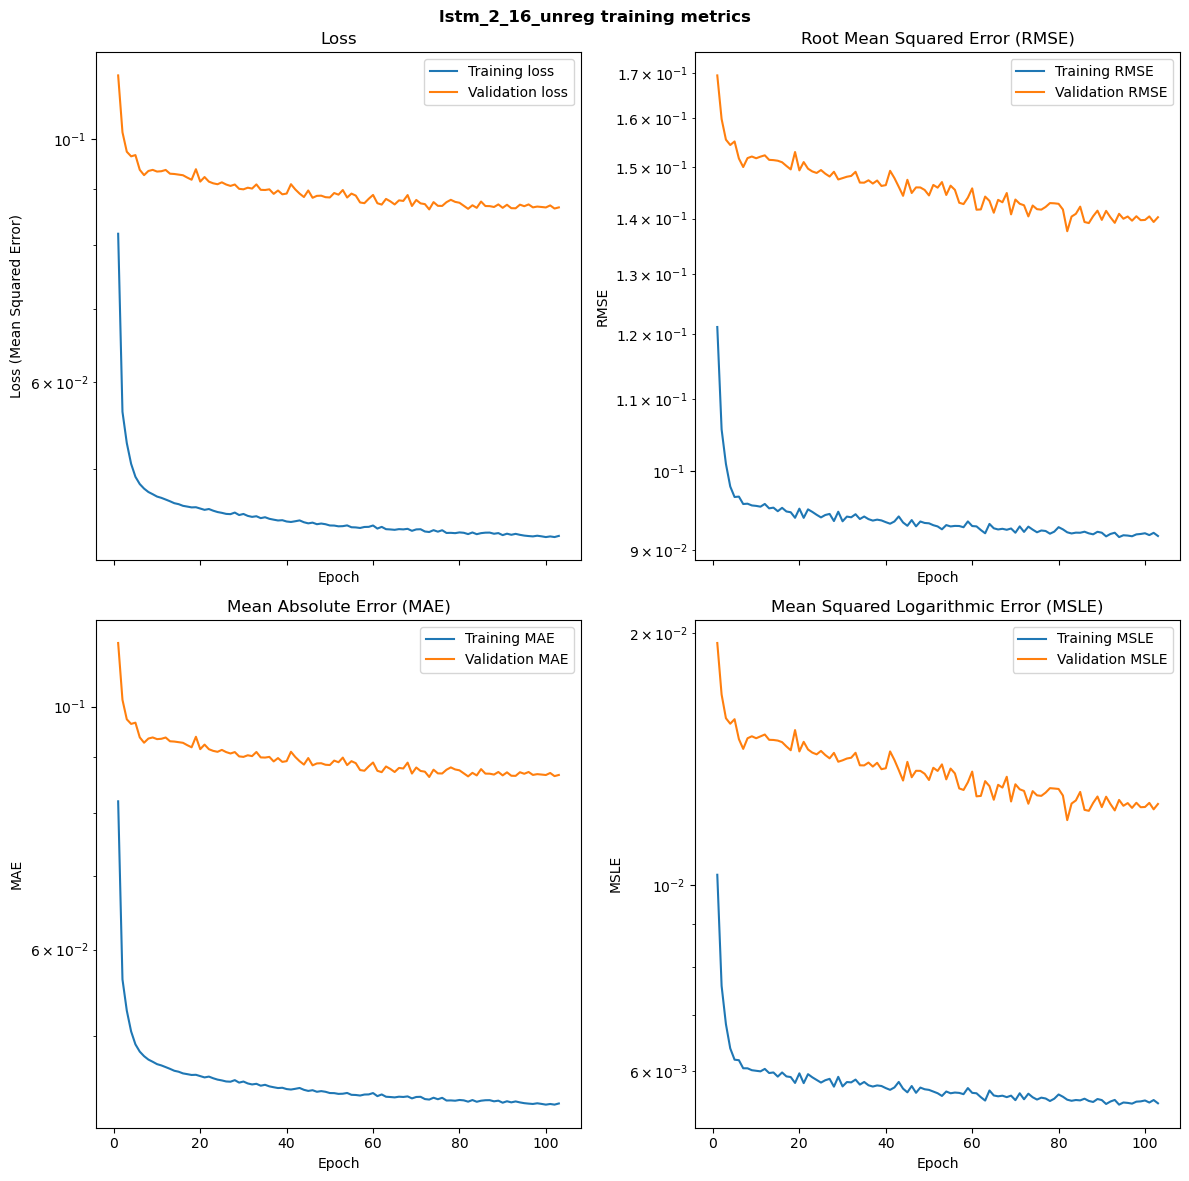

3/3 [==============================] - 1s 2ms/step
(6, 93)


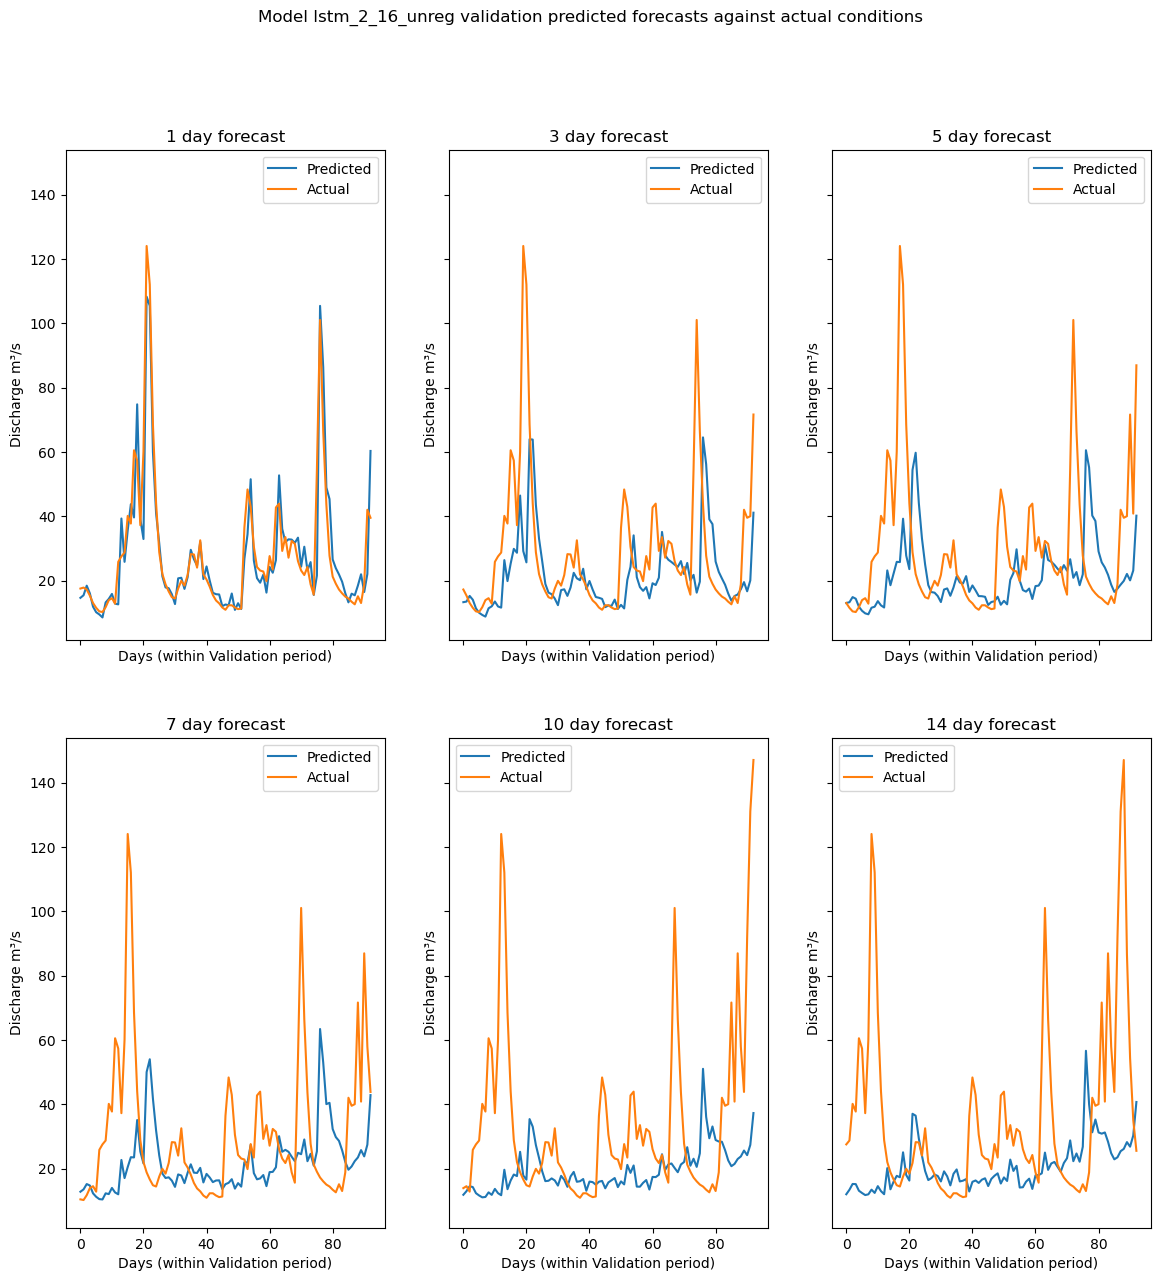

3/3 [==============================] - 0s 2ms/step
(6, 94)


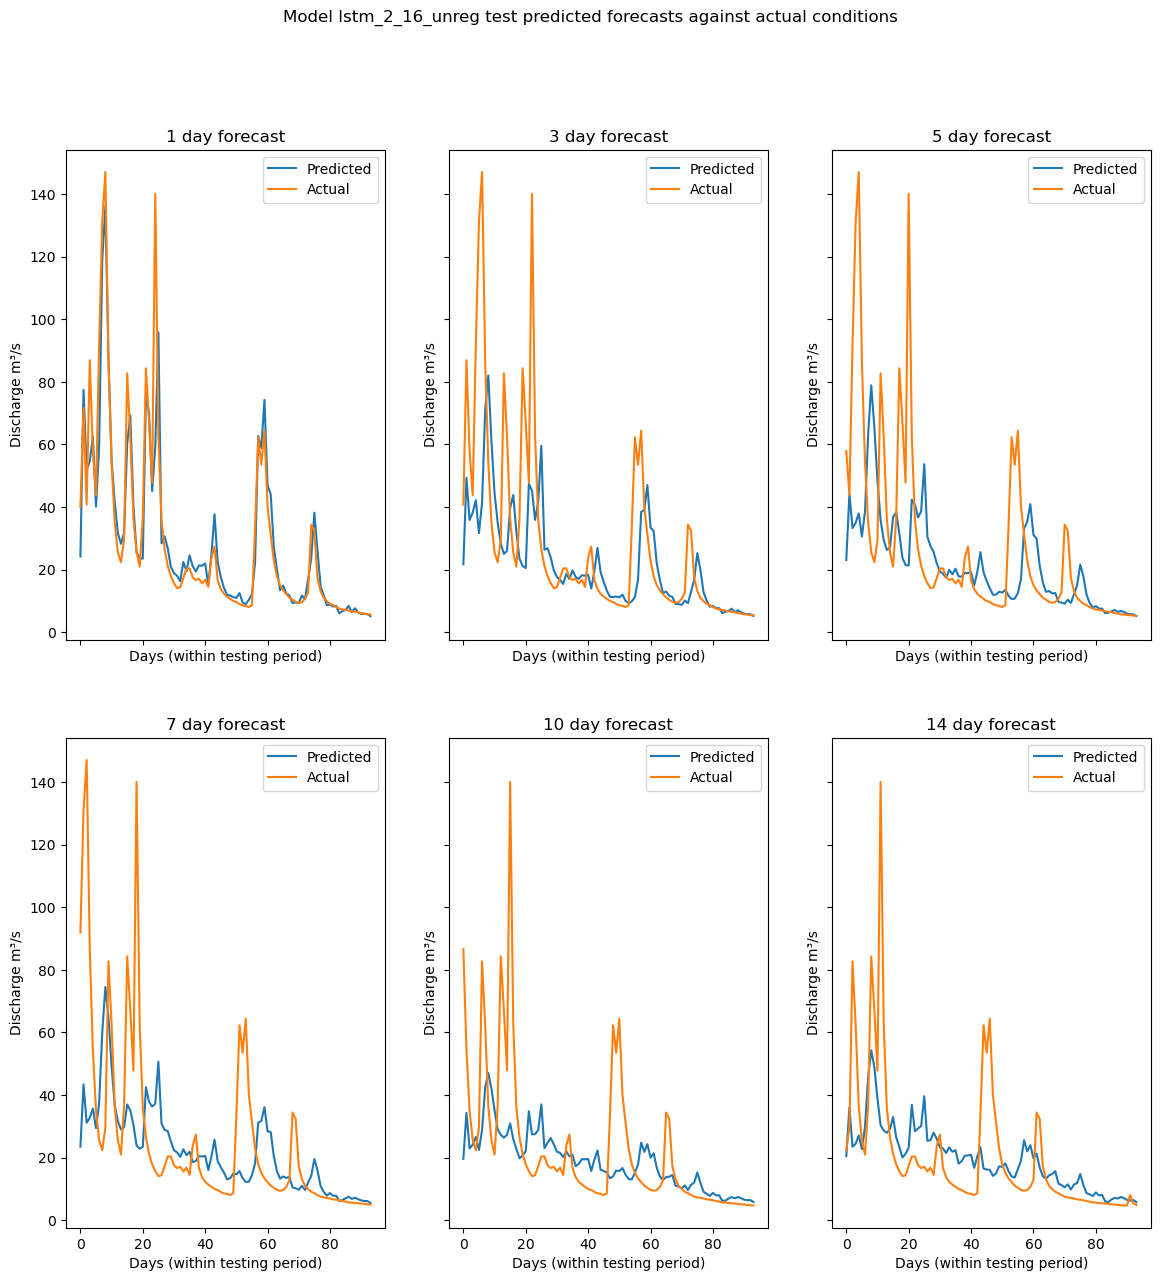

(6, 93)


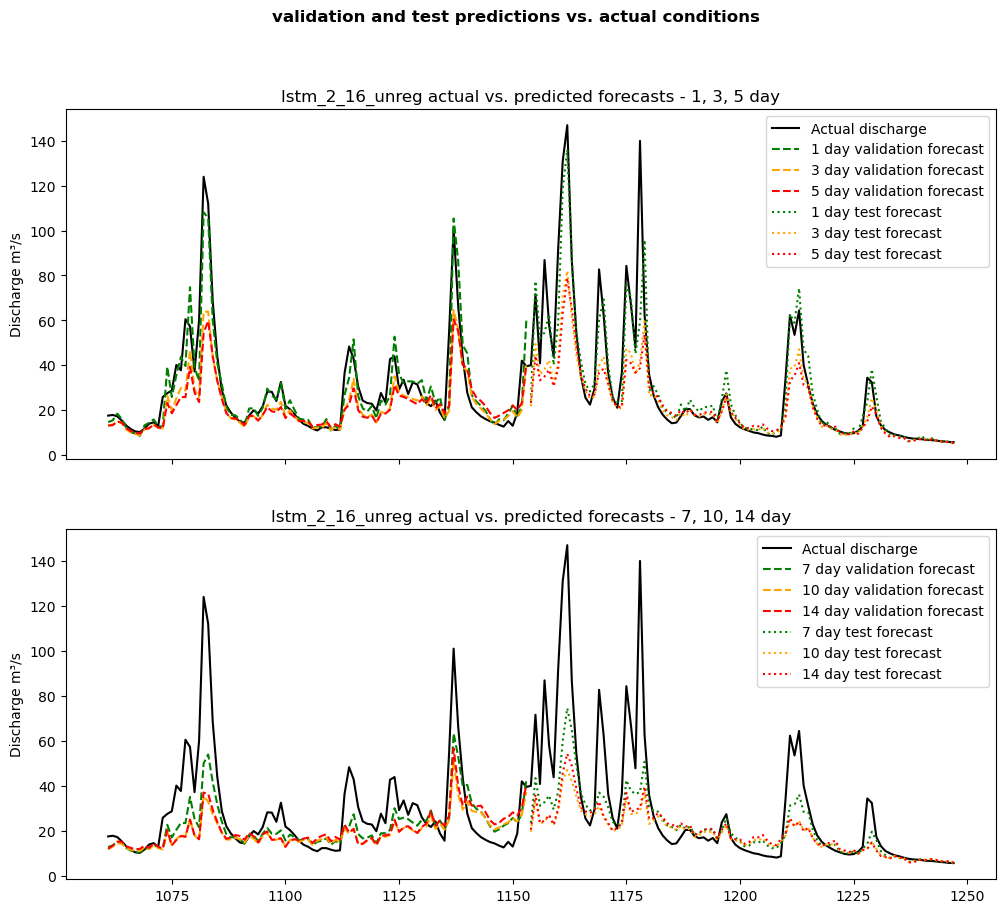

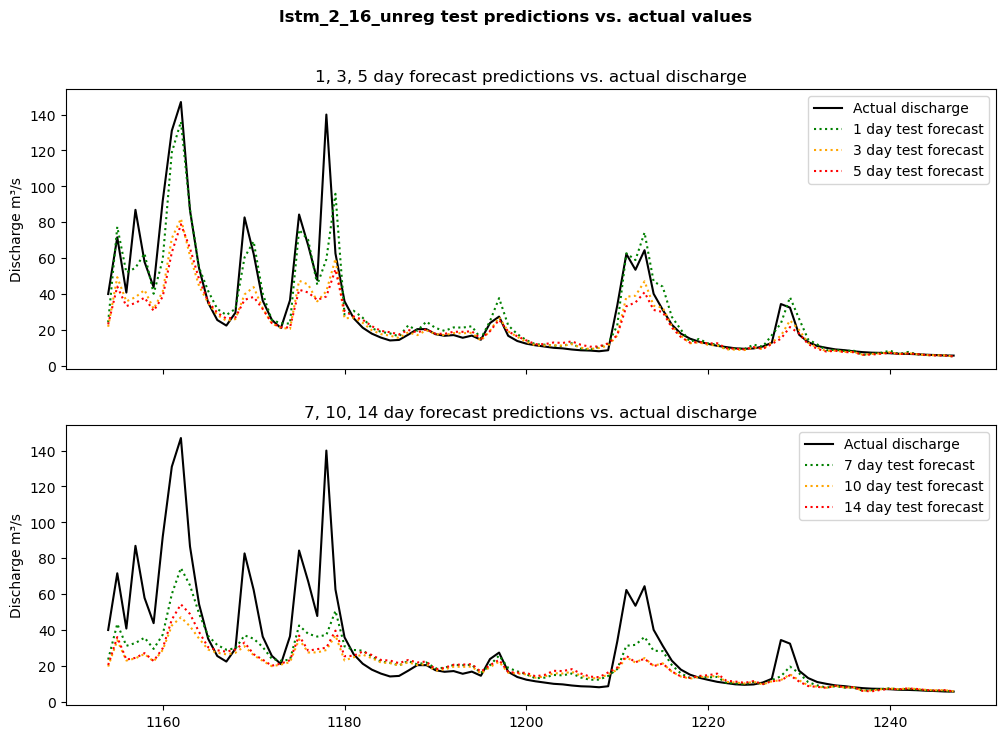

In [22]:
plot_training_metrics(lstm_2_16_unreg_hist, lstm_2_16_unreg_name)

lstm_2_16_unreg_val_results_df, lstm_2_16_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, lstm_2_16_unreg, lstm_2_16_unreg_name)

lstm_2_16_unreg_test_results_df, lstm_2_16_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, lstm_2_16_unreg, lstm_2_16_unreg_name)

plot_all_model_predictions_vs_actuals(lstm_2_16_unreg_all_val_predictions, lstm_2_16_unreg_all_test_predictions, lstm_2_16_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(lstm_2_16_unreg_all_test_predictions, lstm_2_16_unreg_name, y, X_train, X_val, X_test)


**LSTM; 2 layers; 16 units; regularized**

In [ ]:
lstm_2_16_reg_name = 'lstm_2_16_reg'

lstm_2_16_reg = Sequential([
    LSTM(units = 16, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LayerNormalization(),
    LSTM(units = 16, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

lstm_2_16_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

lstm_2_16_reg_hist = lstm_2_16_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(lstm_2_16_reg_hist, lstm_2_16_reg_name)

lstm_2_16_reg_val_results_df, lstm_2_16_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, lstm_2_16_reg, lstm_2_16_reg_name)

lstm_2_16_reg_test_results_df, lstm_2_16_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, lstm_2_16_reg, lstm_2_16_reg_name)

plot_all_model_predictions_vs_actuals(lstm_2_16_reg_all_val_predictions, lstm_2_16_reg_all_test_predictions, lstm_2_16_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(lstm_2_16_reg_all_test_predictions, lstm_2_16_reg_name, y, X_train, X_val, X_test)

**LSTM; 2 layers; 32 units; unregularized**

In [ ]:
lstm_2_32_unreg_name = 'lstm_2_32_unreg'

lstm_2_32_unreg = Sequential([
    LSTM(units = 32, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 32, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

lstm_2_32_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

lstm_2_32_unreg_hist = lstm_2_32_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(lstm_2_32_unreg_hist, lstm_2_32_unreg_name)

lstm_2_32_unreg_val_results_df, lstm_2_32_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, lstm_2_32_unreg, lstm_2_32_unreg_name)

lstm_2_32_unreg_test_results_df, lstm_2_32_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, lstm_2_32_unreg, lstm_2_32_unreg_name)

plot_all_model_predictions_vs_actuals(lstm_2_32_unreg_all_val_predictions, lstm_2_32_unreg_all_test_predictions, lstm_2_32_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(lstm_2_32_unreg_all_test_predictions, lstm_2_32_unreg_name, y, X_train, X_val, X_test)

**LSTM; 2 layers; 32 units; regularized**

In [ ]:
lstm_2_32_reg_name = 'lstm_2_32_reg'

lstm_2_32_reg = Sequential([
    LSTM(units = 32, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LayerNormalization(),
    LSTM(units = 32, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

lstm_2_32_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

lstm_2_32_reg_hist = lstm_2_32_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(lstm_2_32_reg_hist, lstm_2_32_reg_name)

lstm_2_32_reg_val_results_df, lstm_2_32_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, lstm_2_32_reg, lstm_2_32_reg_name)

lstm_2_32_reg_test_results_df, lstm_2_32_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, lstm_2_32_reg, lstm_2_32_reg_name)

plot_all_model_predictions_vs_actuals(lstm_2_32_reg_all_val_predictions, lstm_2_32_reg_all_test_predictions, lstm_2_32_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(lstm_2_32_reg_all_test_predictions, lstm_2_32_reg_name, y, X_train, X_val, X_test)

**LSTM; 2 layers; 64 units; unregularized**

In [ ]:
lstm_2_64_unreg_name = 'lstm_2_64_unreg'

lstm_2_64_unreg = Sequential([
    LSTM(units = 64, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 64, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

lstm_2_64_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

lstm_2_64_unreg_hist = lstm_2_64_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(lstm_2_64_unreg_hist, lstm_2_64_unreg_name)

lstm_2_64_unreg_val_results_df, lstm_2_64_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, lstm_2_64_unreg, lstm_2_64_unreg_name)

lstm_2_64_unreg_test_results_df, lstm_2_64_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, lstm_2_64_unreg, lstm_2_64_unreg_name)

plot_all_model_predictions_vs_actuals(lstm_2_64_unreg_all_val_predictions, lstm_2_64_unreg_all_test_predictions, lstm_2_64_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(lstm_2_64_unreg_all_test_predictions, lstm_2_64_unreg_name, y, X_train, X_val, X_test)

**LSTM; 2 layers; 64 units; regularized**

In [ ]:
lstm_2_64_reg_name = 'lstm_2_64_reg'

lstm_2_64_reg = Sequential([
    LSTM(units = 64, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LayerNormalization(),
    LSTM(units = 64, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

lstm_2_64_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

lstm_2_64_reg_hist = lstm_2_64_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(lstm_2_64_reg_hist, lstm_2_64_reg_name)

lstm_2_64_reg_val_results_df, lstm_2_64_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, lstm_2_64_reg, lstm_2_64_reg_name)

lstm_2_64_reg_test_results_df, lstm_2_64_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, lstm_2_64_reg, lstm_2_64_reg_name)

plot_all_model_predictions_vs_actuals(lstm_2_64_reg_all_val_predictions, lstm_2_64_reg_all_test_predictions, lstm_2_64_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(lstm_2_64_reg_all_test_predictions, lstm_2_64_reg_name, y, X_train, X_val, X_test)

**LSTM; 4 layers; 16 units; unregularized**

In [ ]:
lstm_4_16_unreg_name = 'lstm_4_16_unreg'

lstm_4_16_unreg = Sequential([
    LSTM(units = 16, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 16, return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 16, return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 16, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

lstm_4_16_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

lstm_4_16_unreg_hist = lstm_4_16_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(lstm_4_16_unreg_hist, lstm_4_16_unreg_name)

lstm_4_16_unreg_val_results_df, lstm_4_16_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, lstm_4_16_unreg, lstm_4_16_unreg_name)

lstm_4_16_unreg_test_results_df, lstm_4_16_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, lstm_4_16_unreg, lstm_4_16_unreg_name)

plot_all_model_predictions_vs_actuals(lstm_4_16_unreg_all_val_predictions, lstm_4_16_unreg_all_test_predictions, lstm_4_16_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(lstm_4_16_unreg_all_test_predictions, lstm_4_16_unreg_name, y, X_train, X_val, X_test)

**LSTM; 4 layers; 16 units; regularized**

In [ ]:
lstm_4_16_reg_name = 'lstm_4_16_reg'

lstm_4_16_reg = Sequential([
    LSTM(units = 16, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LayerNormalization(),
    LSTM(units = 16, return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 16, return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 16, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

lstm_4_16_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

lstm_4_16_reg_hist = lstm_4_16_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(lstm_4_16_reg_hist, lstm_4_16_reg_name)

lstm_4_16_reg_val_results_df, lstm_4_16_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, lstm_4_16_reg, lstm_4_16_reg_name)

lstm_4_16_reg_test_results_df, lstm_4_16_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, lstm_4_16_reg, lstm_4_16_reg_name)

plot_all_model_predictions_vs_actuals(lstm_4_16_reg_all_val_predictions, lstm_4_16_reg_all_test_predictions, lstm_4_16_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(lstm_4_16_reg_all_test_predictions, lstm_4_16_reg_name, y, X_train, X_val, X_test)

**LSTM; 4 layers; 32 units; unregularized**

In [ ]:
lstm_4_32_unreg_name = 'lstm_4_32_unreg'

lstm_4_32_unreg = Sequential([
    LSTM(units = 32, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 32, return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 32, return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 32, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

lstm_4_32_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

lstm_4_32_unreg_hist = lstm_4_32_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(lstm_4_32_unreg_hist, lstm_4_32_unreg_name)

lstm_4_32_unreg_val_results_df, lstm_4_32_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, lstm_4_32_unreg, lstm_4_32_unreg_name)

lstm_4_32_unreg_test_results_df, lstm_4_32_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, lstm_4_32_unreg, lstm_4_32_unreg_name)

plot_all_model_predictions_vs_actuals(lstm_4_32_unreg_all_val_predictions, lstm_4_32_unreg_all_test_predictions, lstm_4_32_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(lstm_4_32_unreg_all_test_predictions, lstm_4_32_unreg_name, y, X_train, X_val, X_test)

**LSTM; 4 layers; 32 units; regularized**

In [ ]:
lstm_4_32_reg_name = 'lstm_4_32_reg'

lstm_4_32_reg = Sequential([
    LSTM(units = 32, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LayerNormalization(),
    LSTM(units = 32, return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 32, return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 32, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

lstm_4_32_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

lstm_4_32_reg_hist = lstm_4_32_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(lstm_4_32_reg_hist, lstm_4_32_reg_name)

lstm_4_32_reg_val_results_df, lstm_4_32_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, lstm_4_32_reg, lstm_4_32_reg_name)

lstm_4_32_reg_test_results_df, lstm_4_32_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, lstm_4_32_reg, lstm_4_32_reg_name)

plot_all_model_predictions_vs_actuals(lstm_4_32_reg_all_val_predictions, lstm_4_32_reg_all_test_predictions, lstm_4_32_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(lstm_4_32_reg_all_test_predictions, lstm_4_32_reg_name, y, X_train, X_val, X_test)

**LSTM; 4 layers; 64 units; unregularized**

In [ ]:
lstm_4_64_unreg_name = 'lstm_4_64_unreg'

lstm_4_64_unreg = Sequential([
    LSTM(units = 64, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 64, return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 64, return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 64, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

lstm_4_64_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

lstm_4_64_unreg_hist = lstm_4_64_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [2]:
plot_training_metrics(lstm_4_64_unreg_hist, lstm_4_64_unreg_name)

lstm_4_64_unreg_val_results_df, lstm_4_64_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, lstm_4_64_unreg, lstm_4_64_unreg_name)

lstm_4_64_unreg_test_results_df, lstm_4_64_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, lstm_4_64_unreg, lstm_4_64_unreg_name)

plot_all_model_predictions_vs_actuals(lstm_4_64_unreg_all_val_predictions, lstm_4_64_unreg_all_test_predictions, lstm_4_64_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(lstm_4_64_unreg_all_test_predictions, lstm_4_64_unreg_name, y, X_train, X_val, X_test)

NameError: name 'plot_training_metrics' is not defined

**LSTM; 4 layers; 64 units; regularized**

In [ ]:
lstm_4_64_reg_name = 'lstm_4_64_reg'

lstm_4_64_reg = Sequential([
    LSTM(units = 64, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LayerNormalization(),
    LSTM(units = 64, return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 64, return_sequences = True, kernel_constraint = NonNeg()),
    LSTM(units = 64, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

lstm_4_64_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

lstm_4_64_reg_hist = lstm_4_64_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(lstm_4_64_reg_hist, lstm_4_64_reg_name)

lstm_4_64_reg_val_results_df, lstm_4_64_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, lstm_4_64_reg, lstm_4_64_reg_name)

lstm_4_64_reg_test_results_df, lstm_4_64_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, lstm_4_64_reg, lstm_4_64_reg_name)

plot_all_model_predictions_vs_actuals(lstm_4_64_reg_all_val_predictions, lstm_4_64_reg_all_test_predictions, lstm_4_64_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(lstm_4_64_reg_all_test_predictions, lstm_4_64_reg_name, y, X_train, X_val, X_test)

**Bidirectional LSTMs**
=======================

**Bidirectional LSTM; 2 layers; 16 units; unregularized**

In [23]:
bi_lstm_2_16_unreg_name = 'bi_lstm_2_16_unreg'

bi_lstm_2_16_unreg = Sequential([
    Bidirectional(LSTM(units = 16, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(LSTM(units = 16, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_lstm_2_16_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_lstm_2_16_unreg_hist = bi_lstm_2_16_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

Epoch 1/250
34/34 [==============================] - 9s 51ms/step - loss: 0.1788 - root_mean_squared_error: 0.2270 - mean_absolute_error: 0.1788 - mean_squared_logarithmic_error: 0.0340 - val_loss: 0.0978 - val_root_mean_squared_error: 0.1518 - val_mean_absolute_error: 0.0978 - val_mean_squared_logarithmic_error: 0.0150 - lr: 0.0010
Epoch 2/250
34/34 [==============================] - 0s 5ms/step - loss: 0.0615 - root_mean_squared_error: 0.1063 - mean_absolute_error: 0.0615 - mean_squared_logarithmic_error: 0.0078 - val_loss: 0.1078 - val_root_mean_squared_error: 0.1653 - val_mean_absolute_error: 0.1078 - val_mean_squared_logarithmic_error: 0.0184 - lr: 0.0010
Epoch 3/250
34/34 [==============================] - 0s 5ms/step - loss: 0.0559 - root_mean_squared_error: 0.1017 - mean_absolute_error: 0.0559 - mean_squared_logarithmic_error: 0.0070 - val_loss: 0.1008 - val_root_mean_squared_error: 0.1590 - val_mean_absolute_error: 0.1008 - val_mean_squared_logarithmic_error: 0.0168 - lr: 0.00

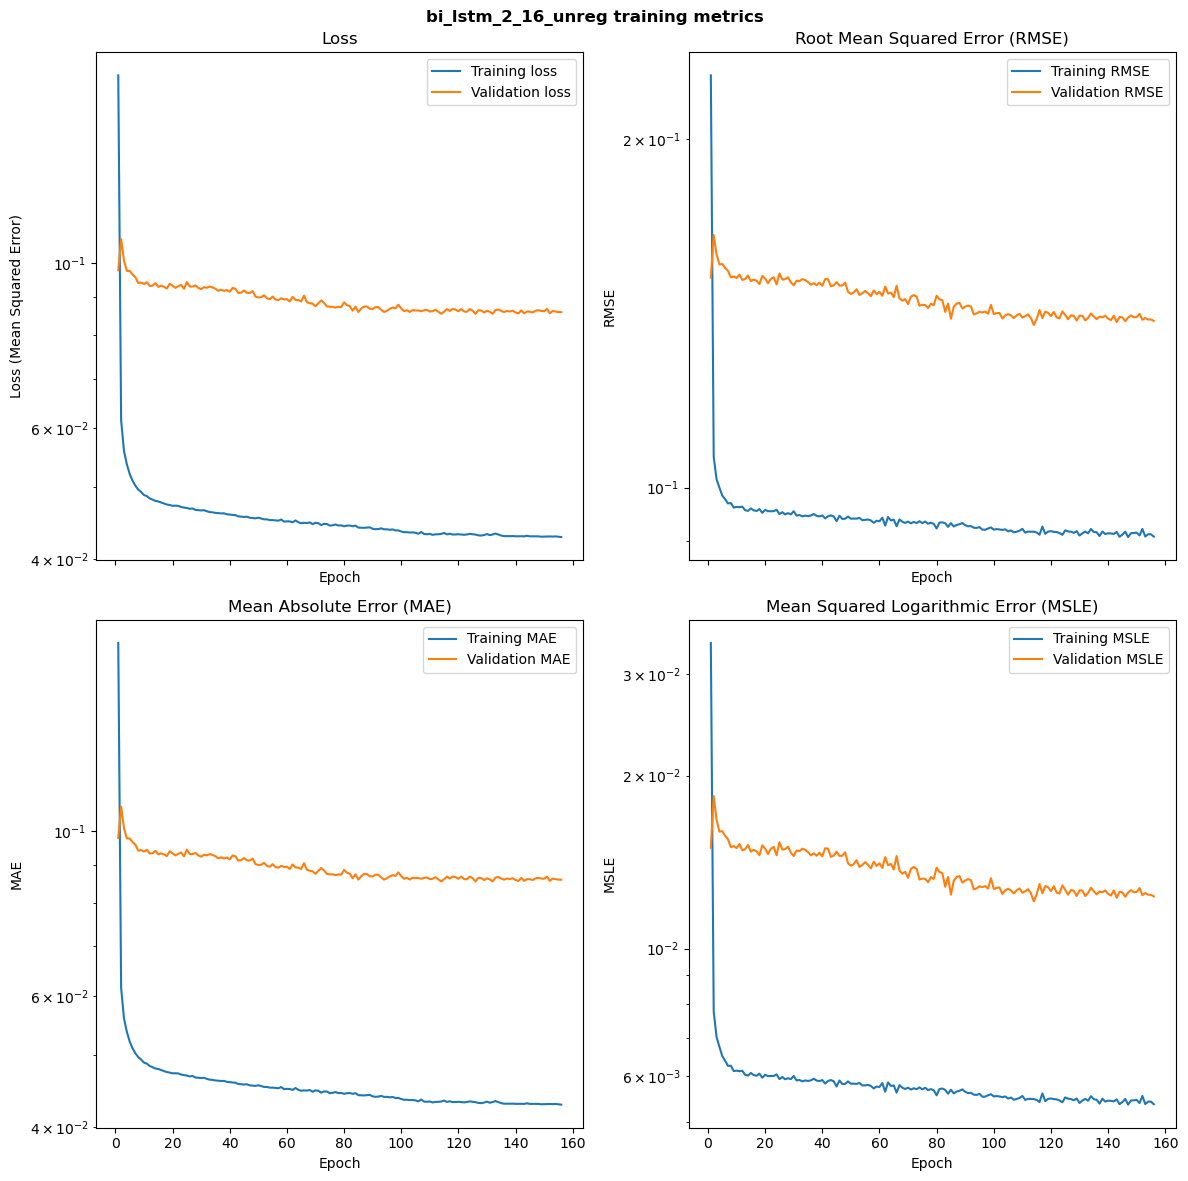

3/3 [==============================] - 1s 2ms/step
(6, 93)


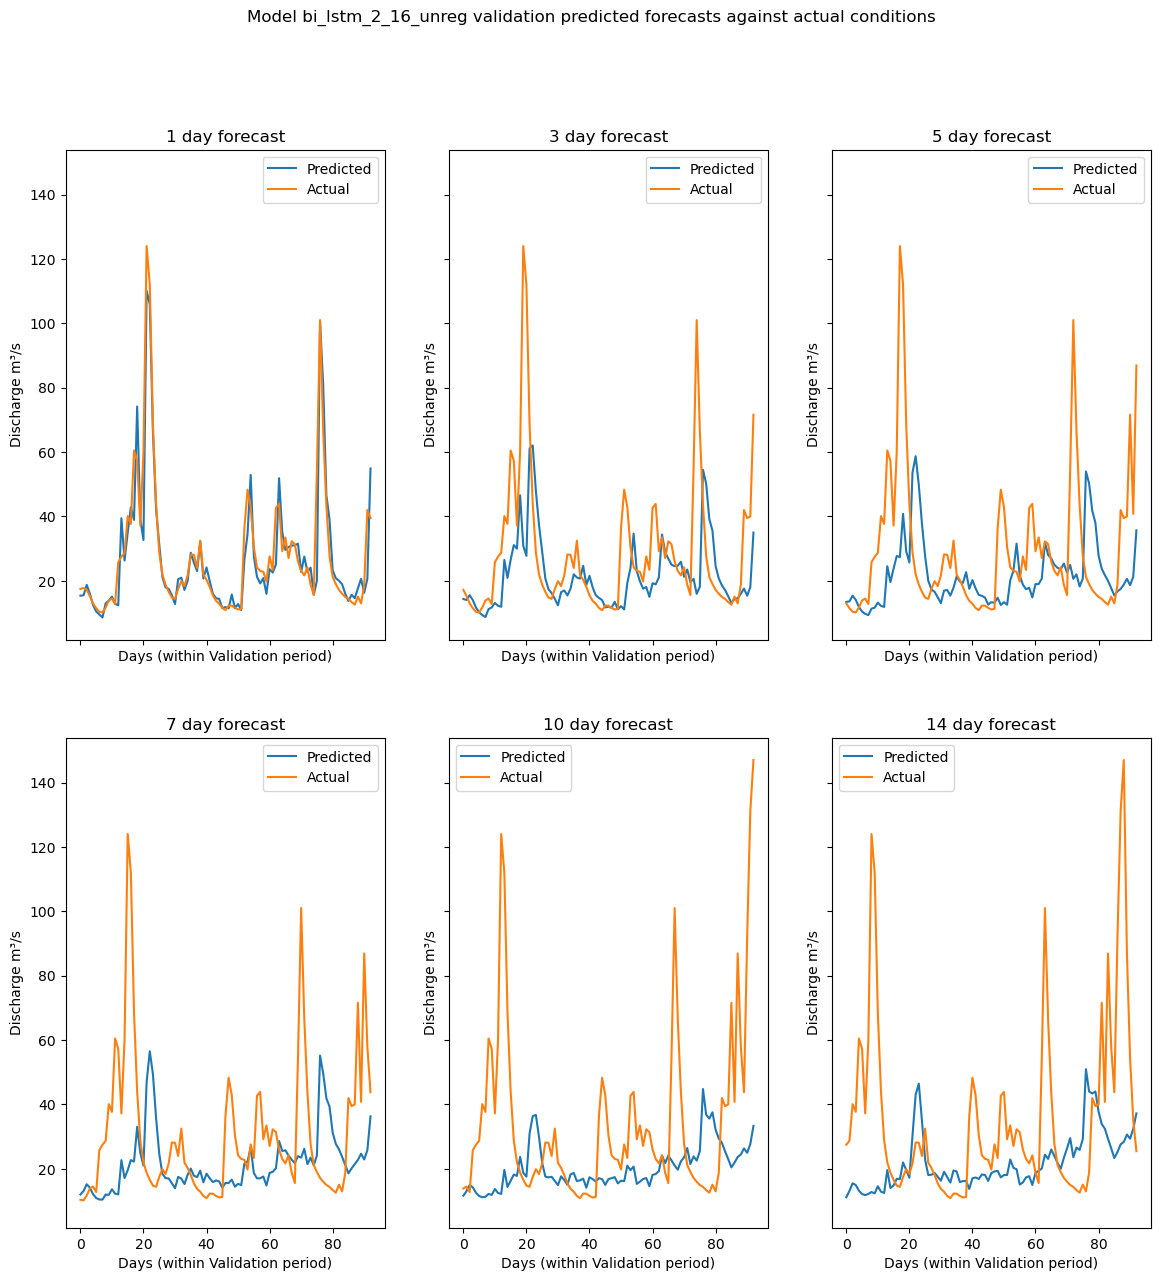

3/3 [==============================] - 0s 3ms/step
(6, 94)


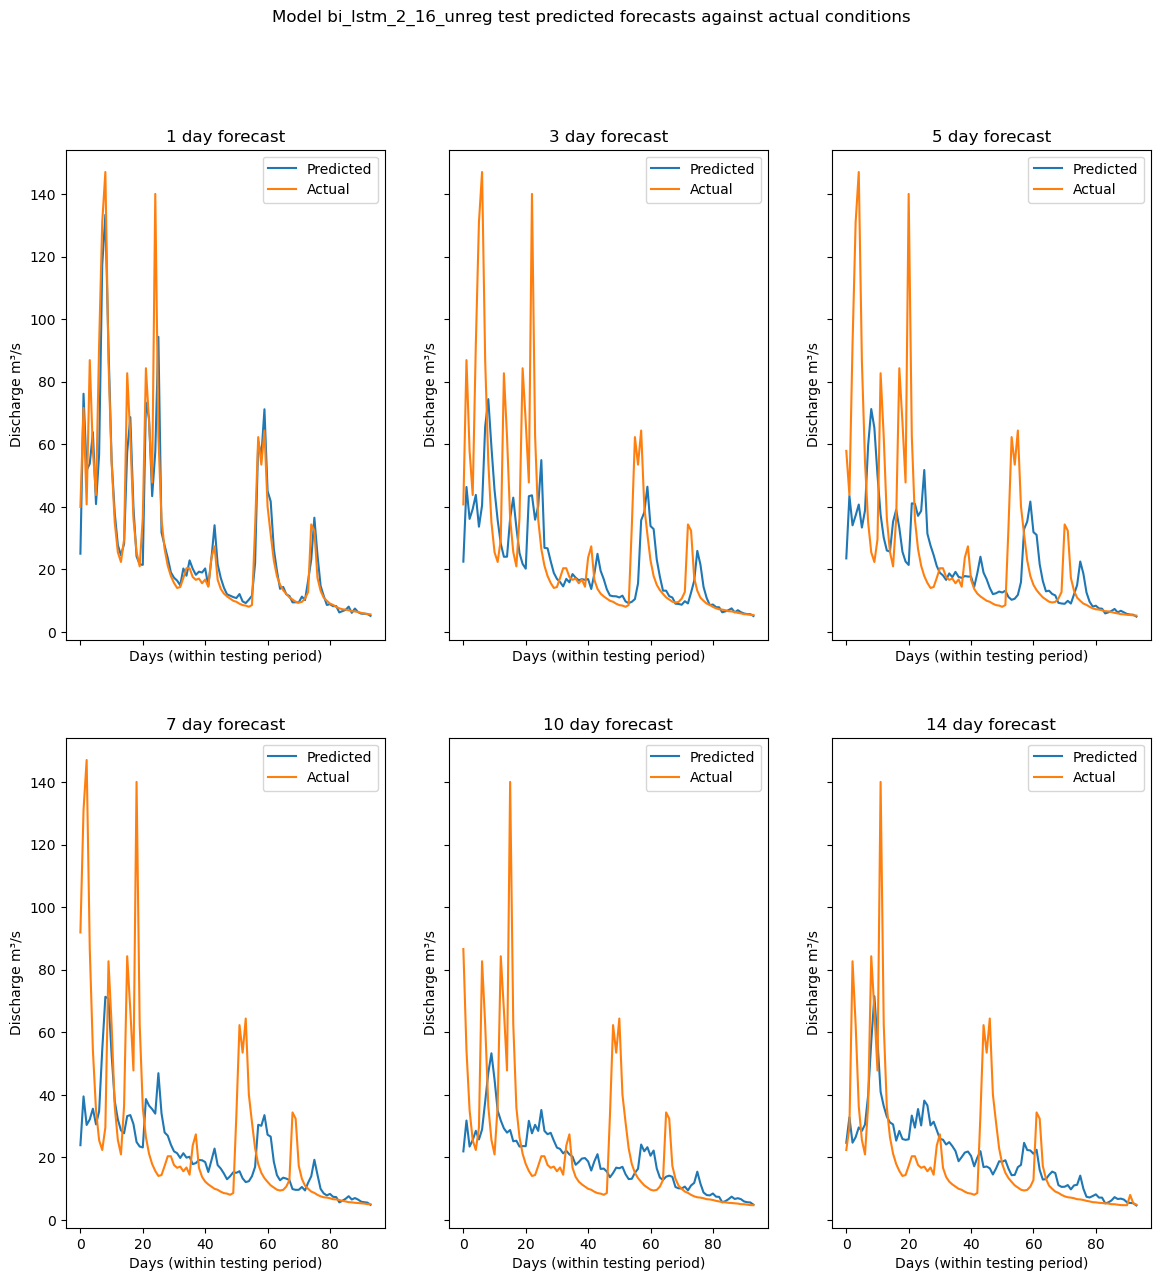

(6, 93)


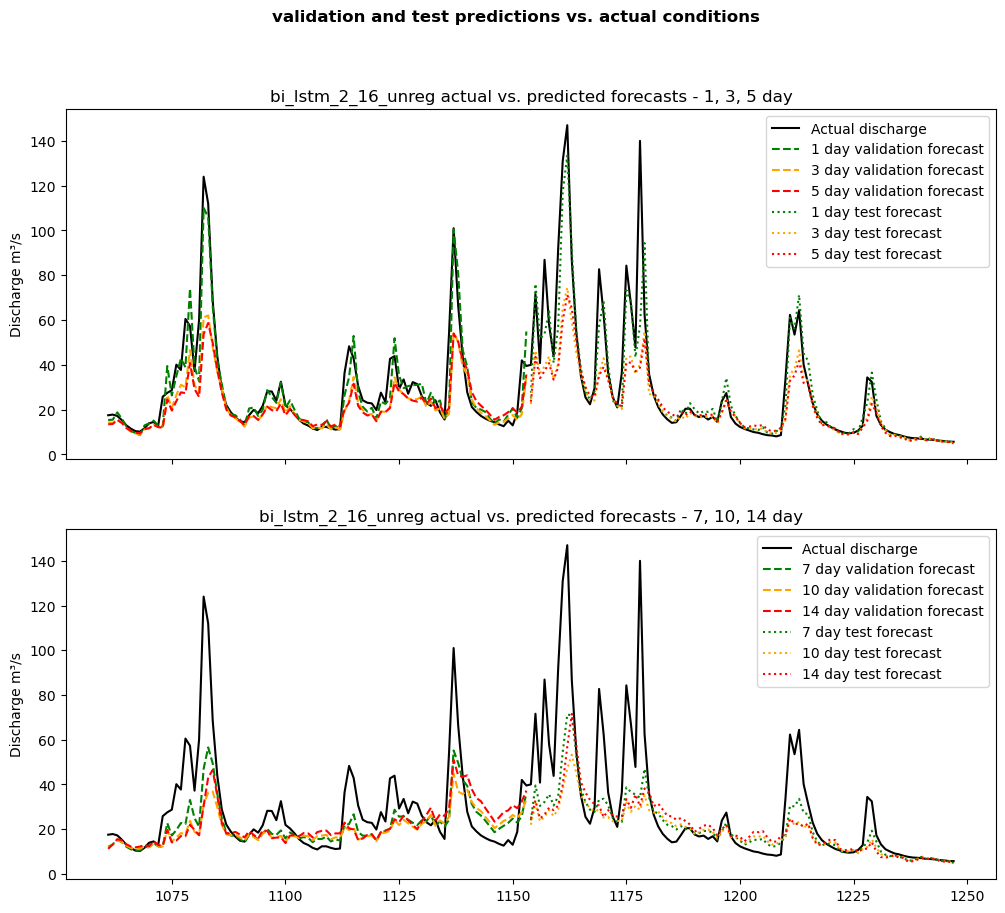

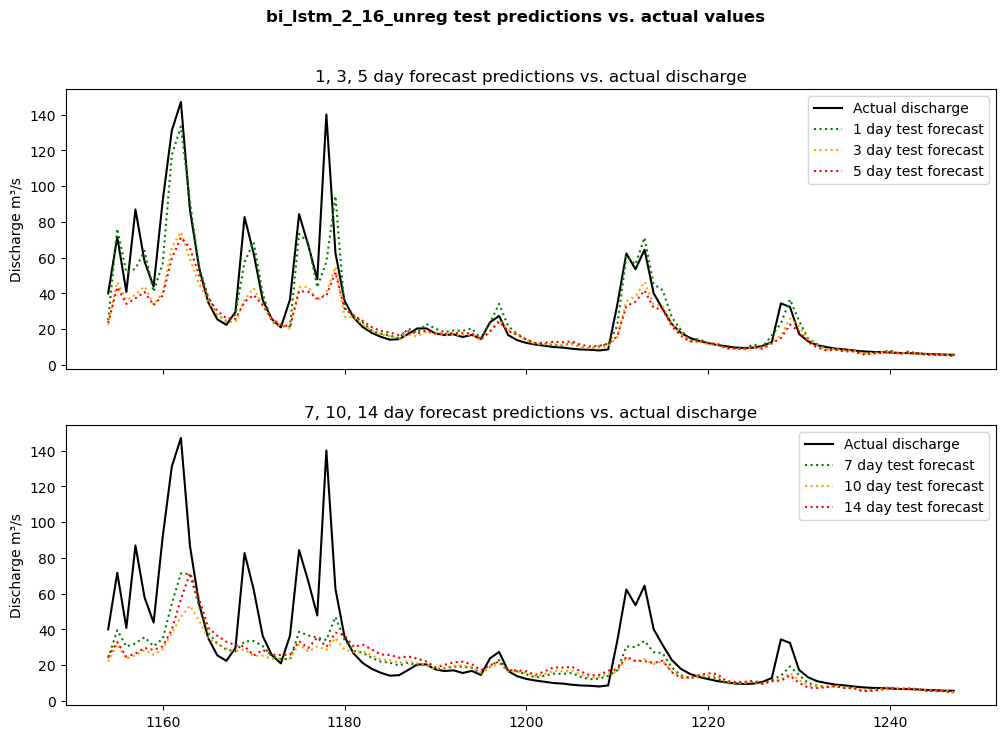

In [24]:
plot_training_metrics(bi_lstm_2_16_unreg_hist, bi_lstm_2_16_unreg_name)

bi_lstm_2_16_unreg_val_results_df, bi_lstm_2_16_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_lstm_2_16_unreg, bi_lstm_2_16_unreg_name)

bi_lstm_2_16_unreg_test_results_df, bi_lstm_2_16_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_lstm_2_16_unreg, bi_lstm_2_16_unreg_name)

plot_all_model_predictions_vs_actuals(bi_lstm_2_16_unreg_all_val_predictions, bi_lstm_2_16_unreg_all_test_predictions, bi_lstm_2_16_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_lstm_2_16_unreg_all_test_predictions, bi_lstm_2_16_unreg_name, y, X_train, X_val, X_test)

**Bidirectional LSTM; 2 layers; 16 units; regularized**

In [ ]:
bi_lstm_2_16_reg_name = 'bi_lstm_2_16_reg'

bi_lstm_2_16_reg = Sequential([
    Bidirectional(LSTM(units = 16, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    LayerNormalization(),
    Bidirectional(LSTM(units = 16, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_lstm_2_16_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_lstm_2_16_reg_hist = bi_lstm_2_16_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_lstm_2_16_reg_hist, bi_lstm_2_16_reg_name)

bi_lstm_2_16_reg_val_results_df, bi_lstm_2_16_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_lstm_2_16_reg, bi_lstm_2_16_reg_name)

bi_lstm_2_16_reg_test_results_df, bi_lstm_2_16_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_lstm_2_16_reg, bi_lstm_2_16_reg_name)

plot_all_model_predictions_vs_actuals(bi_lstm_2_16_reg_all_val_predictions, bi_lstm_2_16_reg_all_test_predictions, bi_lstm_2_16_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_lstm_2_16_reg_all_test_predictions, bi_lstm_2_16_reg_name, y, X_train, X_val, X_test)

**Bidirectional LSTM; 2 layers; 32 units; unregularized**

In [ ]:
bi_lstm_2_32_unreg_name = 'lstm_2_32_unreg'

bi_lstm_2_32_unreg = Sequential([
    Bidirectional(LSTM(units = 32, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(LSTM(units = 32, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_lstm_2_32_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_lstm_2_32_unreg_hist = bi_lstm_2_32_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_lstm_2_32_unreg_hist, bi_lstm_2_32_unreg_name)

bi_lstm_2_32_unreg_val_results_df, bi_lstm_2_32_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_lstm_2_32_unreg, bi_lstm_2_32_unreg_name)

bi_lstm_2_32_unreg_test_results_df, bi_lstm_2_32_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_lstm_2_32_unreg, bi_lstm_2_32_unreg_name)

plot_all_model_predictions_vs_actuals(bi_lstm_2_32_unreg_all_val_predictions, bi_lstm_2_32_unreg_all_test_predictions, bi_lstm_2_32_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_lstm_2_32_unreg_all_test_predictions, bi_lstm_2_32_unreg_name, y, X_train, X_val, X_test)

**Bidirectional LSTM; 2 layers; 32 units; regularized**

In [ ]:
bi_lstm_2_32_reg_name = 'lstm_2_32_reg'

bi_lstm_2_32_reg = Sequential([
    Bidirectional(LSTM(units = 32, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    LayerNormalization(),
    Bidirectional(LSTM(units = 32, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_lstm_2_32_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_lstm_2_32_reg_hist = bi_lstm_2_32_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_lstm_2_32_reg_hist, bi_lstm_2_32_reg_name)

bi_lstm_2_32_reg_val_results_df, bi_lstm_2_32_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_lstm_2_32_reg, bi_lstm_2_32_reg_name)

bi_lstm_2_32_reg_test_results_df, bi_lstm_2_32_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_lstm_2_32_reg, bi_lstm_2_32_reg_name)

plot_all_model_predictions_vs_actuals(bi_lstm_2_32_reg_all_val_predictions, bi_lstm_2_32_reg_all_test_predictions, bi_lstm_2_32_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_lstm_2_32_reg_all_test_predictions, bi_lstm_2_32_reg_name, y, X_train, X_val, X_test)

**Bidirectional LSTM; 2 layers; 64 units; unregularized**

In [ ]:
bi_lstm_2_64_unreg_name = 'lstm_2_64_unreg'

bi_lstm_2_64_unreg = Sequential([
    Bidirectional(LSTM(units = 64, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(LSTM(units = 64, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_lstm_2_64_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_lstm_2_64_unreg_hist = bi_lstm_2_64_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_lstm_2_64_unreg_hist, bi_lstm_2_64_unreg_name)

bi_lstm_2_64_unreg_val_results_df, bi_lstm_2_64_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_lstm_2_64_unreg, bi_lstm_2_64_unreg_name)

bi_lstm_2_64_unreg_test_results_df, bi_lstm_2_64_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_lstm_2_64_unreg, bi_lstm_2_64_unreg_name)

plot_all_model_predictions_vs_actuals(bi_lstm_2_64_unreg_all_val_predictions, bi_lstm_2_64_unreg_all_test_predictions, bi_lstm_2_64_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_lstm_2_64_unreg_all_test_predictions, bi_lstm_2_64_unreg_name, y, X_train, X_val, X_test)

**Bidirectional LSTM; 2 layers; 64 units; regularized**

In [ ]:
bi_lstm_2_64_reg_name = 'lstm_2_64_reg'

bi_lstm_2_64_reg = Sequential([
    Bidirectional(LSTM(units = 64, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    LayerNormalization(),
    Bidirectional(LSTM(units = 64, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_lstm_2_64_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_lstm_2_64_reg_hist = bi_lstm_2_64_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_lstm_2_64_reg_hist, bi_lstm_2_64_reg_name)

bi_lstm_2_64_reg_val_results_df, bi_lstm_2_64_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_lstm_2_64_reg, bi_lstm_2_64_reg_name)

bi_lstm_2_64_reg_test_results_df, bi_lstm_2_64_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_lstm_2_64_reg, bi_lstm_2_64_reg_name)

plot_all_model_predictions_vs_actuals(bi_lstm_2_64_reg_all_val_predictions, bi_lstm_2_64_reg_all_test_predictions, bi_lstm_2_64_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_lstm_2_64_reg_all_test_predictions, bi_lstm_2_64_reg_name, y, X_train, X_val, X_test)

**Bidirectional LSTM; 4 layers; 16 units; unregularized**

In [25]:
bi_lstm_4_16_unreg_name = 'lstm_4_16_unreg'

bi_lstm_4_16_unreg = Sequential([
    Bidirectional(LSTM(units = 16, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(LSTM(units = 16, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(LSTM(units = 16, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(LSTM(units = 16, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_lstm_4_16_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_lstm_4_16_unreg_hist = bi_lstm_4_16_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

Epoch 1/250
34/34 [==============================] - 18s 95ms/step - loss: 0.1135 - root_mean_squared_error: 0.1683 - mean_absolute_error: 0.1135 - mean_squared_logarithmic_error: 0.0189 - val_loss: 0.1312 - val_root_mean_squared_error: 0.1830 - val_mean_absolute_error: 0.1312 - val_mean_squared_logarithmic_error: 0.0232 - lr: 0.0010
Epoch 2/250
34/34 [==============================] - 0s 7ms/step - loss: 0.0609 - root_mean_squared_error: 0.1090 - mean_absolute_error: 0.0609 - mean_squared_logarithmic_error: 0.0082 - val_loss: 0.1083 - val_root_mean_squared_error: 0.1654 - val_mean_absolute_error: 0.1083 - val_mean_squared_logarithmic_error: 0.0184 - lr: 0.0010
Epoch 3/250
34/34 [==============================] - 0s 7ms/step - loss: 0.0573 - root_mean_squared_error: 0.1047 - mean_absolute_error: 0.0573 - mean_squared_logarithmic_error: 0.0075 - val_loss: 0.1067 - val_root_mean_squared_error: 0.1643 - val_mean_absolute_error: 0.1067 - val_mean_squared_logarithmic_error: 0.0181 - lr: 0.0

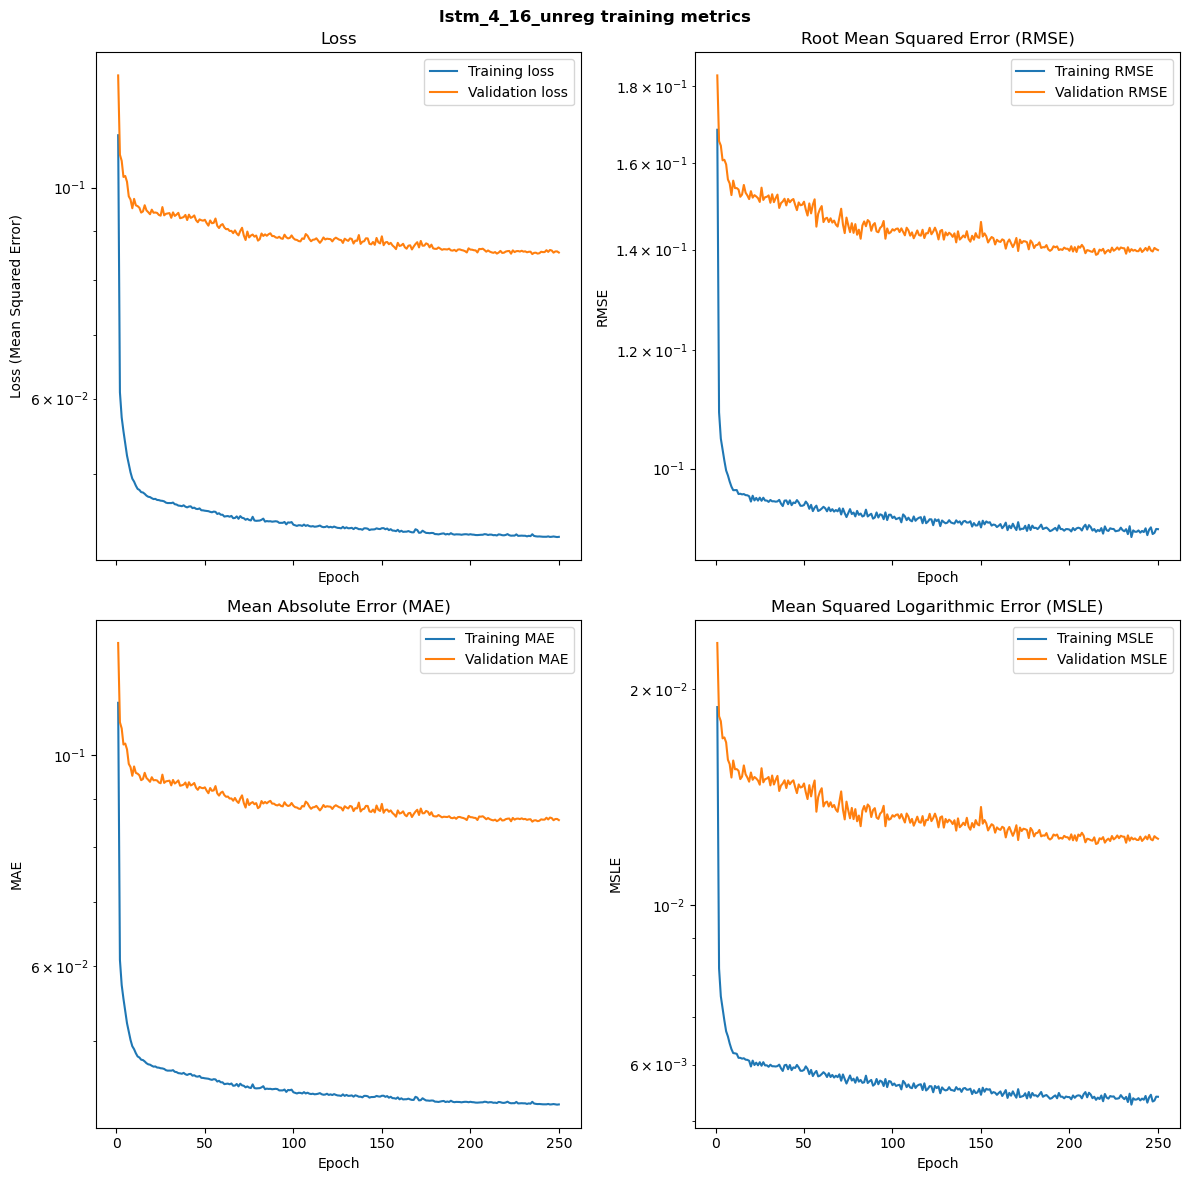

3/3 [==============================] - 3s 3ms/step
(6, 93)


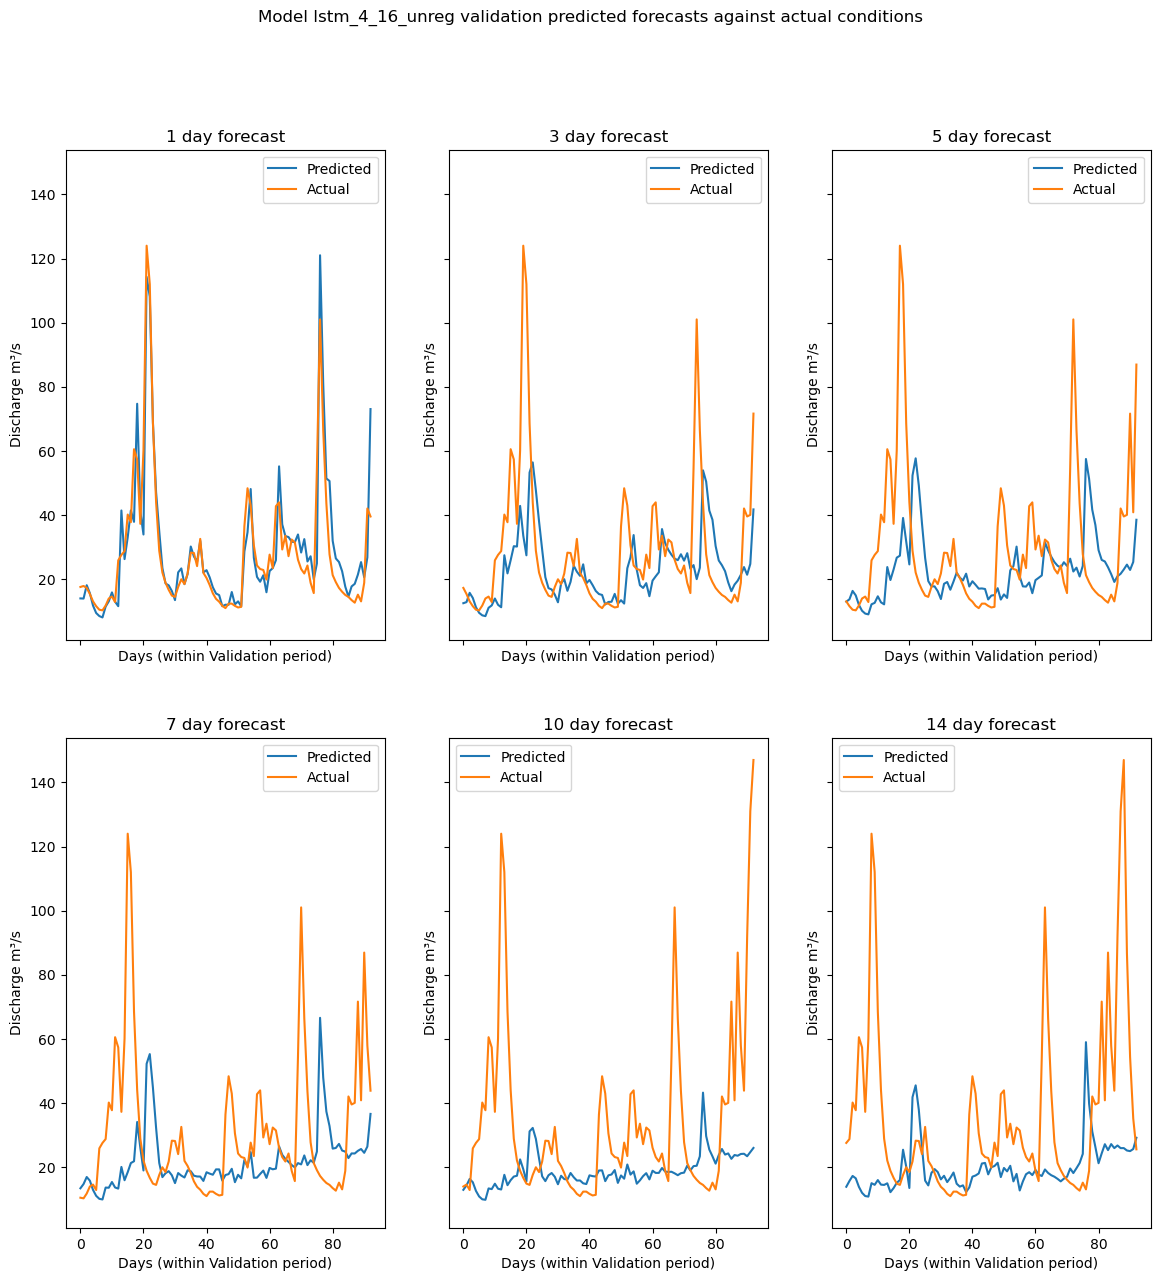

3/3 [==============================] - 0s 3ms/step
(6, 94)


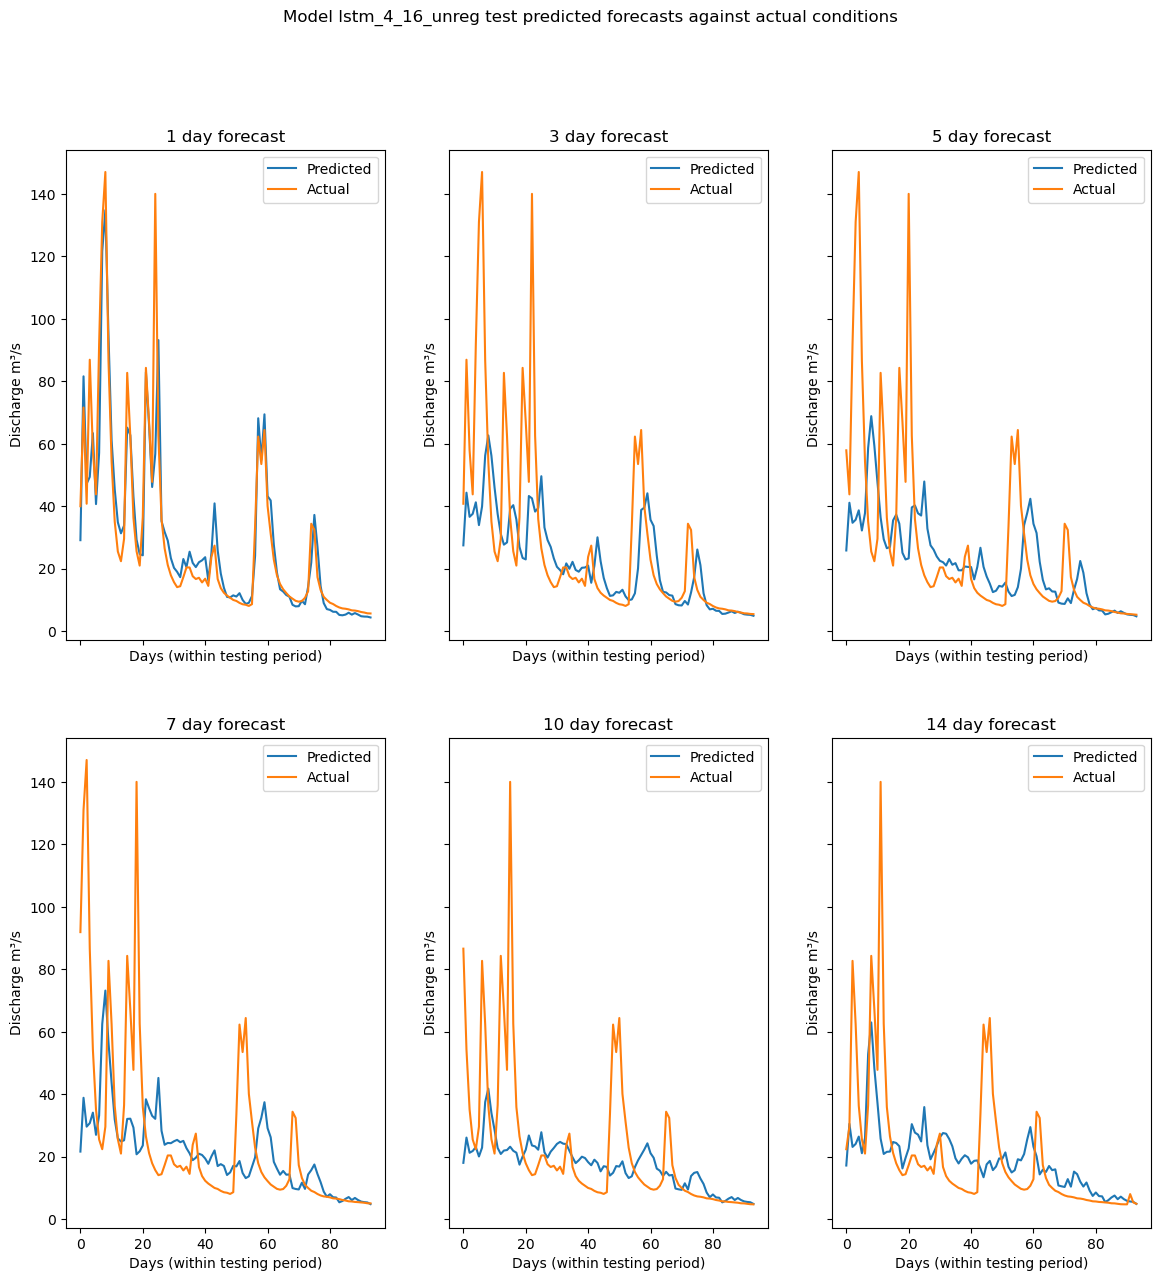

(6, 93)


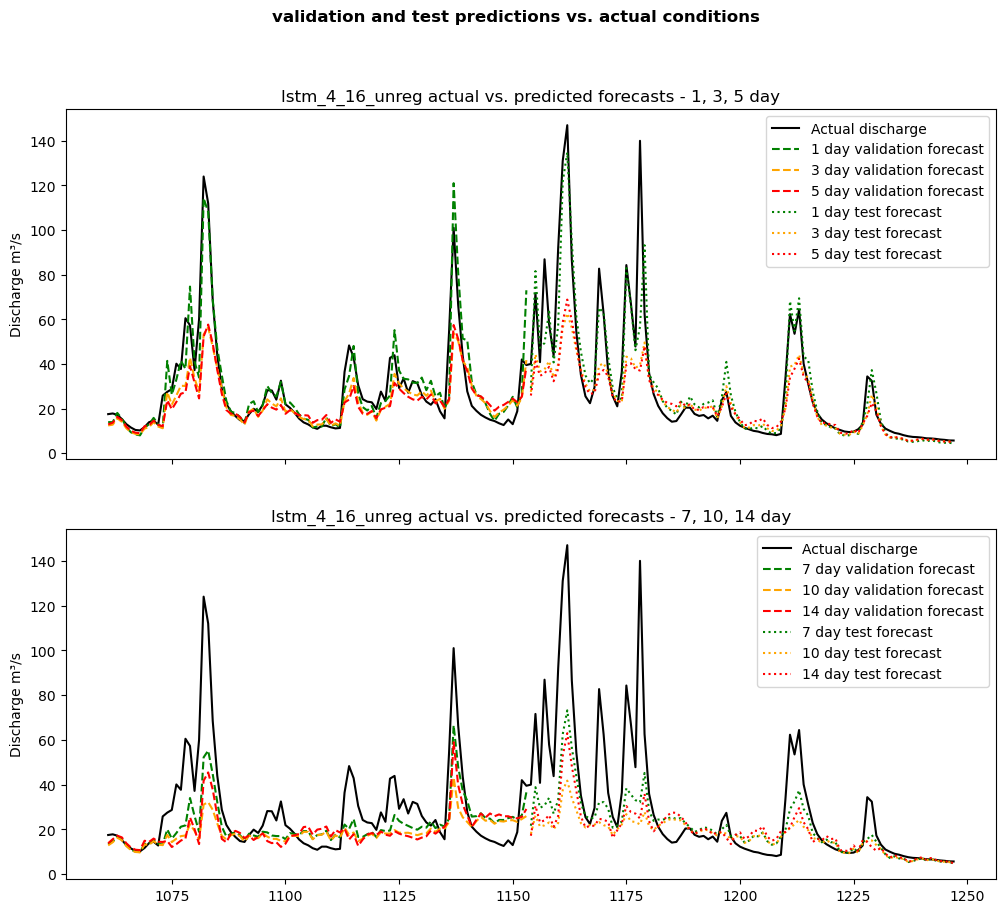

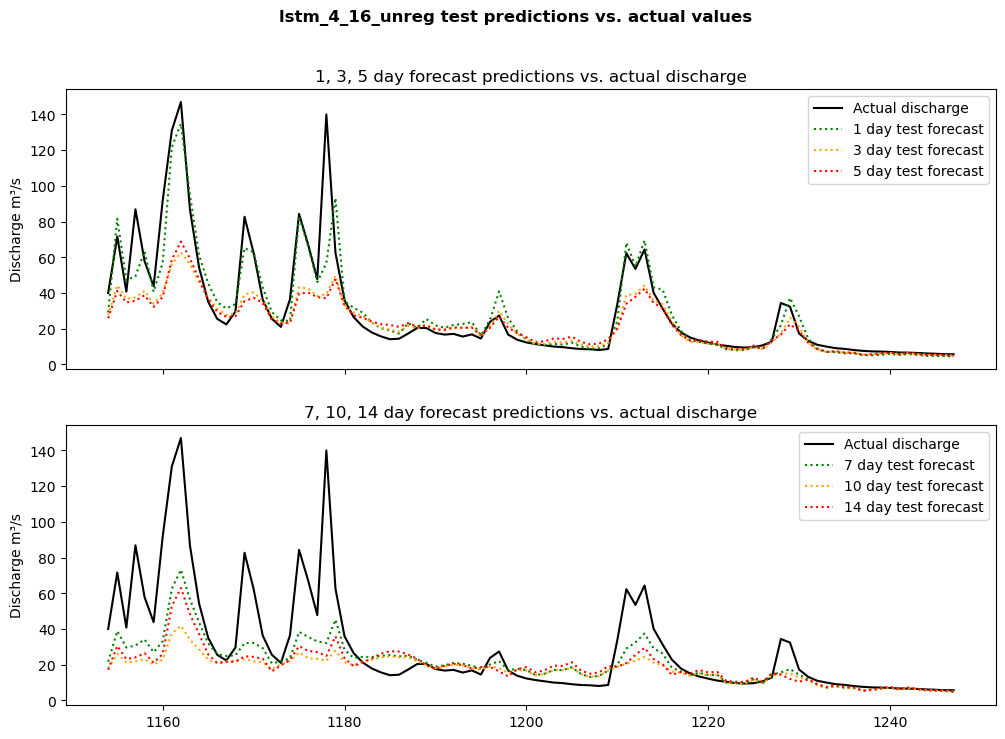

In [26]:
plot_training_metrics(bi_lstm_4_16_unreg_hist, bi_lstm_4_16_unreg_name)

bi_lstm_4_16_unreg_val_results_df, bi_lstm_4_16_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_lstm_4_16_unreg, bi_lstm_4_16_unreg_name)

bi_lstm_4_16_unreg_test_results_df, bi_lstm_4_16_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_lstm_4_16_unreg, bi_lstm_4_16_unreg_name)

plot_all_model_predictions_vs_actuals(bi_lstm_4_16_unreg_all_val_predictions, bi_lstm_4_16_unreg_all_test_predictions, bi_lstm_4_16_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_lstm_4_16_unreg_all_test_predictions, bi_lstm_4_16_unreg_name, y, X_train, X_val, X_test)

**Bidirectional LSTM; 4 layers; 16 units; regularized**

In [ ]:
bi_lstm_4_16_reg_name = 'lstm_4_16_reg'

bi_lstm_4_16_reg = Sequential([
    Bidirectional(LSTM(units = 16, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    LayerNormalization(),
    Bidirectional(LSTM(units = 16, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(LSTM(units = 16, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(LSTM(units = 16, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_lstm_4_16_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_lstm_4_16_reg_hist = bi_lstm_4_16_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_lstm_4_16_reg_hist, bi_lstm_4_16_reg_name)

bi_lstm_4_16_reg_val_results_df, bi_lstm_4_16_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_lstm_4_16_reg, bi_lstm_4_16_reg_name)

bi_lstm_4_16_reg_test_results_df, bi_lstm_4_16_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_lstm_4_16_reg, bi_lstm_4_16_reg_name)

plot_all_model_predictions_vs_actuals(bi_lstm_4_16_reg_all_val_predictions, bi_lstm_4_16_reg_all_test_predictions, bi_lstm_4_16_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_lstm_4_16_reg_all_test_predictions, bi_lstm_4_16_reg_name, y, X_train, X_val, X_test)

**Bidirectional LSTM; 4 layers; 32 units; unregularized**

In [ ]:
bi_lstm_4_32_unreg_name = 'lstm_4_32_unreg'

bi_lstm_4_32_unreg = Sequential([
    Bidirectional(LSTM(units = 32, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(LSTM(units = 32, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(LSTM(units = 32, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(LSTM(units = 32, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_lstm_4_32_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_lstm_4_32_unreg_hist = bi_lstm_4_32_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_lstm_4_32_unreg_hist, bi_lstm_4_32_unreg_name)

bi_lstm_4_32_unreg_val_results_df, bi_lstm_4_32_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_lstm_4_32_unreg, bi_lstm_4_32_unreg_name)

bi_lstm_4_32_unreg_test_results_df, bi_lstm_4_32_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_lstm_4_32_unreg, bi_lstm_4_32_unreg_name)

plot_all_model_predictions_vs_actuals(bi_lstm_4_32_unreg_all_val_predictions, bi_lstm_4_32_unreg_all_test_predictions, bi_lstm_4_32_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_lstm_4_32_unreg_all_test_predictions, bi_lstm_4_32_unreg_name, y, X_train, X_val, X_test)

**Bidirectional LSTM; 4 layers; 32 units; regularized**

In [ ]:
bi_lstm_4_32_reg_name = 'lstm_4_32_reg'

bi_lstm_4_32_reg = Sequential([
    Bidirectional(LSTM(units = 32, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    LayerNormalization(),
    Bidirectional(LSTM(units = 32, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(LSTM(units = 32, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(LSTM(units = 32, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_lstm_4_32_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_lstm_4_32_reg_hist = bi_lstm_4_32_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_lstm_4_32_reg_hist, bi_lstm_4_32_reg_name)

bi_lstm_4_32_reg_val_results_df, bi_lstm_4_32_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_lstm_4_32_reg, bi_lstm_4_32_reg_name)

bi_lstm_4_32_reg_test_results_df, bi_lstm_4_32_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_lstm_4_32_reg, bi_lstm_4_32_reg_name)

plot_all_model_predictions_vs_actuals(bi_lstm_4_32_reg_all_val_predictions, bi_lstm_4_32_reg_all_test_predictions, bi_lstm_4_32_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_lstm_4_32_reg_all_test_predictions, bi_lstm_4_32_reg_name, y, X_train, X_val, X_test)

**Bidirectional LSTM; 4 layers; 64 units; unregularized**

In [ ]:
bi_lstm_4_64_unreg_name = 'lstm_4_64_unreg'

bi_lstm_4_64_unreg = Sequential([
    Bidirectional(LSTM(units = 64, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(LSTM(units = 64, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(LSTM(units = 64, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(LSTM(units = 64, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_lstm_4_64_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_lstm_4_64_unreg_hist = bi_lstm_4_64_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_lstm_4_64_unreg_hist, bi_lstm_4_64_unreg_name)

bi_lstm_4_64_unreg_val_results_df, bi_lstm_4_64_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_lstm_4_64_unreg, bi_lstm_4_64_unreg_name)

bi_lstm_4_64_unreg_test_results_df, bi_lstm_4_64_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_lstm_4_64_unreg, bi_lstm_4_64_unreg_name)

plot_all_model_predictions_vs_actuals(bi_lstm_4_64_unreg_all_val_predictions, bi_lstm_4_64_unreg_all_test_predictions, bi_lstm_4_64_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_lstm_4_64_unreg_all_test_predictions, bi_lstm_4_64_unreg_name, y, X_train, X_val, X_test)

**Bidirectional LSTM; 4 layers; 64 units; regularized**

In [ ]:
bi_lstm_4_64_reg_name = 'lstm_4_64_reg'

bi_lstm_4_64_reg = Sequential([
    Bidirectional(LSTM(units = 64, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    LayerNormalization(),
    Bidirectional(LSTM(units = 64, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(LSTM(units = 64, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(LSTM(units = 64, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_lstm_4_64_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_lstm_4_64_reg_hist = bi_lstm_4_64_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_lstm_4_64_reg_hist, bi_lstm_4_64_reg_name)

bi_lstm_4_64_reg_val_results_df, bi_lstm_4_64_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_lstm_4_64_reg, bi_lstm_4_64_reg_name)

bi_lstm_4_64_reg_test_results_df, bi_lstm_4_64_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_lstm_4_64_reg, bi_lstm_4_64_reg_name)

plot_all_model_predictions_vs_actuals(bi_lstm_4_64_reg_all_val_predictions, bi_lstm_4_64_reg_all_test_predictions, bi_lstm_4_64_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_lstm_4_64_reg_all_test_predictions, bi_lstm_4_64_reg_name, y, X_train, X_val, X_test)

**GRU**
=======

**GRU; 2 layers; 16 units; unregularized**

In [ ]:
gru_2_16_unreg_name = 'gru_2_16_unreg'

gru_2_16_unreg = Sequential([
    GRU(units = 16, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    GRU(units = 16, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

gru_2_16_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

gru_2_16_unreg_hist = gru_2_16_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(gru_2_16_unreg_hist, gru_2_16_unreg_name)

gru_2_16_unreg_val_results_df, gru_2_16_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, gru_2_16_unreg, gru_2_16_unreg_name)

gru_2_16_unreg_test_results_df, gru_2_16_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, gru_2_16_unreg, gru_2_16_unreg_name)

plot_all_model_predictions_vs_actuals(gru_2_16_unreg_all_val_predictions, gru_2_16_unreg_all_test_predictions, gru_2_16_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(gru_2_16_unreg_all_test_predictions, gru_2_16_unreg_name, y, X_train, X_val, X_test)

**GRU; 2 layers; 16 units; regularized**

In [ ]:
gru_2_16_reg_name = 'gru_2_16_reg'

gru_2_16_reg = Sequential([
    GRU(units = 16, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LayerNormalization(),
    GRU(units = 16, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

gru_2_16_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

gru_2_16_reg_hist = gru_2_16_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(gru_2_16_reg_hist, gru_2_16_reg_name)

gru_2_16_reg_val_results_df, gru_2_16_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, gru_2_16_reg, gru_2_16_reg_name)

gru_2_16_reg_test_results_df, gru_2_16_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, gru_2_16_reg, gru_2_16_reg_name)

plot_all_model_predictions_vs_actuals(gru_2_16_reg_all_val_predictions, gru_2_16_reg_all_test_predictions, gru_2_16_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(gru_2_16_reg_all_test_predictions, gru_2_16_reg_name, y, X_train, X_val, X_test)

**GRU; 2 layers; 32 units; unregularized**

In [ ]:
gru_2_32_unreg_name = 'gru_2_32_unreg'

gru_2_32_unreg = Sequential([
    GRU(units = 32, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    GRU(units = 32, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

gru_2_32_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

gru_2_32_unreg_hist = gru_2_32_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(gru_2_32_unreg_hist, gru_2_32_unreg_name)

gru_2_32_unreg_val_results_df, gru_2_32_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, gru_2_32_unreg, gru_2_32_unreg_name)

gru_2_32_unreg_test_results_df, gru_2_32_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, gru_2_32_unreg, gru_2_32_unreg_name)

plot_all_model_predictions_vs_actuals(gru_2_32_unreg_all_val_predictions, gru_2_32_unreg_all_test_predictions, gru_2_32_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(gru_2_32_unreg_all_test_predictions, gru_2_32_unreg_name, y, X_train, X_val, X_test)

**GRU; 2 layers; 32 units; regularized**

In [ ]:
gru_2_32_reg_name = 'gru_2_32_reg'

gru_2_32_reg = Sequential([
    GRU(units = 32, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LayerNormalization(),
    GRU(units = 32, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

gru_2_32_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

gru_2_32_reg_hist = gru_2_32_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(gru_2_32_reg_hist, gru_2_32_reg_name)

gru_2_32_reg_val_results_df, gru_2_32_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, gru_2_32_reg, gru_2_32_reg_name)

gru_2_32_reg_test_results_df, gru_2_32_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, gru_2_32_reg, gru_2_32_reg_name)

plot_all_model_predictions_vs_actuals(gru_2_32_reg_all_val_predictions, gru_2_32_reg_all_test_predictions, gru_2_32_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(gru_2_32_reg_all_test_predictions, gru_2_32_reg_name, y, X_train, X_val, X_test)

**GRU; 2 layers; 64 units; unregularized**

In [ ]:
gru_2_64_unreg_name = 'gru_2_64_unreg'

gru_2_64_unreg = Sequential([
    GRU(units = 64, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    GRU(units = 64, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

gru_2_64_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

gru_2_64_unreg_hist = gru_2_64_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(gru_2_64_unreg_hist, gru_2_64_unreg_name)

gru_2_64_unreg_val_results_df, gru_2_64_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, gru_2_64_unreg, gru_2_64_unreg_name)

gru_2_64_unreg_test_results_df, gru_2_64_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, gru_2_64_unreg, gru_2_64_unreg_name)

plot_all_model_predictions_vs_actuals(gru_2_64_unreg_all_val_predictions, gru_2_64_unreg_all_test_predictions, gru_2_64_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(gru_2_64_unreg_all_test_predictions, gru_2_64_unreg_name, y, X_train, X_val, X_test)

**GRU; 2 layers; 64 units; regularized**

In [ ]:
gru_2_64_reg_name = 'gru_2_64_reg'

gru_2_64_reg = Sequential([
    GRU(units = 64, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LayerNormalization(),
    GRU(units = 64, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

gru_2_64_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

gru_2_64_reg_hist = gru_2_64_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(gru_2_64_reg_hist, gru_2_64_reg_name)

gru_2_64_reg_val_results_df, gru_2_64_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, gru_2_64_reg, gru_2_64_reg_name)

gru_2_64_reg_test_results_df, gru_2_64_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, gru_2_64_reg, gru_2_64_reg_name)

plot_all_model_predictions_vs_actuals(gru_2_64_reg_all_val_predictions, gru_2_64_reg_all_test_predictions, gru_2_64_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(gru_2_64_reg_all_test_predictions, gru_2_64_reg_name, y, X_train, X_val, X_test)

**GRU; 4 layers; 16 units; unregularized**

In [ ]:
gru_4_16_unreg_name = 'gru_4_16_unreg'

gru_4_16_unreg = Sequential([
    GRU(units = 16, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    GRU(units = 16, return_sequences = True, kernel_constraint = NonNeg()),
    GRU(units = 16, return_sequences = True, kernel_constraint = NonNeg()),
    GRU(units = 16, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

gru_4_16_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

gru_4_16_unreg_hist = gru_4_16_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(gru_4_16_unreg_hist, gru_4_16_unreg_name)

gru_4_16_unreg_val_results_df, gru_4_16_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, gru_4_16_unreg, gru_4_16_unreg_name)

gru_4_16_unreg_test_results_df, gru_4_16_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, gru_4_16_unreg, gru_4_16_unreg_name)

plot_all_model_predictions_vs_actuals(gru_4_16_unreg_all_val_predictions, gru_4_16_unreg_all_test_predictions, gru_4_16_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(gru_4_16_unreg_all_test_predictions, gru_4_16_unreg_name, y, X_train, X_val, X_test)

**GRU; 4 layers; 16 units; Regularized**

In [ ]:
gru_4_16_reg_name = 'gru_4_16_reg'

gru_4_16_reg = Sequential([
    GRU(units = 16, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LayerNormalization(),
    GRU(units = 16, return_sequences = True, kernel_constraint = NonNeg()),
    GRU(units = 16, return_sequences = True, kernel_constraint = NonNeg()),
    GRU(units = 16, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

gru_4_16_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

gru_4_16_reg_hist = gru_4_16_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(gru_4_16_reg_hist, gru_4_16_reg_name)

gru_4_16_reg_val_results_df, gru_4_16_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, gru_4_16_reg, gru_4_16_reg_name)

gru_4_16_reg_test_results_df, gru_4_16_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, gru_4_16_reg, gru_4_16_reg_name)

plot_all_model_predictions_vs_actuals(gru_4_16_reg_all_val_predictions, gru_4_16_reg_all_test_predictions, gru_4_16_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(gru_4_16_reg_all_test_predictions, gru_4_16_reg_name, y, X_train, X_val, X_test)

**GRU; 4 layers; 32 units; unregularized**

In [ ]:
gru_4_32_unreg_name = 'gru_4_32_unreg'

gru_4_32_unreg = Sequential([
    GRU(units = 32, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    GRU(units = 32, return_sequences = True, kernel_constraint = NonNeg()),
    GRU(units = 32, return_sequences = True, kernel_constraint = NonNeg()),
    GRU(units = 32, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

gru_4_32_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

gru_4_32_unreg_hist = gru_4_32_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(gru_4_32_unreg_hist, gru_4_32_unreg_name)

gru_4_32_unreg_val_results_df, gru_4_32_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, gru_4_32_unreg, gru_4_32_unreg_name)

gru_4_32_unreg_test_results_df, gru_4_32_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, gru_4_32_unreg, gru_4_32_unreg_name)

plot_all_model_predictions_vs_actuals(gru_4_32_unreg_all_val_predictions, gru_4_32_unreg_all_test_predictions, gru_4_32_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(gru_4_32_unreg_all_test_predictions, gru_4_32_unreg_name, y, X_train, X_val, X_test)

**GRU; 4 layers; 32 units; regularized**

In [ ]:
gru_4_32_reg_name = 'gru_4_32_reg'

gru_4_32_reg = Sequential([
    GRU(units = 32, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LayerNormalization(),
    GRU(units = 32, return_sequences = True, kernel_constraint = NonNeg()),
    GRU(units = 32, return_sequences = True, kernel_constraint = NonNeg()),
    GRU(units = 32, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

gru_4_32_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

gru_4_32_reg_hist = gru_4_32_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(gru_4_32_reg_hist, gru_4_32_reg_name)

gru_4_32_reg_val_results_df, gru_4_32_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, gru_4_32_reg, gru_4_32_reg_name)

gru_4_32_reg_test_results_df, gru_4_32_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, gru_4_32_reg, gru_4_32_reg_name)

plot_all_model_predictions_vs_actuals(gru_4_32_reg_all_val_predictions, gru_4_32_reg_all_test_predictions, gru_4_32_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(gru_4_32_reg_all_test_predictions, gru_4_32_reg_name, y, X_train, X_val, X_test)

**GRU; 4 layers; 64 units; unregularized**

In [ ]:
gru_4_64_unreg_name = 'gru_4_64_unreg'

gru_4_64_unreg = Sequential([
    GRU(units = 64, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    GRU(units = 64, return_sequences = True, kernel_constraint = NonNeg()),
    GRU(units = 64, return_sequences = True, kernel_constraint = NonNeg()),
    GRU(units = 64, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

gru_4_64_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

gru_4_64_unreg_hist = gru_4_64_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(gru_4_64_unreg_hist, gru_4_64_unreg_name)

gru_4_64_unreg_val_results_df, gru_4_64_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, gru_4_64_unreg, gru_4_64_unreg_name)

gru_4_64_unreg_test_results_df, gru_4_64_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, gru_4_64_unreg, gru_4_64_unreg_name)

plot_all_model_predictions_vs_actuals(gru_4_64_unreg_all_val_predictions, gru_4_64_unreg_all_test_predictions, gru_4_64_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(gru_4_64_unreg_all_test_predictions, gru_4_64_unreg_name, y, X_train, X_val, X_test)

**GRU; 4 layers; 64 units; regularized**

In [ ]:
gru_4_64_reg_name = 'gru_4_64_reg'

gru_4_64_reg = Sequential([
    GRU(units = 64, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg()),
    LayerNormalization(),
    GRU(units = 64, return_sequences = True, kernel_constraint = NonNeg()),
    GRU(units = 64, return_sequences = True, kernel_constraint = NonNeg()),
    GRU(units = 64, return_sequences = False, kernel_constraint = NonNeg()),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

gru_4_64_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

gru_4_64_reg_hist = gru_4_64_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(gru_4_64_reg_hist, gru_4_64_reg_name)

gru_4_64_reg_val_results_df, gru_4_64_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, gru_4_64_reg, gru_4_64_reg_name)

gru_4_64_reg_test_results_df, gru_4_64_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, gru_4_64_reg, gru_4_64_reg_name)

plot_all_model_predictions_vs_actuals(gru_4_64_reg_all_val_predictions, gru_4_64_reg_all_test_predictions, gru_4_64_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(gru_4_64_reg_all_test_predictions, gru_4_64_reg_name, y, X_train, X_val, X_test)

**Bidirectional GRU**
=====================

**Bidirectional GRU; 2 layers; 16 units; unregularized**

In [ ]:
bi_gru_2_16_unreg_name = 'bi_gru_2_16_unreg'

bi_gru_2_16_unreg = Sequential([
    Bidirectional(GRU(units = 16, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(GRU(units = 16, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_gru_2_16_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_gru_2_16_unreg_hist = bi_gru_2_16_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_gru_2_16_unreg_hist, bi_gru_2_16_unreg_name)

bi_gru_2_16_unreg_val_results_df, bi_gru_2_16_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_gru_2_16_unreg, bi_gru_2_16_unreg_name)

bi_gru_2_16_unreg_test_results_df, bi_gru_2_16_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_gru_2_16_unreg, bi_gru_2_16_unreg_name)

plot_all_model_predictions_vs_actuals(bi_gru_2_16_unreg_all_val_predictions, bi_gru_2_16_unreg_all_test_predictions, bi_gru_2_16_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_gru_2_16_unreg_all_test_predictions, bi_gru_2_16_unreg_name, y, X_train, X_val, X_test)

**Bidirectional GRU; 2 layers; 16 units; regularized**

In [ ]:
bi_gru_2_16_reg_name = 'bi_gru_2_16_reg'

bi_gru_2_16_reg = Sequential([
    Bidirectional(GRU(units = 16, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    LayerNormalization(),
    Bidirectional(GRU(units = 16, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_gru_2_16_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_gru_2_16_reg_hist = bi_gru_2_16_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_gru_2_16_reg_hist, bi_gru_2_16_reg_name)

bi_gru_2_16_reg_val_results_df, bi_gru_2_16_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_gru_2_16_reg, bi_gru_2_16_reg_name)

bi_gru_2_16_reg_test_results_df, bi_gru_2_16_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_gru_2_16_reg, bi_gru_2_16_reg_name)

plot_all_model_predictions_vs_actuals(bi_gru_2_16_reg_all_val_predictions, bi_gru_2_16_reg_all_test_predictions, bi_gru_2_16_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_gru_2_16_reg_all_test_predictions, bi_gru_2_16_reg_name, y, X_train, X_val, X_test)

**Bidirectional GRU; 2 layers; 32 units; unregularized**

In [ ]:
bi_gru_2_32_unreg_name = 'bi_gru_2_32_unreg'

bi_gru_2_32_unreg = Sequential([
    Bidirectional(GRU(units = 32, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(GRU(units = 32, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_gru_2_32_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_gru_2_32_unreg_hist = bi_gru_2_32_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_gru_2_32_unreg_hist, bi_gru_2_32_unreg_name)

bi_gru_2_32_unreg_val_results_df, bi_gru_2_32_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_gru_2_32_unreg, bi_gru_2_32_unreg_name)

bi_gru_2_32_unreg_test_results_df, bi_gru_2_32_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_gru_2_32_unreg, bi_gru_2_32_unreg_name)

plot_all_model_predictions_vs_actuals(bi_gru_2_32_unreg_all_val_predictions, bi_gru_2_32_unreg_all_test_predictions, bi_gru_2_32_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_gru_2_32_unreg_all_test_predictions, bi_gru_2_32_unreg_name, y, X_train, X_val, X_test)

**Bidirectional GRU; 2 layers; 32 units; regularized**

In [ ]:
bi_gru_2_32_reg_name = 'bi_gru_2_32_reg'

bi_gru_2_32_reg = Sequential([
    Bidirectional(GRU(units = 32, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(GRU(units = 32, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_gru_2_32_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_gru_2_32_reg_hist = bi_gru_2_32_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_gru_2_32_reg_hist, bi_gru_2_32_reg_name)

bi_gru_2_32_reg_val_results_df, bi_gru_2_32_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_gru_2_32_reg, bi_gru_2_32_reg_name)

bi_gru_2_32_reg_test_results_df, bi_gru_2_32_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_gru_2_32_reg, bi_gru_2_32_reg_name)

plot_all_model_predictions_vs_actuals(bi_gru_2_32_reg_all_val_predictions, bi_gru_2_32_reg_all_test_predictions, bi_gru_2_32_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_gru_2_32_reg_all_test_predictions, bi_gru_2_32_reg_name, y, X_train, X_val, X_test)

**Bidirectional GRU; 2 layers; 64 units; unregularized**

In [ ]:
bi_gru_2_64_unreg_name = 'bi_gru_2_64_unreg'

bi_gru_2_64_unreg = Sequential([
    Bidirectional(GRU(units = 64, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(GRU(units = 64, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_gru_2_64_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_gru_2_64_unreg_hist = bi_gru_2_64_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_gru_2_64_unreg_hist, bi_gru_2_64_unreg_name)

bi_gru_2_64_unreg_val_results_df, bi_gru_2_64_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_gru_2_64_unreg, bi_gru_2_64_unreg_name)

bi_gru_2_64_unreg_test_results_df, bi_gru_2_64_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_gru_2_64_unreg, bi_gru_2_64_unreg_name)

plot_all_model_predictions_vs_actuals(bi_gru_2_64_unreg_all_val_predictions, bi_gru_2_64_unreg_all_test_predictions, bi_gru_2_64_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_gru_2_64_unreg_all_test_predictions, bi_gru_2_64_unreg_name, y, X_train, X_val, X_test)

**Bidirectional GRU; 2 layers; 64 units; regularized**

In [ ]:
bi_gru_2_64_reg_name = 'bi_gru_2_64_reg'

bi_gru_2_64_reg = Sequential([
    Bidirectional(GRU(units = 64, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    LayerNormalization(),
    Bidirectional(GRU(units = 64, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_gru_2_64_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_gru_2_64_reg_hist = bi_gru_2_64_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_gru_2_64_reg_hist, bi_gru_2_64_reg_name)

bi_gru_2_64_reg_val_results_df, bi_gru_2_64_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_gru_2_64_reg, bi_gru_2_64_reg_name)

bi_gru_2_64_reg_test_results_df, bi_gru_2_64_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_gru_2_64_reg, bi_gru_2_64_reg_name)

plot_all_model_predictions_vs_actuals(bi_gru_2_64_reg_all_val_predictions, bi_gru_2_64_reg_all_test_predictions, bi_gru_2_64_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_gru_2_64_reg_all_test_predictions, bi_gru_2_64_reg_name, y, X_train, X_val, X_test)

**Bidirectional GRU; 4 layers; 16 units; unregularized**

In [ ]:
bi_gru_4_16_unreg_name = 'bi_gru_4_16_unreg'

bi_gru_4_16_unreg = Sequential([
    Bidirectional(GRU(units = 16, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(GRU(units = 16, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(GRU(units = 16, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(GRU(units = 16, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_gru_4_16_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_gru_4_16_unreg_hist = bi_gru_4_16_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_gru_4_16_unreg_hist, bi_gru_4_16_unreg_name)

bi_gru_4_16_unreg_val_results_df, bi_gru_4_16_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_gru_4_16_unreg, bi_gru_4_16_unreg_name)

bi_gru_4_16_unreg_test_results_df, bi_gru_4_16_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_gru_4_16_unreg, bi_gru_4_16_unreg_name)

plot_all_model_predictions_vs_actuals(bi_gru_4_16_unreg_all_val_predictions, bi_gru_4_16_unreg_all_test_predictions, bi_gru_4_16_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_gru_4_16_unreg_all_test_predictions, bi_gru_4_16_unreg_name, y, X_train, X_val, X_test)

**Bidirectional GRU; 4 layers; 16 units; regularized**

In [ ]:
bi_gru_4_16_reg_name = 'bi_gru_4_16_reg'

bi_gru_4_16_reg = Sequential([
    Bidirectional(GRU(units = 16, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    LayerNormalization(),
    Bidirectional(GRU(units = 16, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(GRU(units = 16, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(GRU(units = 16, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_gru_4_16_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_gru_4_16_reg_hist = bi_gru_4_16_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_gru_4_16_reg_hist, bi_gru_4_16_reg_name)

bi_gru_4_16_reg_val_results_df, bi_gru_4_16_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_gru_4_16_reg, bi_gru_4_16_reg_name)

bi_gru_4_16_reg_test_results_df, bi_gru_4_16_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_gru_4_16_reg, bi_gru_4_16_reg_name)

plot_all_model_predictions_vs_actuals(bi_gru_4_16_reg_all_val_predictions, bi_gru_4_16_reg_all_test_predictions, bi_gru_4_16_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_gru_4_16_reg_all_test_predictions, bi_gru_4_16_reg_name, y, X_train, X_val, X_test)

**Bidirectional GRU; 4 layers; 32 units; unregularized**

In [ ]:
bi_gru_4_32_unreg_name = 'bi_gru_4_32_unreg'

bi_gru_4_32_unreg = Sequential([
    Bidirectional(GRU(units = 32, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(GRU(units = 32, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(GRU(units = 32, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(GRU(units = 32, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_gru_4_32_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_gru_4_32_unreg_hist = bi_gru_4_32_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_gru_4_32_unreg_hist, bi_gru_4_32_unreg_name)

bi_gru_4_32_unreg_val_results_df, bi_gru_4_32_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_gru_4_32_unreg, bi_gru_4_32_unreg_name)

bi_gru_4_32_unreg_test_results_df, bi_gru_4_32_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_gru_4_32_unreg, bi_gru_4_32_unreg_name)

plot_all_model_predictions_vs_actuals(bi_gru_4_32_unreg_all_val_predictions, bi_gru_4_32_unreg_all_test_predictions, bi_gru_4_32_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_gru_4_32_unreg_all_test_predictions, bi_gru_4_32_unreg_name, y, X_train, X_val, X_test)

**Bidirectional GRU; 4 layers; 32 units; regularized**

In [ ]:
bi_gru_4_32_reg_name = 'bi_gru_4_32_reg'

bi_gru_4_32_reg = Sequential([
    Bidirectional(GRU(units = 32, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    LayerNormalization(),
    Bidirectional(GRU(units = 32, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(GRU(units = 32, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(GRU(units = 32, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_gru_4_32_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_gru_4_32_reg_hist = bi_gru_4_32_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_gru_4_32_reg_hist, bi_gru_4_32_reg_name)

bi_gru_4_32_reg_val_results_df, bi_gru_4_32_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_gru_4_32_reg, bi_gru_4_32_reg_name)

bi_gru_4_32_reg_test_results_df, bi_gru_4_32_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_gru_4_32_reg, bi_gru_4_32_reg_name)

plot_all_model_predictions_vs_actuals(bi_gru_4_32_reg_all_val_predictions, bi_gru_4_32_reg_all_test_predictions, bi_gru_4_32_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_gru_4_32_reg_all_test_predictions, bi_gru_4_32_reg_name, y, X_train, X_val, X_test)

**Bidirectional GRU; 4 layers; 64 units; unregularized**

In [ ]:
bi_gru_4_64_unreg_name = 'bi_gru_4_64_unreg'

bi_gru_4_64_unreg = Sequential([
    Bidirectional(GRU(units = 64, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(GRU(units = 64, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(GRU(units = 64, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(GRU(units = 64, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_gru_4_64_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_gru_4_64_unreg_hist = bi_gru_4_64_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_gru_4_64_unreg_hist, bi_gru_4_64_unreg_name)

bi_gru_4_64_unreg_val_results_df, bi_gru_4_64_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_gru_4_64_unreg, bi_gru_4_64_unreg_name)

bi_gru_4_64_unreg_test_results_df, bi_gru_4_64_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_gru_4_64_unreg, bi_gru_4_64_unreg_name)

plot_all_model_predictions_vs_actuals(bi_gru_4_64_unreg_all_val_predictions, bi_gru_4_64_unreg_all_test_predictions, bi_gru_4_64_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_gru_4_64_unreg_all_test_predictions, bi_gru_4_64_unreg_name, y, X_train, X_val, X_test)

**Bidirectional GRU; 4 layers; 64 units; regularized**

In [ ]:
bi_gru_4_64_reg_name = 'bi_gru_4_64_reg'

bi_gru_4_64_reg = Sequential([
    Bidirectional(GRU(units = 64, input_shape = X.shape[1:], return_sequences = True, kernel_constraint = NonNeg())),
    LayerNormalization(),
    Bidirectional(GRU(units = 64, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(GRU(units = 64, return_sequences = True, kernel_constraint = NonNeg())),
    Bidirectional(GRU(units = 64, return_sequences = False, kernel_constraint = NonNeg())),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_gru_4_64_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_gru_4_64_reg_hist = bi_gru_4_64_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_gru_4_64_reg_hist, bi_gru_4_64_reg_name)

bi_gru_4_64_reg_val_results_df, bi_gru_4_64_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_gru_4_64_reg, bi_gru_4_64_reg_name)

bi_gru_4_64_reg_test_results_df, bi_gru_4_64_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_gru_4_64_reg, bi_gru_4_64_reg_name)

plot_all_model_predictions_vs_actuals(bi_gru_4_64_reg_all_val_predictions, bi_gru_4_64_reg_all_test_predictions, bi_gru_4_64_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_gru_4_64_reg_all_test_predictions, bi_gru_4_64_reg_name, y, X_train, X_val, X_test)

**Peephole LSTMs**
=================

**Peephole LSTM; 2 layers; 16 units; unregularized**

In [ ]:
p_lstm_2_16_unreg_name = 'p_LSTM_2_16_unreg'

p_lstm_2_16_unreg = Sequential([
    RNN(PeepholeLSTMCell(units = 16, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True),
    RNN(PeepholeLSTMCell(units = 16, kernel_constraint = NonNeg()), return_sequences = False),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

p_lstm_2_16_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

p_lstm_2_16_unreg_hist = p_lstm_2_16_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(p_lstm_2_16_unreg_hist, p_lstm_2_16_unreg_name)

p_lstm_2_16_unreg_val_results_df, p_lstm_2_16_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, p_lstm_2_16_unreg, p_lstm_2_16_unreg_name)

p_lstm_2_16_unreg_test_results_df, p_lstm_2_16_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, p_lstm_2_16_unreg, p_lstm_2_16_unreg_name)

plot_all_model_predictions_vs_actuals(p_lstm_2_16_unreg_all_val_predictions, p_lstm_2_16_unreg_all_test_predictions, p_lstm_2_16_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(p_lstm_2_16_unreg_all_test_predictions, p_lstm_2_16_unreg_name, y, X_train, X_val, X_test)

**Peephole LSTM; 2 layers; 16 units; regularized**

In [ ]:
p_lstm_2_16_reg_name = 'p_LSTM_2_16_reg'

p_lstm_2_16_reg = Sequential([
    RNN(PeepholeLSTMCell(units = 16, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True),
    LayerNormalization(),
    RNN(PeepholeLSTMCell(units = 16, kernel_constraint = NonNeg()), return_sequences = False),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

p_lstm_2_16_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

p_lstm_2_16_reg_hist = p_lstm_2_16_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(p_lstm_2_16_reg_hist, p_lstm_2_16_reg_name)

p_lstm_2_16_reg_val_results_df, p_lstm_2_16_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, p_lstm_2_16_reg, p_lstm_2_16_reg_name)

p_lstm_2_16_reg_test_results_df, p_lstm_2_16_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, p_lstm_2_16_reg, p_lstm_2_16_reg_name)

plot_all_model_predictions_vs_actuals(p_lstm_2_16_reg_all_val_predictions, p_lstm_2_16_reg_all_test_predictions, p_lstm_2_16_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(p_lstm_2_16_reg_all_test_predictions, p_lstm_2_16_reg_name, y, X_train, X_val, X_test)

**Peephole LSTM; 2 layers; 32 units; unregularized**

In [ ]:
p_lstm_2_32_unreg_name = 'p_LSTM_2_32_unreg'

p_lstm_2_32_unreg = Sequential([
    RNN(PeepholeLSTMCell(units = 32, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True),
    RNN(PeepholeLSTMCell(units = 32, kernel_constraint = NonNeg()), return_sequences = False),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

p_lstm_2_32_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

p_lstm_2_32_unreg_hist = p_lstm_2_32_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(p_lstm_2_32_unreg_hist, p_lstm_2_32_unreg_name)

p_lstm_2_32_unreg_val_results_df, p_lstm_2_32_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, p_lstm_2_32_unreg, p_lstm_2_32_unreg_name)

p_lstm_2_32_unreg_test_results_df, p_lstm_2_32_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, p_lstm_2_32_unreg, p_lstm_2_32_unreg_name)

plot_all_model_predictions_vs_actuals(p_lstm_2_32_unreg_all_val_predictions, p_lstm_2_32_unreg_all_test_predictions, p_lstm_2_32_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(p_lstm_2_32_unreg_all_test_predictions, p_lstm_2_32_unreg_name, y, X_train, X_val, X_test)

**Peephole LSTM; 2 layers; 32 units; regularized**

In [ ]:
p_lstm_2_32_reg_name = 'p_LSTM_2_32_reg'

p_lstm_2_32_reg = Sequential([
    RNN(PeepholeLSTMCell(units = 32, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True),
    LayerNormalization(),
    RNN(PeepholeLSTMCell(units = 32, kernel_constraint = NonNeg()), return_sequences = False),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

p_lstm_2_32_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

p_lstm_2_32_reg_hist = p_lstm_2_32_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(p_lstm_2_32_reg_hist, p_lstm_2_32_reg_name)

p_lstm_2_32_reg_val_results_df, p_lstm_2_32_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, p_lstm_2_32_reg, p_lstm_2_32_reg_name)

p_lstm_2_32_reg_test_results_df, p_lstm_2_32_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, p_lstm_2_32_reg, p_lstm_2_32_reg_name)

plot_all_model_predictions_vs_actuals(p_lstm_2_32_reg_all_val_predictions, p_lstm_2_32_reg_all_test_predictions, p_lstm_2_32_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(p_lstm_2_32_reg_all_test_predictions, p_lstm_2_32_reg_name, y, X_train, X_val, X_test)

**Peephole LSTM; 2 layers; 64 units; unregularized**

In [ ]:
p_lstm_2_64_unreg_name = 'p_LSTM_2_64_unreg'

p_lstm_2_64_unreg = Sequential([
    RNN(PeepholeLSTMCell(units = 64, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True),
    RNN(PeepholeLSTMCell(units = 64, kernel_constraint = NonNeg()), return_sequences = False),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

p_lstm_2_64_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

p_lstm_2_64_unreg_hist = p_lstm_2_64_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(p_lstm_2_64_unreg_hist, p_lstm_2_64_unreg_name)

p_lstm_2_64_unreg_val_results_df, p_lstm_2_64_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, p_lstm_2_64_unreg, p_lstm_2_64_unreg_name)

p_lstm_2_64_unreg_test_results_df, p_lstm_2_64_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, p_lstm_2_64_unreg, p_lstm_2_64_unreg_name)

plot_all_model_predictions_vs_actuals(p_lstm_2_64_unreg_all_val_predictions, p_lstm_2_64_unreg_all_test_predictions, p_lstm_2_64_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(p_lstm_2_64_unreg_all_test_predictions, p_lstm_2_64_unreg_name, y, X_train, X_val, X_test)

**Peephole LSTM; 2 layers; 64 units; regularized**

In [ ]:
p_lstm_2_64_reg_name = 'p_LSTM_2_64_reg'

p_lstm_2_64_reg = Sequential([
    RNN(PeepholeLSTMCell(units = 64, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True),
    LayerNormalization(),
    RNN(PeepholeLSTMCell(units = 64, kernel_constraint = NonNeg()), return_sequences = False),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

p_lstm_2_64_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

p_lstm_2_64_reg_hist = p_lstm_2_64_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(p_lstm_2_64_reg_hist, p_lstm_2_64_reg_name)

p_lstm_2_64_reg_val_results_df, p_lstm_2_64_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, p_lstm_2_64_reg, p_lstm_2_64_reg_name)

p_lstm_2_64_reg_test_results_df, p_lstm_2_64_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, p_lstm_2_64_reg, p_lstm_2_64_reg_name)

plot_all_model_predictions_vs_actuals(p_lstm_2_64_reg_all_val_predictions, p_lstm_2_64_reg_all_test_predictions, p_lstm_2_64_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(p_lstm_2_64_reg_all_test_predictions, p_lstm_2_64_reg_name, y, X_train, X_val, X_test)

**Peephole LSTM; 4 layers; 16 units; unregularized**

In [ ]:
p_lstm_4_16_unreg_name = 'p_LSTM_4_16_unreg'

p_lstm_4_16_unreg = Sequential([
    RNN(PeepholeLSTMCell(units = 16, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True),
    RNN(PeepholeLSTMCell(units = 16, kernel_constraint = NonNeg()), return_sequences = True),
    RNN(PeepholeLSTMCell(units = 16, kernel_constraint = NonNeg()), return_sequences = True),
    RNN(PeepholeLSTMCell(units = 16, kernel_constraint = NonNeg()), return_sequences = False),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

p_lstm_4_16_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

p_lstm_4_16_unreg_hist = p_lstm_4_16_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(p_lstm_4_16_unreg_hist, p_lstm_4_16_unreg_name)

p_lstm_4_16_unreg_val_results_df, p_lstm_4_16_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, p_lstm_4_16_unreg, p_lstm_4_16_unreg_name)

p_lstm_4_16_unreg_test_results_df, p_lstm_4_16_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, p_lstm_4_16_unreg, p_lstm_4_16_unreg_name)

plot_all_model_predictions_vs_actuals(p_lstm_4_16_unreg_all_val_predictions, p_lstm_4_16_unreg_all_test_predictions, p_lstm_4_16_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(p_lstm_4_16_unreg_all_test_predictions, p_lstm_4_16_unreg_name, y, X_train, X_val, X_test)

**Peephole LSTM; 4 layers; 16 units; regularized**

In [ ]:
p_lstm_4_16_reg_name = 'p_LSTM_4_16_reg'

p_lstm_4_16_reg = Sequential([
    RNN(PeepholeLSTMCell(units = 16, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True),
    RNN(PeepholeLSTMCell(units = 16, kernel_constraint = NonNeg()), return_sequences = True),
    RNN(PeepholeLSTMCell(units = 16, kernel_constraint = NonNeg()), return_sequences = True),
    RNN(PeepholeLSTMCell(units = 16, kernel_constraint = NonNeg()), return_sequences = False),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

p_lstm_4_16_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

p_lstm_4_16_reg_hist = p_lstm_4_16_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(p_lstm_4_16_reg_hist, p_lstm_4_16_reg_name)

p_lstm_4_16_reg_val_results_df, p_lstm_4_16_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, p_lstm_4_16_reg, p_lstm_4_16_reg_name)

p_lstm_4_16_reg_test_results_df, p_lstm_4_16_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, p_lstm_4_16_reg, p_lstm_4_16_reg_name)

plot_all_model_predictions_vs_actuals(p_lstm_4_16_reg_all_val_predictions, p_lstm_4_16_reg_all_test_predictions, p_lstm_4_16_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(p_lstm_4_16_reg_all_test_predictions, p_lstm_4_16_reg_name, y, X_train, X_val, X_test)

**Peephole LSTM; 4 layers; 32 units; unregularized**

In [27]:
p_lstm_4_32_unreg_name = 'p_LSTM_4_32_unreg'

p_lstm_4_32_unreg = Sequential([
    RNN(PeepholeLSTMCell(units = 32, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True),
    RNN(PeepholeLSTMCell(units = 32, kernel_constraint = NonNeg()), return_sequences = True),
    RNN(PeepholeLSTMCell(units = 32, kernel_constraint = NonNeg()), return_sequences = True),
    RNN(PeepholeLSTMCell(units = 32, kernel_constraint = NonNeg()), return_sequences = False),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

p_lstm_4_32_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

p_lstm_4_32_unreg_hist = p_lstm_4_32_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

Epoch 1/250
34/34 [==============================] - 8s 27ms/step - loss: 0.0591 - root_mean_squared_error: 0.1070 - mean_absolute_error: 0.0591 - mean_squared_logarithmic_error: 0.0078 - val_loss: 0.1050 - val_root_mean_squared_error: 0.1633 - val_mean_absolute_error: 0.1050 - val_mean_squared_logarithmic_error: 0.0178 - lr: 0.0010
Epoch 2/250
34/34 [==============================] - 0s 6ms/step - loss: 0.0521 - root_mean_squared_error: 0.1008 - mean_absolute_error: 0.0521 - mean_squared_logarithmic_error: 0.0068 - val_loss: 0.1019 - val_root_mean_squared_error: 0.1604 - val_mean_absolute_error: 0.1019 - val_mean_squared_logarithmic_error: 0.0171 - lr: 0.0010
Epoch 3/250
34/34 [==============================] - 0s 6ms/step - loss: 0.0496 - root_mean_squared_error: 0.0984 - mean_absolute_error: 0.0496 - mean_squared_logarithmic_error: 0.0065 - val_loss: 0.0977 - val_root_mean_squared_error: 0.1559 - val_mean_absolute_error: 0.0977 - val_mean_squared_logarithmic_error: 0.0159 - lr: 0.00

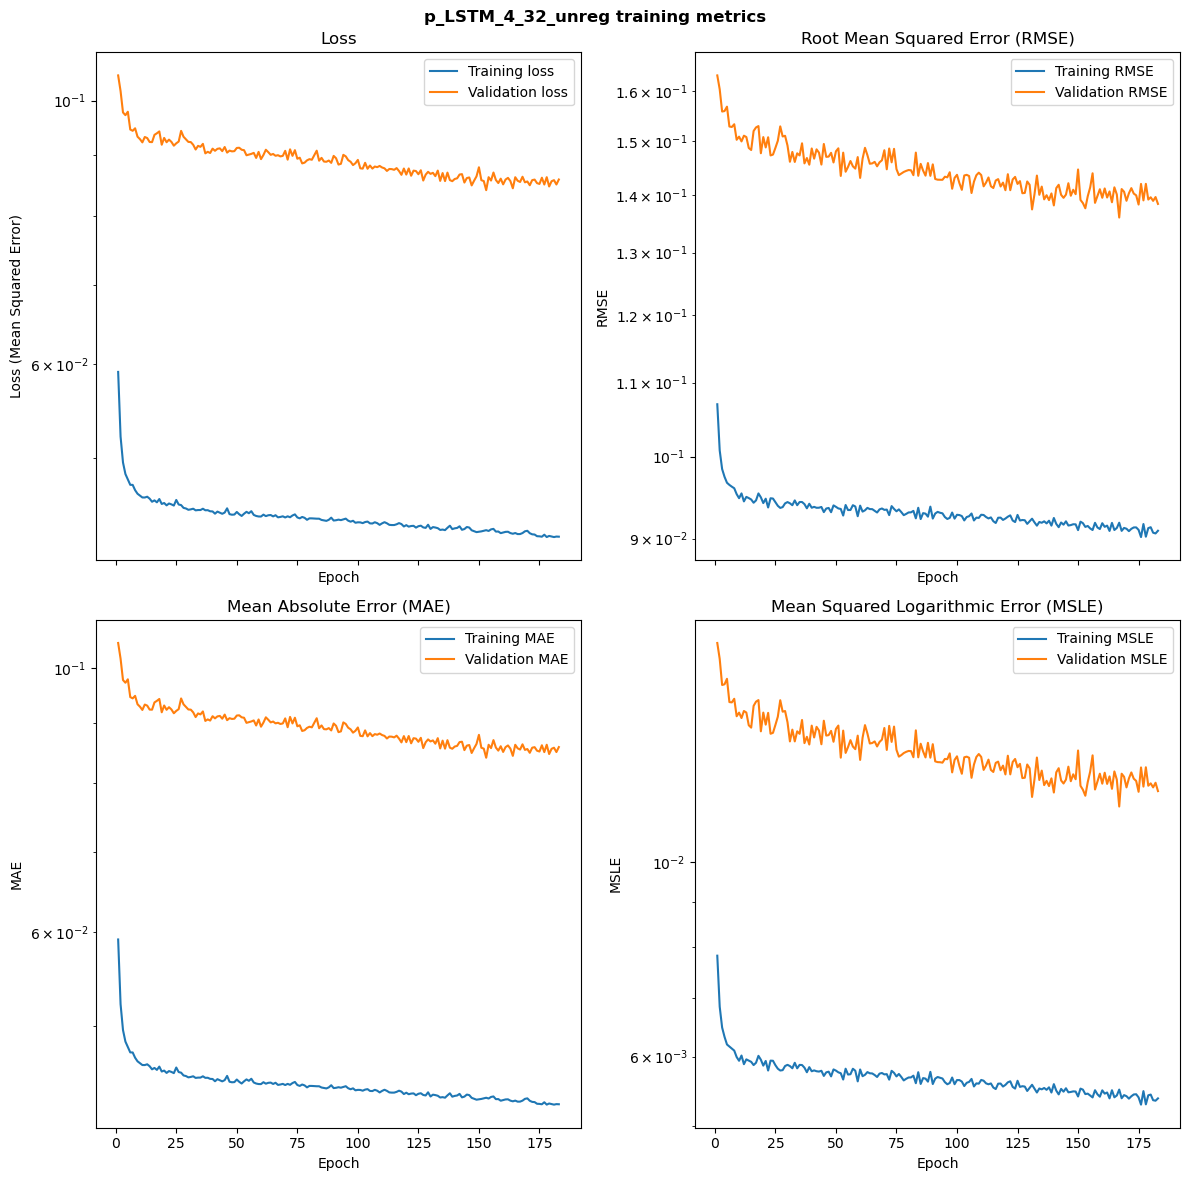

3/3 [==============================] - 1s 2ms/step
(6, 93)


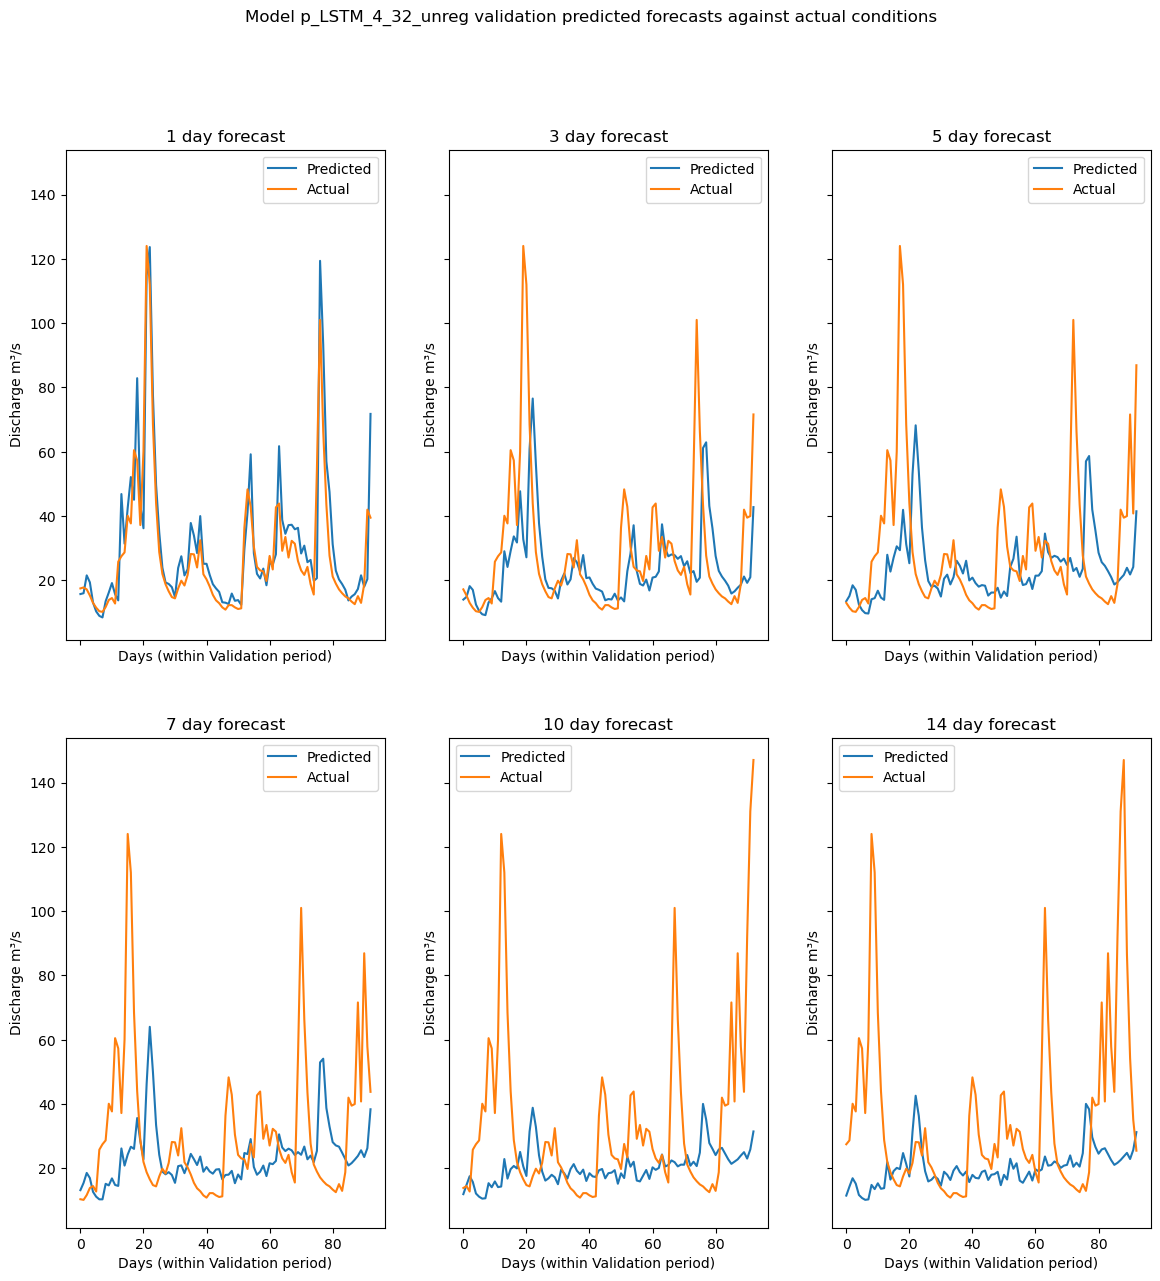

3/3 [==============================] - 0s 3ms/step
(6, 94)


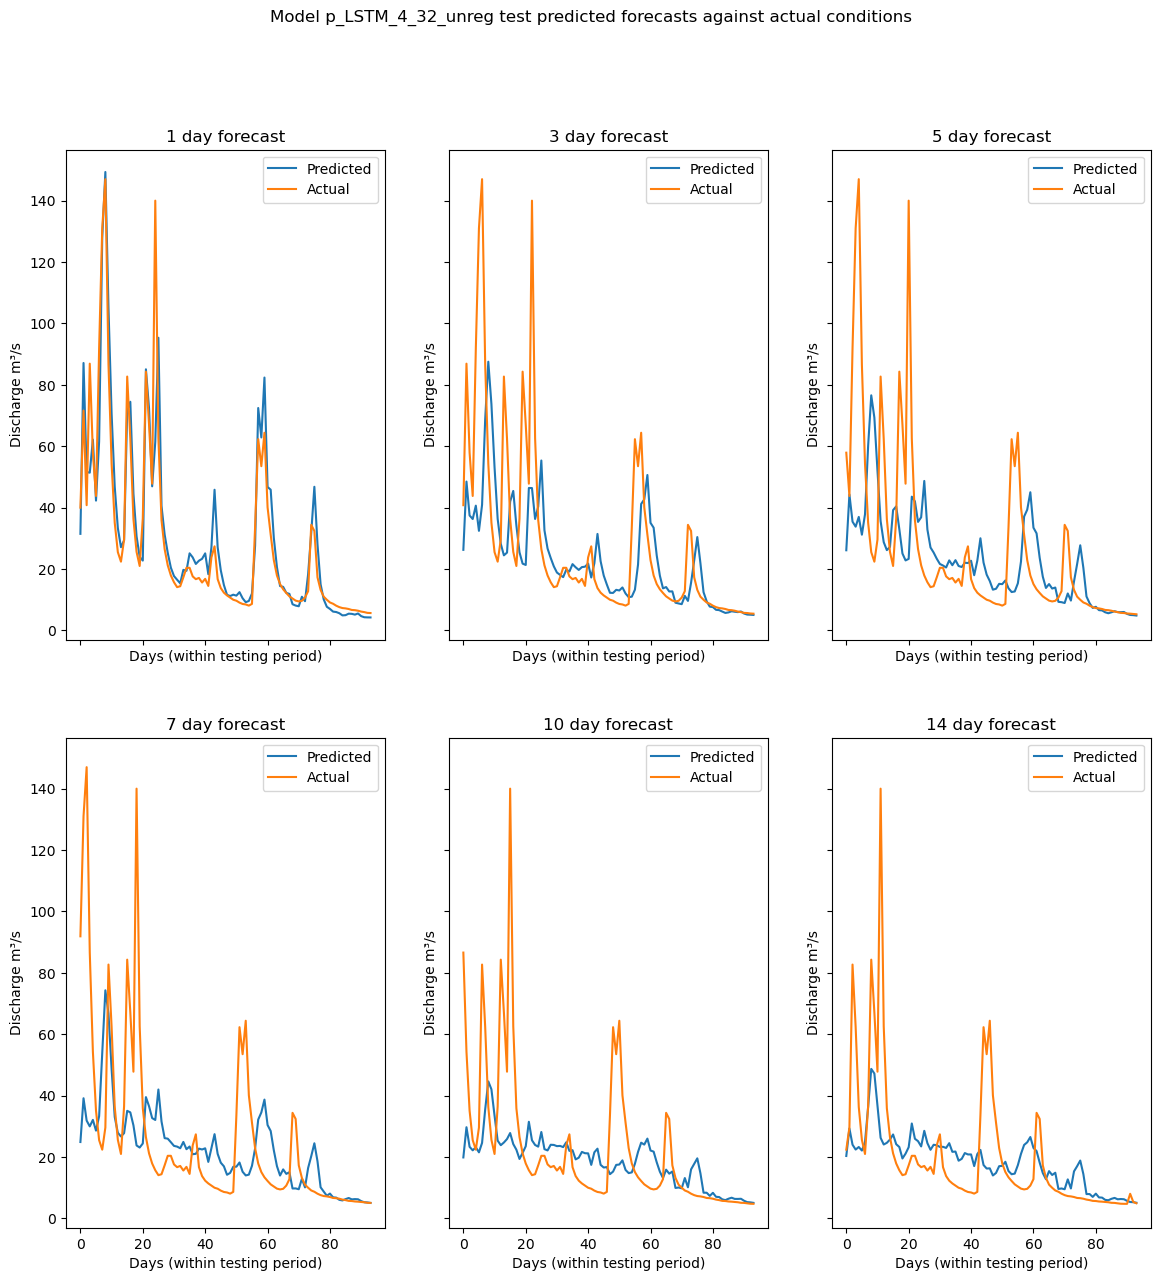

(6, 93)


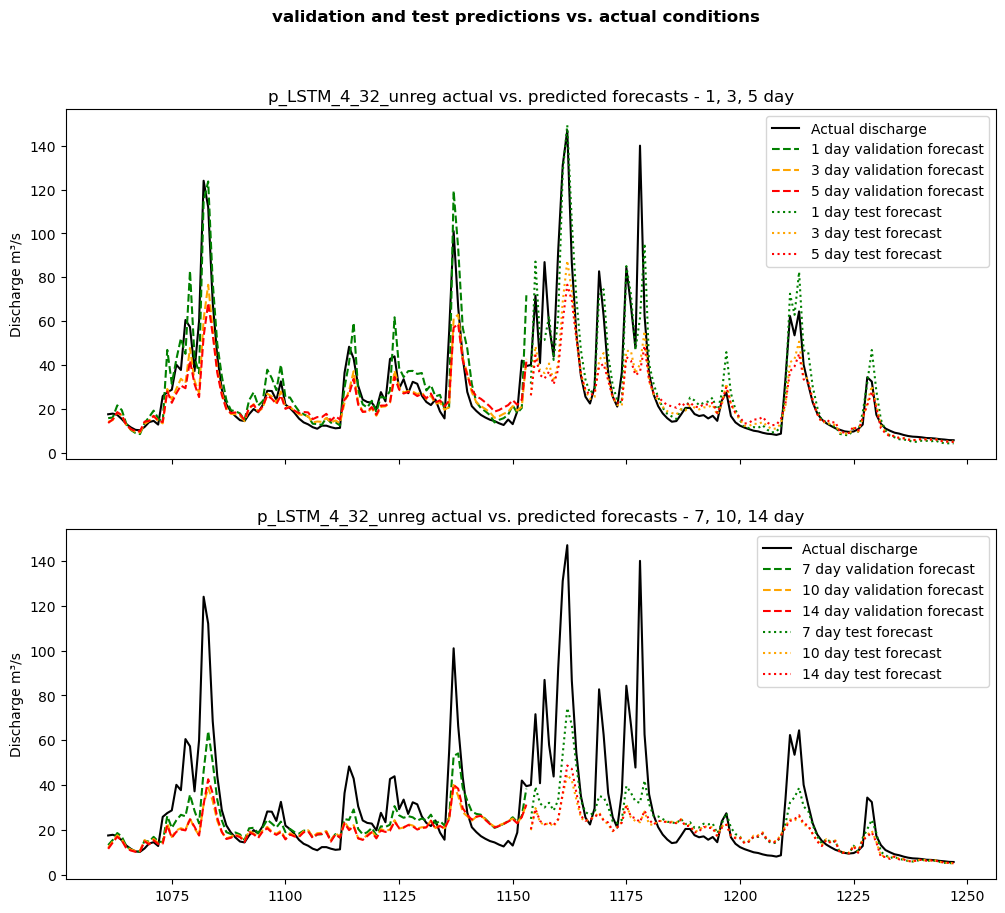

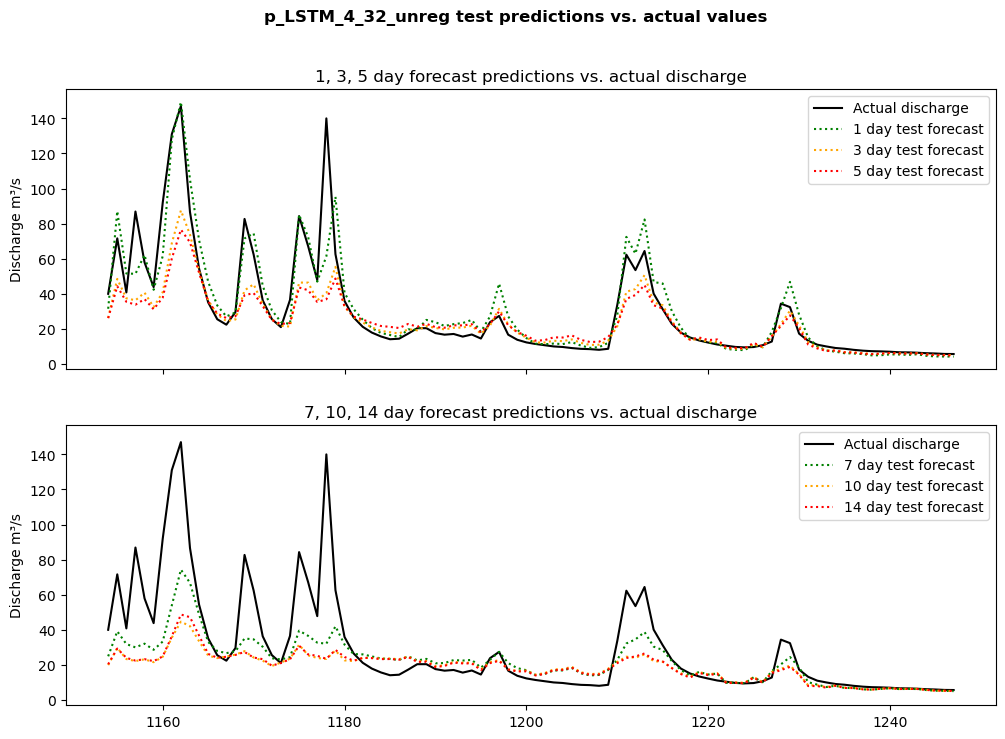

In [28]:
plot_training_metrics(p_lstm_4_32_unreg_hist, p_lstm_4_32_unreg_name)

p_lstm_4_32_unreg_val_results_df, p_lstm_4_32_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, p_lstm_4_32_unreg, p_lstm_4_32_unreg_name)

p_lstm_4_32_unreg_test_results_df, p_lstm_4_32_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, p_lstm_4_32_unreg, p_lstm_4_32_unreg_name)

plot_all_model_predictions_vs_actuals(p_lstm_4_32_unreg_all_val_predictions, p_lstm_4_32_unreg_all_test_predictions, p_lstm_4_32_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(p_lstm_4_32_unreg_all_test_predictions, p_lstm_4_32_unreg_name, y, X_train, X_val, X_test)

**Peephole LSTM; 4 layers; 32 units; regularized**

In [ ]:
p_lstm_4_32_reg_name = 'p_LSTM_4_32_reg'

p_lstm_4_32_reg = Sequential([
    RNN(PeepholeLSTMCell(units = 32, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True),
    LayerNormalization(),
    RNN(PeepholeLSTMCell(units = 32, kernel_constraint = NonNeg()), return_sequences = True),
    RNN(PeepholeLSTMCell(units = 32, kernel_constraint = NonNeg()), return_sequences = True),
    RNN(PeepholeLSTMCell(units = 32, kernel_constraint = NonNeg()), return_sequences = False),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

p_lstm_4_32_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

p_lstm_4_32_reg_hist = p_lstm_4_32_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(p_lstm_4_32_reg_hist, p_lstm_4_32_reg_name)

p_lstm_4_32_reg_val_results_df, p_lstm_4_32_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, p_lstm_4_32_reg, p_lstm_4_32_reg_name)

p_lstm_4_32_reg_test_results_df, p_lstm_4_32_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, p_lstm_4_32_reg, p_lstm_4_32_reg_name)

plot_all_model_predictions_vs_actuals(p_lstm_4_32_reg_all_val_predictions, p_lstm_4_32_reg_all_test_predictions, p_lstm_4_32_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(p_lstm_4_32_reg_all_test_predictions, p_lstm_4_32_reg_name, y, X_train, X_val, X_test)

**Peephole LSTM; 4 layers; 64 units; unregularized**

In [ ]:
p_lstm_4_64_unreg_name = 'p_LSTM_4_64_unreg'

p_lstm_4_64_unreg = Sequential([
    RNN(PeepholeLSTMCell(units = 64, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True),
    RNN(PeepholeLSTMCell(units = 64, kernel_constraint = NonNeg()), return_sequences = True),
    RNN(PeepholeLSTMCell(units = 64, kernel_constraint = NonNeg()), return_sequences = True),
    RNN(PeepholeLSTMCell(units = 64, kernel_constraint = NonNeg()), return_sequences = False),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

p_lstm_4_64_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

p_lstm_4_64_unreg_hist = p_lstm_4_64_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(p_lstm_4_64_unreg_hist, p_lstm_4_64_unreg_name)

p_lstm_4_64_unreg_val_results_df, p_lstm_4_64_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, p_lstm_4_64_unreg, p_lstm_4_64_unreg_name)

p_lstm_4_64_unreg_test_results_df, p_lstm_4_64_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, p_lstm_4_64_unreg, p_lstm_4_64_unreg_name)

plot_all_model_predictions_vs_actuals(p_lstm_4_64_unreg_all_val_predictions, p_lstm_4_64_unreg_all_test_predictions, p_lstm_4_64_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(p_lstm_4_64_unreg_all_test_predictions, p_lstm_4_64_unreg_name, y, X_train, X_val, X_test)

**Peephole LSTM; 4 layers; 64 units; regularized**

In [ ]:
p_lstm_4_64_reg_name = 'p_LSTM_4_64_reg'

p_lstm_4_64_reg = Sequential([
    RNN(PeepholeLSTMCell(units = 64, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True),
    LayerNormalization(),
    RNN(PeepholeLSTMCell(units = 64, kernel_constraint = NonNeg()), return_sequences = True),
    RNN(PeepholeLSTMCell(units = 64, kernel_constraint = NonNeg()), return_sequences = True),
    RNN(PeepholeLSTMCell(units = 64, kernel_constraint = NonNeg()), return_sequences = False),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

p_lstm_4_64_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

p_lstm_4_64_reg_hist = p_lstm_4_64_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(p_lstm_4_64_reg_hist, p_lstm_4_64_reg_name)

p_lstm_4_64_reg_val_results_df, p_lstm_4_64_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, p_lstm_4_64_reg, p_lstm_4_64_reg_name)

p_lstm_4_64_reg_test_results_df, p_lstm_4_64_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, p_lstm_4_64_reg, p_lstm_4_64_reg_name)

plot_all_model_predictions_vs_actuals(p_lstm_4_64_reg_all_val_predictions, p_lstm_4_64_reg_all_test_predictions, p_lstm_4_64_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(p_lstm_4_64_reg_all_test_predictions, p_lstm_4_64_reg_name, y, X_train, X_val, X_test)

**Bidirectional Peephole LSTMs**
================================

**Bidirectional Peephole LSTM; 2 layers; 16 units; unregularized**

In [ ]:
bi_p_lstm_2_16_unreg_name = 'bi_p_LSTM_2_16_unreg'

bi_p_lstm_2_16_unreg = Sequential([
    Bidirectional(RNN(PeepholeLSTMCell(units = 16, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True)),
    Bidirectional(RNN(PeepholeLSTMCell(units = 16, kernel_constraint = NonNeg()), return_sequences = False)),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_p_lstm_2_16_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_p_lstm_2_16_unreg_hist = bi_p_lstm_2_16_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_p_lstm_2_16_unreg_hist, bi_p_lstm_2_16_unreg_name)

bi_p_lstm_2_16_unreg_val_results_df, bi_p_lstm_2_16_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_p_lstm_2_16_unreg, bi_p_lstm_2_16_unreg_name)

bi_p_lstm_2_16_unreg_test_results_df, bi_p_lstm_2_16_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_p_lstm_2_16_unreg, bi_p_lstm_2_16_unreg_name)

plot_all_model_predictions_vs_actuals(bi_p_lstm_2_16_unreg_all_val_predictions, bi_p_lstm_2_16_unreg_all_test_predictions, bi_p_lstm_2_16_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_p_lstm_2_16_unreg_all_test_predictions, bi_p_lstm_2_16_unreg_name, y, X_train, X_val, X_test)

**Bidirectional Peephole LSTM; 2 layers; 16 units; regularized**

In [ ]:
bi_p_lstm_2_16_reg_name = 'bi_p_LSTM_2_16_reg'

bi_p_lstm_2_16_reg = Sequential([
    Bidirectional(RNN(PeepholeLSTMCell(units = 16, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True)),
    LayerNormalization(),
    Bidirectional(RNN(PeepholeLSTMCell(units = 16, kernel_constraint = NonNeg()), return_sequences = False)),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_p_lstm_2_16_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_p_lstm_2_16_reg_hist = bi_p_lstm_2_16_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_p_lstm_2_16_reg_hist, bi_p_lstm_2_16_reg_name)

bi_p_lstm_2_16_reg_val_results_df, bi_p_lstm_2_16_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_p_lstm_2_16_reg, bi_p_lstm_2_16_reg_name)

bi_p_lstm_2_16_reg_test_results_df, bi_p_lstm_2_16_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_p_lstm_2_16_reg, bi_p_lstm_2_16_reg_name)

plot_all_model_predictions_vs_actuals(bi_p_lstm_2_16_reg_all_val_predictions, bi_p_lstm_2_16_reg_all_test_predictions, bi_p_lstm_2_16_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_p_lstm_2_16_reg_all_test_predictions, bi_p_lstm_2_16_reg_name, y, X_train, X_val, X_test)

**Bidirectional Peephole LSTM; 2 layers; 32 units; unregularized**

In [ ]:
bi_p_lstm_2_32_unreg_name = 'bi_p_LSTM_2_32_unreg'

bi_p_lstm_2_32_unreg = Sequential([
    Bidirectional(RNN(PeepholeLSTMCell(units = 32, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True)),
    Bidirectional(RNN(PeepholeLSTMCell(units = 32, kernel_constraint = NonNeg()), return_sequences = False)),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_p_lstm_2_32_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_p_lstm_2_32_unreg_hist = bi_p_lstm_2_32_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_p_lstm_2_32_unreg_hist, bi_p_lstm_2_32_unreg_name)

bi_p_lstm_2_32_unreg_val_results_df, bi_p_lstm_2_32_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_p_lstm_2_32_unreg, bi_p_lstm_2_32_unreg_name)

bi_p_lstm_2_32_unreg_test_results_df, bi_p_lstm_2_32_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_p_lstm_2_32_unreg, bi_p_lstm_2_32_unreg_name)

plot_all_model_predictions_vs_actuals(bi_p_lstm_2_32_unreg_all_val_predictions, bi_p_lstm_2_32_unreg_all_test_predictions, bi_p_lstm_2_32_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_p_lstm_2_32_unreg_all_test_predictions, bi_p_lstm_2_32_unreg_name, y, X_train, X_val, X_test)

**Bidirectional Peephole LSTM; 2 layers; 32 units; regularized**

In [ ]:
bi_p_lstm_2_32_reg_name = 'bi_p_LSTM_2_32_reg'

bi_p_lstm_2_32_reg = Sequential([
    Bidirectional(RNN(PeepholeLSTMCell(units = 32, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True)),
    LayerNormalization(),
    Bidirectional(RNN(PeepholeLSTMCell(units = 32, kernel_constraint = NonNeg()), return_sequences = False)),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_p_lstm_2_32_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_p_lstm_2_32_reg_hist = bi_p_lstm_2_32_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_p_lstm_2_32_reg_hist, bi_p_lstm_2_32_reg_name)

bi_p_lstm_2_32_reg_val_results_df, bi_p_lstm_2_32_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_p_lstm_2_32_reg, bi_p_lstm_2_32_reg_name)

bi_p_lstm_2_32_reg_test_results_df, bi_p_lstm_2_32_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_p_lstm_2_32_reg, bi_p_lstm_2_32_reg_name)

plot_all_model_predictions_vs_actuals(bi_p_lstm_2_32_reg_all_val_predictions, bi_p_lstm_2_32_reg_all_test_predictions, bi_p_lstm_2_32_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_p_lstm_2_32_reg_all_test_predictions, bi_p_lstm_2_32_reg_name, y, X_train, X_val, X_test)

**Bidirectional Peephole LSTM; 2 layers; 64 units; unregularized**

In [ ]:
bi_p_lstm_2_64_unreg_name = 'bi_p_LSTM_2_64_unreg'

bi_p_lstm_2_64_unreg = Sequential([
    Bidirectional(RNN(PeepholeLSTMCell(units = 64, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True)),
    Bidirectional(RNN(PeepholeLSTMCell(units = 64, kernel_constraint = NonNeg()), return_sequences = False)),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_p_lstm_2_64_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_p_lstm_2_64_unreg_hist = bi_p_lstm_2_64_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_p_lstm_2_64_unreg_hist, bi_p_lstm_2_64_unreg_name)

bi_p_lstm_2_64_unreg_val_results_df, bi_p_lstm_2_64_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_p_lstm_2_64_unreg, bi_p_lstm_2_64_unreg_name)

bi_p_lstm_2_64_unreg_test_results_df, bi_p_lstm_2_64_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_p_lstm_2_64_unreg, bi_p_lstm_2_64_unreg_name)

plot_all_model_predictions_vs_actuals(bi_p_lstm_2_64_unreg_all_val_predictions, bi_p_lstm_2_64_unreg_all_test_predictions, bi_p_lstm_2_64_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_p_lstm_2_64_unreg_all_test_predictions, bi_p_lstm_2_64_unreg_name, y, X_train, X_val, X_test)

**Bidirectional Peephole LSTM; 2 layers; 64 units; regularized**

In [ ]:
bi_p_lstm_2_64_reg_name = 'bi_p_LSTM_2_64_reg'

bi_p_lstm_2_64_reg = Sequential([
    Bidirectional(RNN(PeepholeLSTMCell(units = 64, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True)),
    LayerNormalization(),
    Bidirectional(RNN(PeepholeLSTMCell(units = 64, kernel_constraint = NonNeg()), return_sequences = False)),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_p_lstm_2_64_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_p_lstm_2_64_reg_hist = bi_p_lstm_2_64_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_p_lstm_2_64_reg_hist, bi_p_lstm_2_64_reg_name)

bi_p_lstm_2_64_reg_val_results_df, bi_p_lstm_2_64_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_p_lstm_2_64_reg, bi_p_lstm_2_64_reg_name)

bi_p_lstm_2_64_reg_test_results_df, bi_p_lstm_2_64_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_p_lstm_2_64_reg, bi_p_lstm_2_64_reg_name)

plot_all_model_predictions_vs_actuals(bi_p_lstm_2_64_reg_all_val_predictions, bi_p_lstm_2_64_reg_all_test_predictions, bi_p_lstm_2_64_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_p_lstm_2_64_reg_all_test_predictions, bi_p_lstm_2_64_reg_name, y, X_train, X_val, X_test)

**Bidirectional Peephole LSTM; 4 layers; 16 units; unregularized**

In [ ]:
bi_p_lstm_4_16_unreg_name = 'bi_p_LSTM_4_16_unreg'

bi_p_lstm_4_16_unreg = Sequential([
    Bidirectional(RNN(PeepholeLSTMCell(units = 16, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True)),
    Bidirectional(RNN(PeepholeLSTMCell(units = 16, kernel_constraint = NonNeg()), return_sequences = True)),
    Bidirectional(RNN(PeepholeLSTMCell(units = 16, kernel_constraint = NonNeg()), return_sequences = True)),
    Bidirectional(RNN(PeepholeLSTMCell(units = 16, kernel_constraint = NonNeg()), return_sequences = False)),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_p_lstm_4_16_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_p_lstm_4_16_unreg_hist = bi_p_lstm_4_16_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_p_lstm_4_16_unreg_hist, bi_p_lstm_4_16_unreg_name)

bi_p_lstm_4_16_unreg_val_results_df, bi_p_lstm_4_16_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_p_lstm_4_16_unreg, bi_p_lstm_4_16_unreg_name)

bi_p_lstm_4_16_unreg_test_results_df, bi_p_lstm_4_16_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_p_lstm_4_16_unreg, bi_p_lstm_4_16_unreg_name)

plot_all_model_predictions_vs_actuals(bi_p_lstm_4_16_unreg_all_val_predictions, bi_p_lstm_4_16_unreg_all_test_predictions, bi_p_lstm_4_16_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_p_lstm_4_16_unreg_all_test_predictions, bi_p_lstm_4_16_unreg_name, y, X_train, X_val, X_test)

**Bidirectional Peephole LSTM; 4 layers; 16 units; regularized**

In [ ]:
bi_p_lstm_4_16_reg_name = 'bi_p_LSTM_4_16_reg'

bi_p_lstm_4_16_reg = Sequential([
    Bidirectional(RNN(PeepholeLSTMCell(units = 16, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True)),
    LayerNormalization(),
    Bidirectional(RNN(PeepholeLSTMCell(units = 16, kernel_constraint = NonNeg()), return_sequences = True)),
    Bidirectional(RNN(PeepholeLSTMCell(units = 16, kernel_constraint = NonNeg()), return_sequences = True)),
    Bidirectional(RNN(PeepholeLSTMCell(units = 16, kernel_constraint = NonNeg()), return_sequences = False)),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_p_lstm_4_16_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_p_lstm_4_16_reg_hist = bi_p_lstm_4_16_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_p_lstm_4_16_reg_hist, bi_p_lstm_4_16_reg_name)

bi_p_lstm_4_16_reg_val_results_df, bi_p_lstm_4_16_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_p_lstm_4_16_reg, bi_p_lstm_4_16_reg_name)

bi_p_lstm_4_16_reg_test_results_df, bi_p_lstm_4_16_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_p_lstm_4_16_reg, bi_p_lstm_4_16_reg_name)

plot_all_model_predictions_vs_actuals(bi_p_lstm_4_16_reg_all_val_predictions, bi_p_lstm_4_16_reg_all_test_predictions, bi_p_lstm_4_16_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_p_lstm_4_16_reg_all_test_predictions, bi_p_lstm_4_16_reg_name, y, X_train, X_val, X_test)

**Bidirectional Peephole LSTM; 4 layers; 32 units; unregularized**

In [ ]:
bi_p_lstm_4_32_unreg_name = 'bi_p_LSTM_4_32_unreg'

bi_p_lstm_4_32_unreg = Sequential([
    Bidirectional(RNN(PeepholeLSTMCell(units = 32, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True)),
    Bidirectional(RNN(PeepholeLSTMCell(units = 32, kernel_constraint = NonNeg()), return_sequences = True)),
    Bidirectional(RNN(PeepholeLSTMCell(units = 32, kernel_constraint = NonNeg()), return_sequences = True)),
    Bidirectional(RNN(PeepholeLSTMCell(units = 32, kernel_constraint = NonNeg()), return_sequences = False)),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_p_lstm_4_32_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_p_lstm_4_32_unreg_hist = bi_p_lstm_4_32_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_p_lstm_4_32_unreg_hist, bi_p_lstm_4_32_unreg_name)

bi_p_lstm_4_32_unreg_val_results_df, bi_p_lstm_4_32_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_p_lstm_4_32_unreg, bi_p_lstm_4_32_unreg_name)

bi_p_lstm_4_32_unreg_test_results_df, bi_p_lstm_4_32_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_p_lstm_4_32_unreg, bi_p_lstm_4_32_unreg_name)

plot_all_model_predictions_vs_actuals(bi_p_lstm_4_32_unreg_all_val_predictions, bi_p_lstm_4_32_unreg_all_test_predictions, bi_p_lstm_4_32_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_p_lstm_4_32_unreg_all_test_predictions, bi_p_lstm_4_32_unreg_name, y, X_train, X_val, X_test)

**Bidirectional Peephole LSTM; 4 layers; 32 units; regularized**

In [ ]:
bi_p_lstm_4_32_reg_name = 'bi_p_LSTM_4_32_reg'

bi_p_lstm_4_32_reg = Sequential([
    Bidirectional(RNN(PeepholeLSTMCell(units = 32, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True)),
    LayerNormalization(),
    Bidirectional(RNN(PeepholeLSTMCell(units = 32, kernel_constraint = NonNeg()), return_sequences = True)),
    Bidirectional(RNN(PeepholeLSTMCell(units = 32, kernel_constraint = NonNeg()), return_sequences = True)),
    Bidirectional(RNN(PeepholeLSTMCell(units = 32, kernel_constraint = NonNeg()), return_sequences = False)),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_p_lstm_4_32_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_p_lstm_4_32_reg_hist = bi_p_lstm_4_32_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_p_lstm_4_32_reg_hist, bi_p_lstm_4_32_reg_name)

bi_p_lstm_4_32_reg_val_results_df, bi_p_lstm_4_32_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_p_lstm_4_32_reg, bi_p_lstm_4_32_reg_name)

bi_p_lstm_4_32_reg_test_results_df, bi_p_lstm_4_32_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_p_lstm_4_32_reg, bi_p_lstm_4_32_reg_name)

plot_all_model_predictions_vs_actuals(bi_p_lstm_4_32_reg_all_val_predictions, bi_p_lstm_4_32_reg_all_test_predictions, bi_p_lstm_4_32_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_p_lstm_4_32_reg_all_test_predictions, bi_p_lstm_4_32_reg_name, y, X_train, X_val, X_test)

**Bidirectional Peephole LSTM; 4 layers; 64 units; unregularized**

In [ ]:
bi_p_lstm_4_64_unreg_name = 'bi_p_LSTM_4_64_unreg'

bi_p_lstm_4_64_unreg = Sequential([
    Bidirectional(RNN(PeepholeLSTMCell(units = 64, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True)),
    Bidirectional(RNN(PeepholeLSTMCell(units = 64, kernel_constraint = NonNeg()), return_sequences = True)),
    Bidirectional(RNN(PeepholeLSTMCell(units = 64, kernel_constraint = NonNeg()), return_sequences = True)),
    Bidirectional(RNN(PeepholeLSTMCell(units = 64, kernel_constraint = NonNeg()), return_sequences = False)),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_p_lstm_4_64_unreg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_p_lstm_4_64_unreg_hist = bi_p_lstm_4_64_unreg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

In [ ]:
plot_training_metrics(bi_p_lstm_4_64_unreg_hist, bi_p_lstm_4_64_unreg_name)

bi_p_lstm_4_64_unreg_val_results_df, bi_p_lstm_4_64_unreg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_p_lstm_4_64_unreg, bi_p_lstm_4_64_unreg_name)

bi_p_lstm_4_64_unreg_test_results_df, bi_p_lstm_4_64_unreg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_p_lstm_4_64_unreg, bi_p_lstm_4_64_unreg_name)

plot_all_model_predictions_vs_actuals(bi_p_lstm_4_64_unreg_all_val_predictions, bi_p_lstm_4_64_unreg_all_test_predictions, bi_p_lstm_4_64_unreg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_p_lstm_4_64_unreg_all_test_predictions, bi_p_lstm_4_64_unreg_name, y, X_train, X_val, X_test)

**Bidirectional Peephole LSTM; 4 layers; 64 units; regularized**

In [37]:
bi_p_lstm_4_64_reg_name = 'bi_p_LSTM_4_64_reg'

bi_p_lstm_4_64_reg = Sequential([
    Bidirectional(RNN(PeepholeLSTMCell(units = 64, input_shape = X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True)),
    LayerNormalization(),
    Bidirectional(RNN(PeepholeLSTMCell(units = 64, kernel_constraint = NonNeg()), return_sequences = True)),
    Bidirectional(RNN(PeepholeLSTMCell(units = 64, kernel_constraint = NonNeg()), return_sequences = True)),
    Bidirectional(RNN(PeepholeLSTMCell(units = 64, kernel_constraint = NonNeg()), return_sequences = False)),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

bi_p_lstm_4_64_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

bi_p_lstm_4_64_reg_hist = bi_p_lstm_4_64_reg.fit(X_train_3D_scaled, y_train_scaled,
                            validation_data = (X_val_3D_scaled, y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

Epoch 1/250
34/34 [==============================] - 15s 52ms/step - loss: 0.0712 - root_mean_squared_error: 0.1144 - mean_absolute_error: 0.0712 - mean_squared_logarithmic_error: 0.0080 - val_loss: 0.0884 - val_root_mean_squared_error: 0.1451 - val_mean_absolute_error: 0.0884 - val_mean_squared_logarithmic_error: 0.0134 - lr: 0.0010
Epoch 2/250
34/34 [==============================] - 0s 11ms/step - loss: 0.0469 - root_mean_squared_error: 0.0948 - mean_absolute_error: 0.0469 - mean_squared_logarithmic_error: 0.0059 - val_loss: 0.0905 - val_root_mean_squared_error: 0.1461 - val_mean_absolute_error: 0.0905 - val_mean_squared_logarithmic_error: 0.0137 - lr: 0.0010
Epoch 3/250
34/34 [==============================] - 0s 11ms/step - loss: 0.0459 - root_mean_squared_error: 0.0931 - mean_absolute_error: 0.0459 - mean_squared_logarithmic_error: 0.0057 - val_loss: 0.0904 - val_root_mean_squared_error: 0.1462 - val_mean_absolute_error: 0.0904 - val_mean_squared_logarithmic_error: 0.0137 - lr: 0

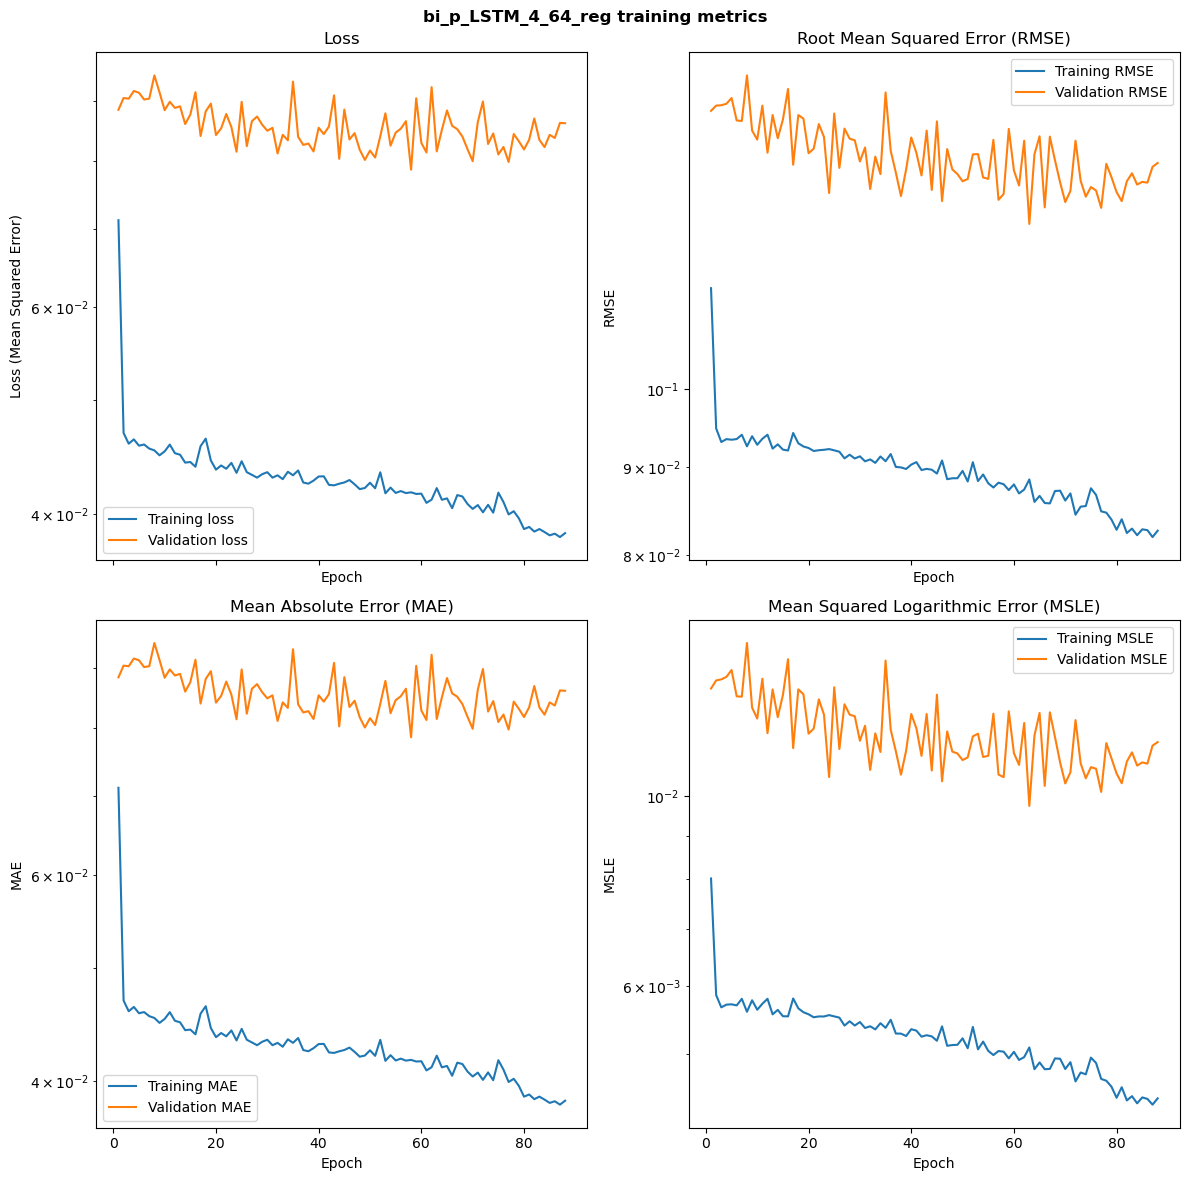

3/3 [==============================] - 1s 4ms/step
(6, 93)


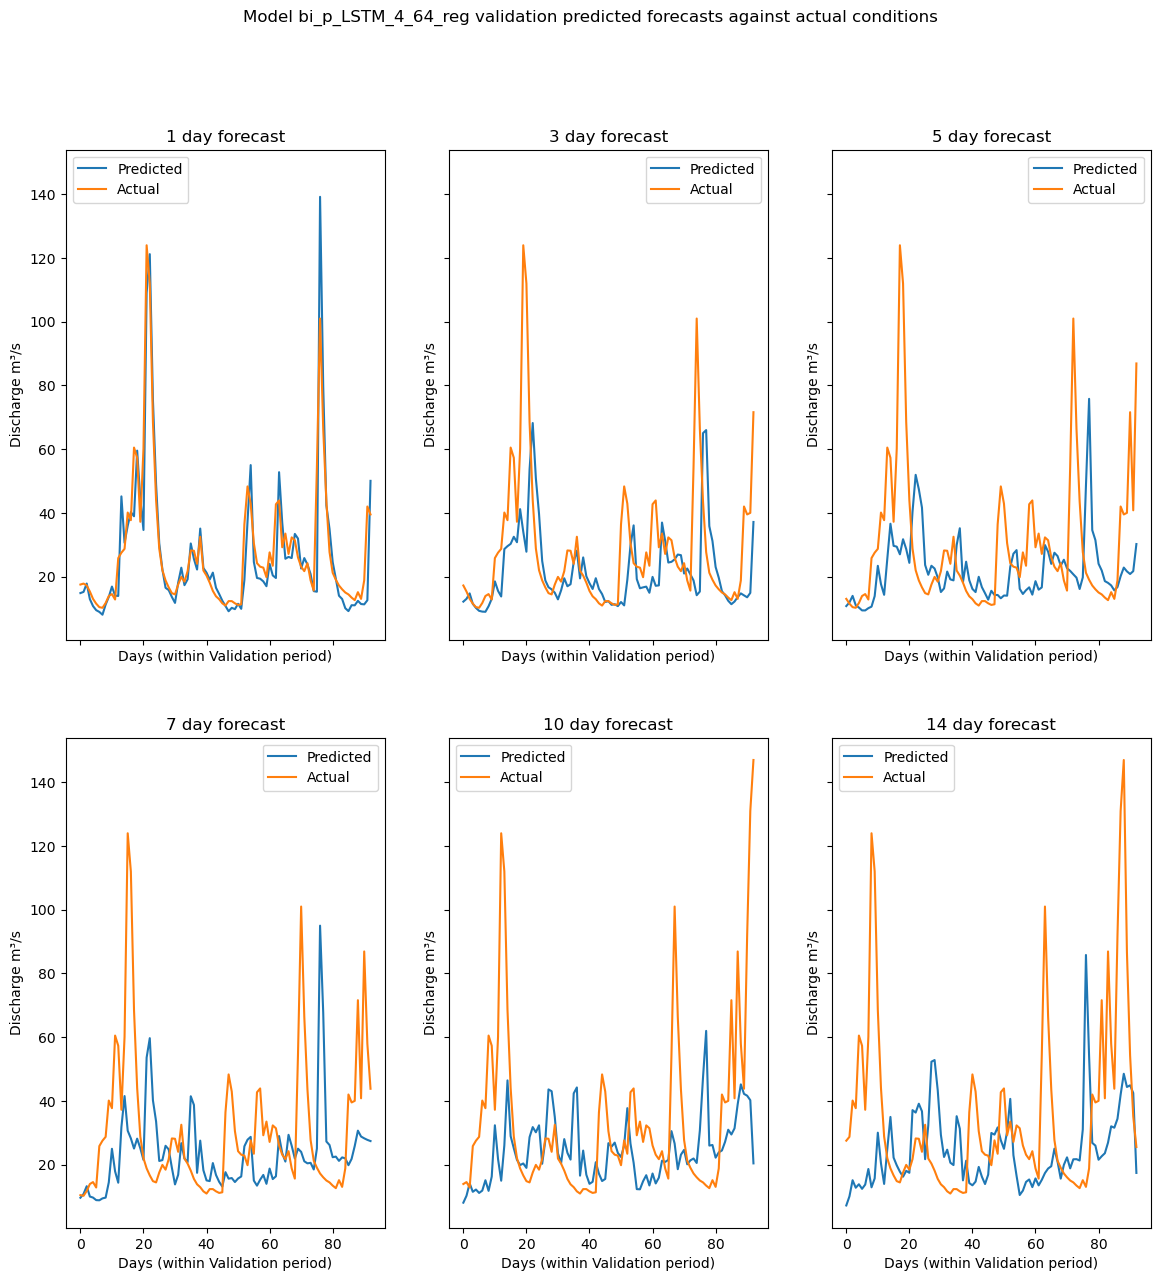

3/3 [==============================] - 0s 4ms/step
(6, 94)


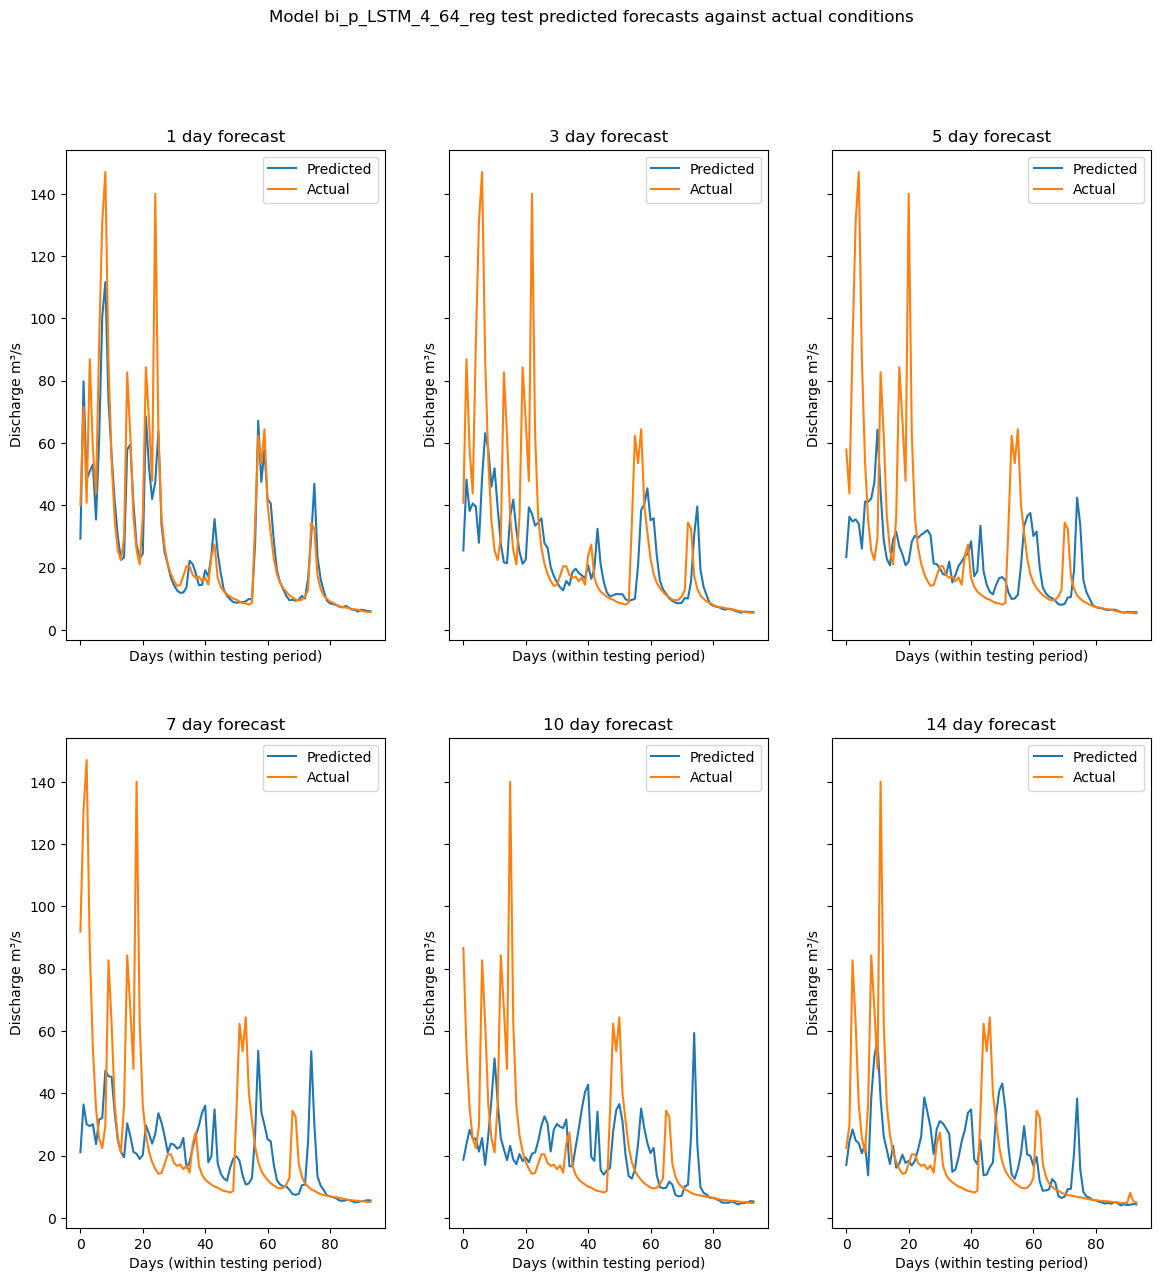

(6, 93)


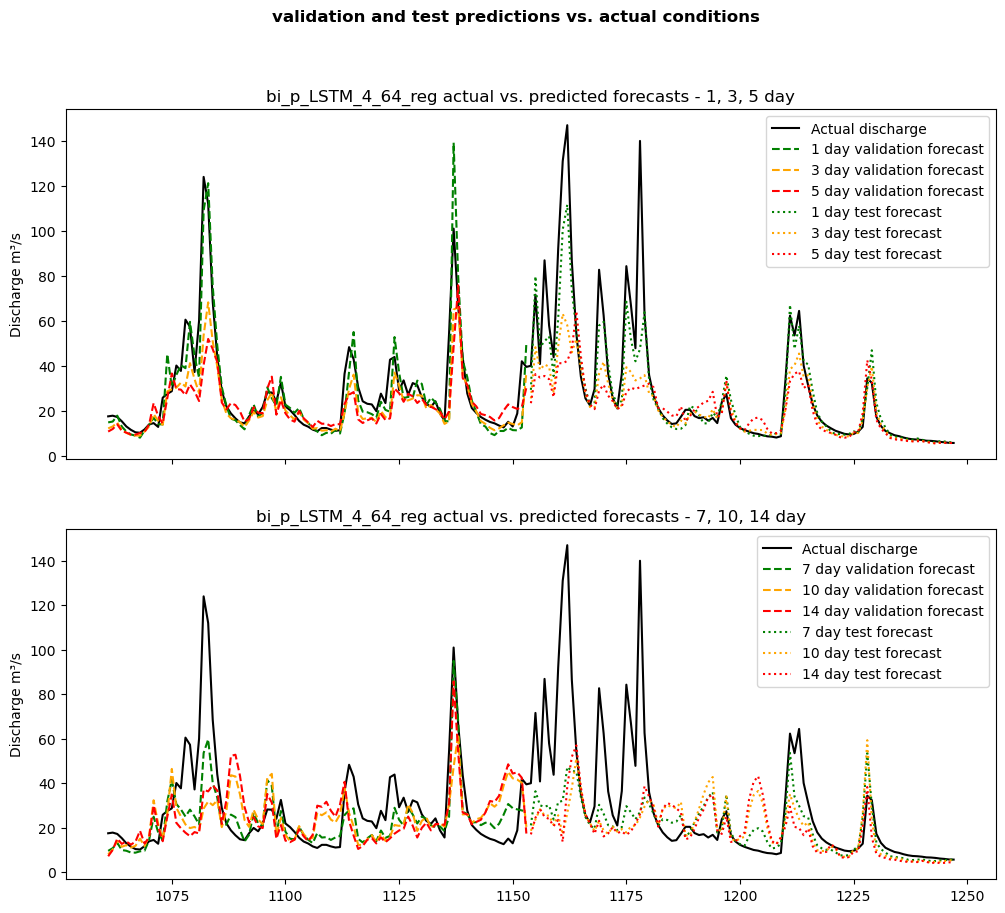

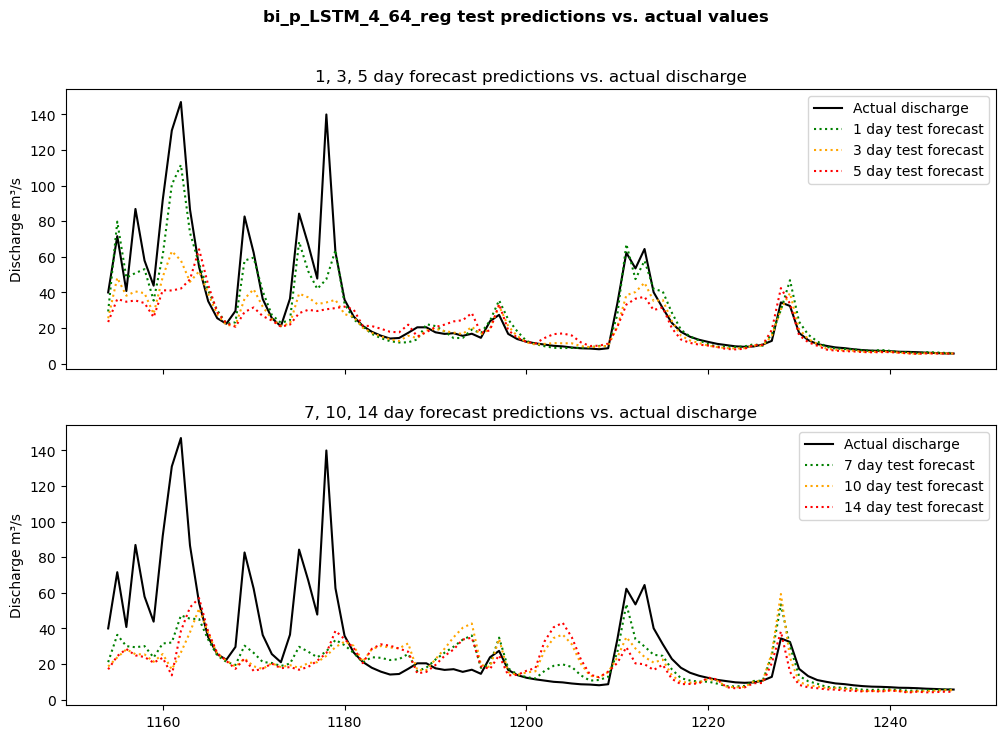

In [38]:
plot_training_metrics(bi_p_lstm_4_64_reg_hist, bi_p_lstm_4_64_reg_name)

bi_p_lstm_4_64_reg_val_results_df, bi_p_lstm_4_64_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_scaled, bi_p_lstm_4_64_reg, bi_p_lstm_4_64_reg_name)

bi_p_lstm_4_64_reg_test_results_df, bi_p_lstm_4_64_reg_all_test_predictions = plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_scaled, bi_p_lstm_4_64_reg, bi_p_lstm_4_64_reg_name)

plot_all_model_predictions_vs_actuals(bi_p_lstm_4_64_reg_all_val_predictions, bi_p_lstm_4_64_reg_all_test_predictions, bi_p_lstm_4_64_reg_name, y, X_train, X_val, X_test)

plot_model_test_predictions_vs_actuals(bi_p_lstm_4_64_reg_all_test_predictions, bi_p_lstm_4_64_reg_name, y, X_train, X_val, X_test)

3/3 [==============================] - 0s 5ms/step - loss: 0.0697 - root_mean_squared_error: 0.1260 - mean_absolute_error: 0.0697 - mean_squared_logarithmic_error: 0.0097


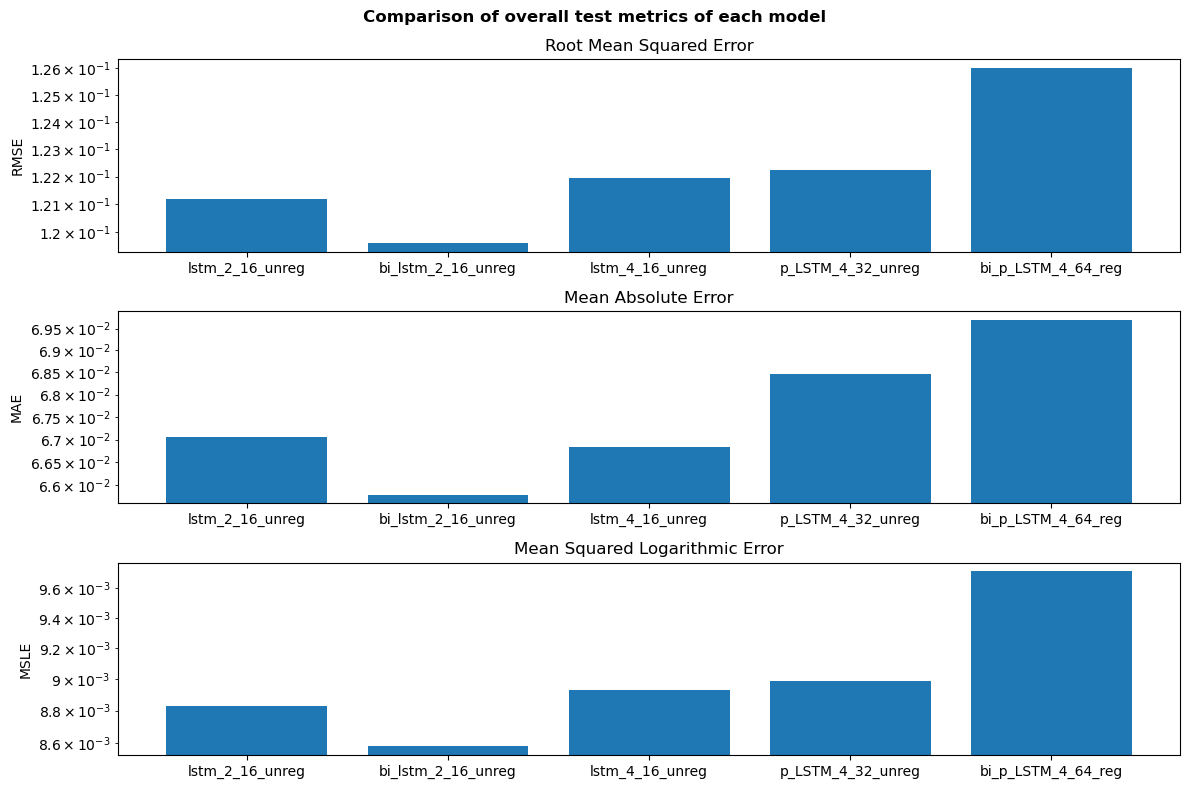

model_name      loss root_mean_squared_error mean_absolute_error  \
0     lstm_2_16_unreg  0.067048                0.121189            0.067048   
1  bi_lstm_2_16_unreg  0.065792                0.119611            0.065792   
2     lstm_4_16_unreg  0.066844                0.121932            0.066844   
3   p_LSTM_4_32_unreg  0.068472                0.122253            0.068472   
4  bi_p_LSTM_4_64_reg  0.069701                0.126001            0.069701   

  mean_squared_logarithmic_error  
0                       0.008828  
1                        0.00858  
2                       0.008928  
3                       0.008987  
4                       0.009714

In [39]:
plot_all_model_test_metrics(models_list, model_names_list, X_test_3D_scaled, y_test_scaled)